In [67]:
import torch
from torch import nn, tensor, Tensor
import json
import os
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
from explaination import adj_matrix_to_heights, print_listlike
from dep_model import DependencyParser, Hparam
from tqdm import tqdm, trange
from collections import defaultdict
import pickle as pkl
from explaination import integral_torch_cuda
from typing import List

## Visualization

In [7]:
with open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/mi_1.json'), 'r') as f_mi, open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/label_names.txt'), 'r') as f_name:
    mi = json.load(f_mi)
    label_names = json.load(f_name)
    mi = torch.Tensor(mi['binary_label_mi'])
    mi = torch.softmax(mi, dim=-1)

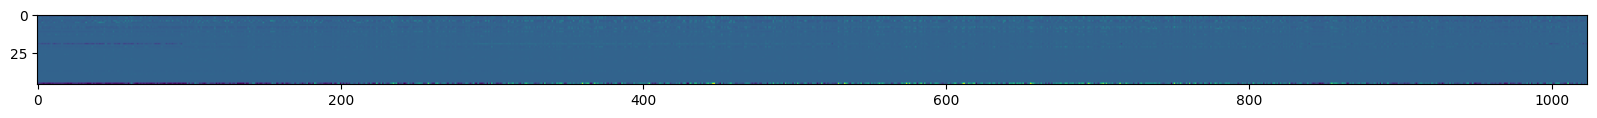

In [18]:
plt.figure(figsize=(20, 4))
plt.imshow(mi)

In [21]:
module = torch.load(osp.expanduser('~/pretrained-models/kde/open_llama_7b/baselines/mlp_1e-05_1e-05/best_model.pt'), map_location='cpu')
label_features_sample = torch.load(osp.expanduser('~/pretrained-models/kde/open_llama_7b/label_attn_samples_1_05of39.pkl'), map_location='cpu')
print(module['mlp.weight'].shape)
print([idx for idx, each in enumerate(label_features_sample) if each.numel() == 0])
print(label_names)

torch.Size([47, 1024])
[0, 45, 46]
['<UNK>', 'prep', 'det', 'nn', 'num', 'pobj', 'punct', 'poss', 'possessive', 'amod', 'nsubj', 'appos', 'dobj', 'dep', 'cc', 'conj', 'nsubjpass', 'partmod', 'auxpass', 'advmod', 'root', 'ccomp', 'aux', 'cop', 'xcomp', 'quantmod', 'tmod', 'neg', 'infmod', 'rcmod', 'pcomp', 'mark', 'advcl', 'predet', 'csubj', 'mwe', 'parataxis', 'npadvmod', 'number', 'acomp', 'prt', 'iobj', 'preconj', 'expl', 'discourse', 'csubjpass', '<s>']


## Veryfying Higher-Layer Higher-Dependency Assumption

In [3]:
dep_parser_llama = DependencyParser(
    json.load(open('./configs/openllama/sample_labelmap.json')), 
    Hparam(**json.load(open('./configs/openllama/sample_hpara.json'))), 
    osp.expanduser('~/pretrained-models/open_llama_7b'), device_to_place='cpu'
) 

train_data_llama = dep_parser_llama.load_data('./data/train.conllu')

You are using the default legacy behaviour of the <class 'modules.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/data/lhx/lhx-OpenPrompt/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


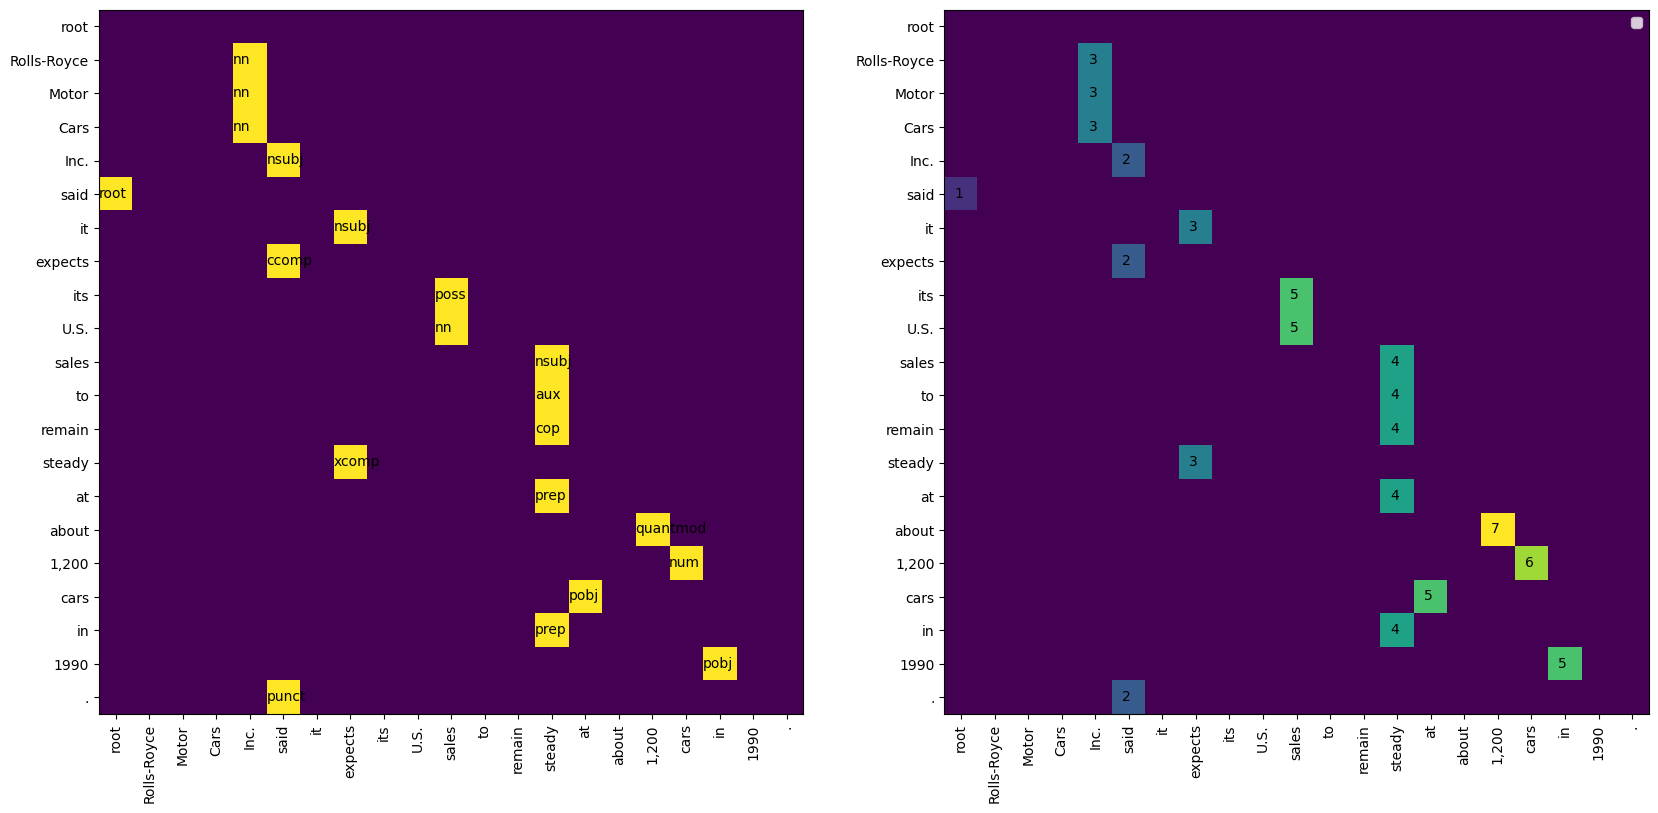

In [38]:
example = train_data_llama[2]
def visualize_adj_matrix(example):
    heads = example.head
    labels = ['root'] + example.text_a.split()
    adj_matrix = torch.zeros((len(heads) + 1, len(heads) + 1))
    for idx, head in enumerate(heads, start=1):
        adj_matrix[idx][head] = 1
    height_matrix = adj_matrix_to_heights(adj_matrix)
    fig = plt.figure(figsize=(20, 10))
    axes = fig.subplots(1, 2)
    axes[0].imshow(adj_matrix)
    axes[0].set_xticks([*range(len(labels))])
    axes[0].set_yticks([*range(len(labels))])
    axes[0].set_xticklabels(labels, rotation=90)
    axes[0].set_yticklabels(labels)
    axes[1].imshow(height_matrix)
    axes[1].set_xticks([*range(len(labels))])
    axes[1].set_yticks([*range(len(labels))])
    axes[1].set_xticklabels(labels, rotation=90)
    axes[1].set_yticklabels(labels)
    axes[1].legend()
    for idx, head in enumerate(heads, start=1):
        axes[0].text(head - 0.5, idx + 0.1, example.label[idx - 1])
    for idx, head in enumerate(heads, start=1):
        axes[1].text(head - 0.2, idx + 0.1, int(height_matrix[idx].max().item()))

visualize_adj_matrix(example)

In [39]:
label2heights = defaultdict(list)
for each in tqdm(train_data_llama, desc='iterating over training data for heights'):
    heads = each.head
    adj_matrix = torch.zeros((len(heads) + 1, len(heads) + 1))
    for idx, head in enumerate(heads, start=1):
        adj_matrix[idx][head] = 1
    height_matrix = adj_matrix_to_heights(adj_matrix)
    for idx in range(1, len(adj_matrix)):
        height_adj_entry = height_matrix[idx]
        assert height_adj_entry.unique().numel() == 2, f"error, different heads for same matrix: {height_adj_entry}"
        label2heights[each.label[idx-1]].append(height_adj_entry.max().item())


iterating over training data for heights: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39832/39832 [01:07<00:00, 593.68it/s]


In [76]:
label_and_avg_heights = [(name, sum(heights) / len(heights)) for name, heights in label2heights.items()]
label_from_top_to_bottom = [each[0] for each in sorted(label_and_avg_heights, key=lambda x: x[1])]

In [81]:
with open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/mi_1.json'), 'r') as f:
    mi = torch.tensor(json.load(f)['binary_label_mi'])[:-1]
with open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/mi_1_transpose.json'), 'r') as f:
    mi_t = torch.tensor(json.load(f)['binary_label_mi'])[:-1]
with open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/label_names.txt'), 'r') as f:
    label_names = json.load(f)[1:-1]

In [88]:
print((mi / mi_t).mean())

tensor(0.1612)


In [89]:
cumsum_matrix = mi.cumsum(dim=-1)
middle_indices = torch.searchsorted(cumsum_matrix, mi.sum(dim=-1, keepdim=True) / 2).view(-1)
sorted_label_indices = torch.argsort(middle_indices).tolist()
print(len(label_names), len(sorted_label_indices))
sorted_label_names = [label_names[idx] for idx in sorted_label_indices]
print('label names (lower rank means attributed by lower layers)')
print('===' * 80)
print_listlike(sorted_label_names)
print('label names (lower rank means bottom nodes)')
print('===' * 80)
print_listlike(label_from_top_to_bottom[::-1])
stds = mi.std(dim=-1).view(-1)
saliency_mask = stds > stds.median()
saliency_mask_for_label_from_top_to_bottom = [saliency_mask[label_names.index(each)] for each in label_from_top_to_bottom]

45 45
label names (lower rank means attributed by lower layers)
csubjpass discourse parataxis csubj advcl infmod xcomp prep prt acomp
partmod pcomp pobj rcmod conj ccomp tmod possessive punct npadvmod
cc mwe root dep dobj quantmod num appos number mark
nn nsubjpass advmod iobj predet amod poss aux expl det
preconj nsubj auxpass neg cop
label names (lower rank means bottom nodes)
possessive mwe number quantmod poss amod pobj det nn num
preconj predet rcmod conj infmod npadvmod pcomp partmod cc appos
dep prep mark prt aux advmod dobj tmod iobj acomp
auxpass neg xcomp nsubjpass cop nsubj discourse expl punct advcl
csubj ccomp csubjpass parataxis root


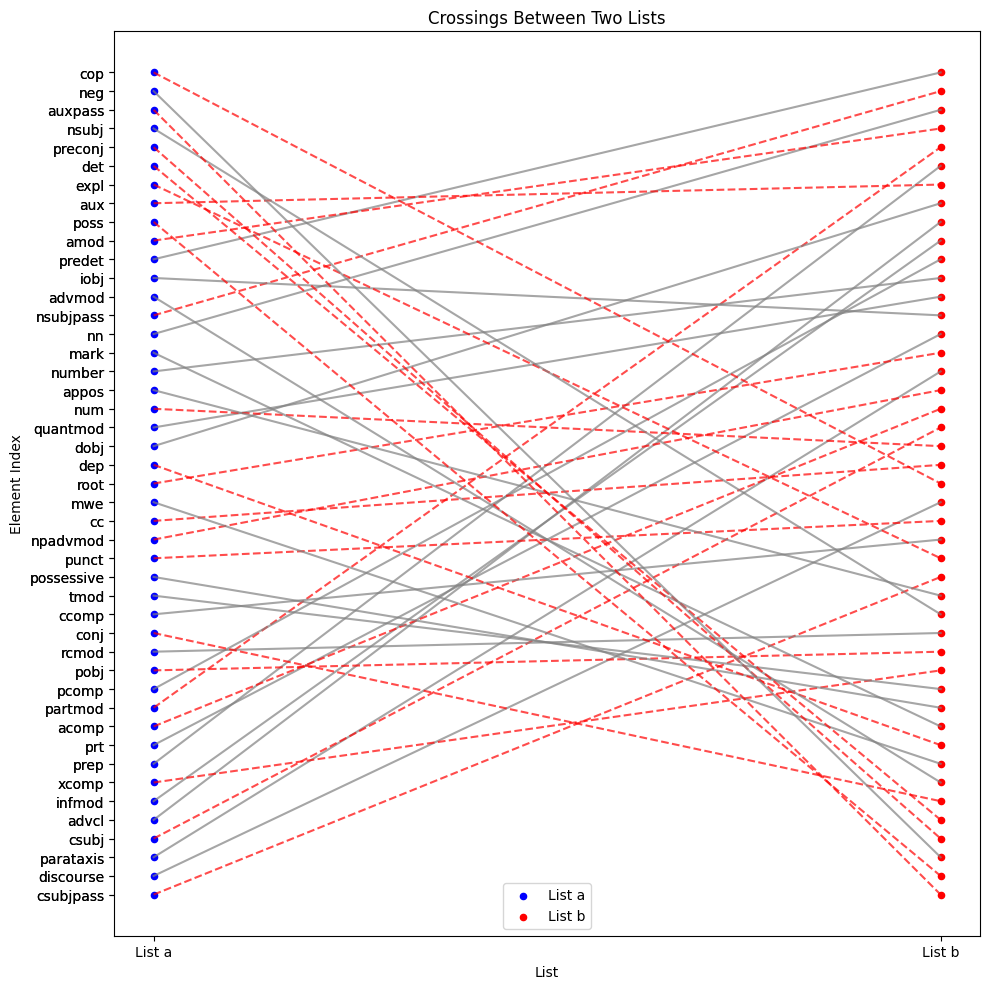

In [90]:

def plot_crossings(a, b, saliency_mask = None):
    # Create a dictionary for quick index lookup
    index_in_b = {value: i for i, value in enumerate(b)}
    if saliency_mask is None:
        saliency_mask = [0] * len(a)

    # Prepare the plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the left list (a)
    y_a = np.arange(len(a))
    ax.scatter(np.zeros_like(y_a), y_a, c='blue', label='List a', s=20)

    # Plot the right list (b)
    y_b = np.arange(len(b))
    ax.scatter(np.ones_like(y_b), y_b, c='red', label='List b', s=20)

    # Connect corresponding elements from a to b
    for i, item in enumerate(a):
        ax.plot([0, 1], [y_a[i], y_b[index_in_b[item]]], c='red' if saliency_mask[i] else 'gray', linestyle='--' if saliency_mask[i] else '-', alpha=0.7)

    # Labels
    ax.set_yticks(np.concatenate([y_a, y_b]))
    ax.set_yticklabels(np.concatenate([a, b]))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['List a', 'List b'])

    # Customize plot
    ax.set_title('Crossings Between Two Lists')
    ax.set_xlabel('List')
    ax.set_ylabel('Element Index')
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

plot_crossings(label_from_top_to_bottom[::-1], sorted_label_names, saliency_mask_for_label_from_top_to_bottom)

### Visualize MI of different layers for a fixed label

appos


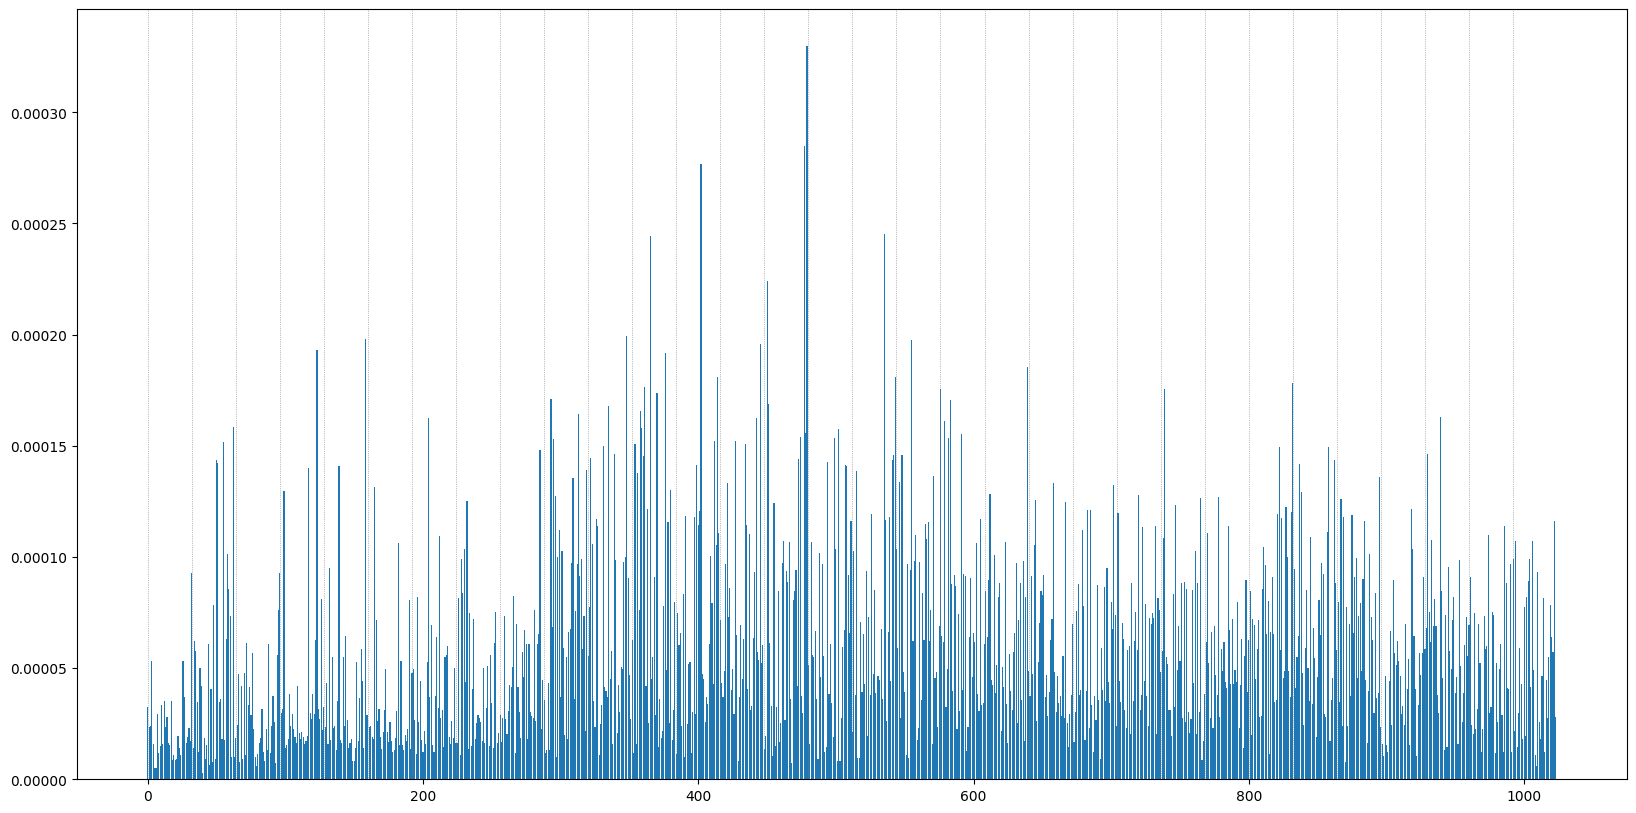

In [111]:
def visualize_label_mi(mi, label_idx, group_head_cnt: int, save_name: str = None):
    entry = mi[label_idx]
    n_heads = len(entry)
    print(label_names[label_idx])
    plt.figure(figsize=(20, 10))
    plt.bar(torch.arange(n_heads), entry)
    for partition_idx in range(0, n_heads, group_head_cnt):
        # grey dashed line with little width
        plt.axvline(partition_idx, color='grey', linestyle=':', linewidth=0.5)

visualize_label_mi(mi, 10, 32)

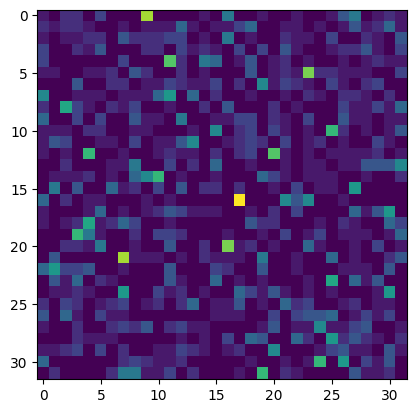

In [124]:
# verify if dependency-specific heads are centralized for different layers
head_hits = []
for start_idx in range(0, 1024, 32):
    head_hits.append([0] * 32)
    for label_idx in range(len(mi)):
        label_mis = mi[label_idx][start_idx: start_idx + 32]
        max_head_indices = label_mis.argsort(dim=-1, descending=True)[:1]
        for max_head_idx in max_head_indices:
            head_hits[-1][max_head_idx] += 1

head_hits = np.array(head_hits)
plt.imshow(head_hits)

In [8]:
def load_x_and_posterior_conditional(save_directory: str, transpose: bool):
    transpose_suffix = '_transpose' if transpose else ''
    with open(osp.join(save_directory, f'x_1{transpose_suffix}.pkl'), 'rb') as f_x, \
        open(osp.join(save_directory, f'label_conditional_1{transpose_suffix}.pkl'), 'rb') as f_label_conditional:
        x = pkl.load(f_x)
        label_conditional = pkl.load(f_label_conditional)
    
    return x, label_conditional


x, label_posterior = load_x_and_posterior_conditional(osp.expanduser('~/pretrained-models/kde/open_llama_7b'), False)
x_t, label_posterior_t = load_x_and_posterior_conditional(osp.expanduser('~/pretrained-models/kde/open_llama_7b'), True)

In [74]:
def visualize_posterior_distributions(x, label_posterior, head_idx, label_idx):
    head_posteriors = torch.stack(label_posterior[head_idx])
    print(f'head {head_idx:d}'.center(80, '='))
    print(head_posteriors)

# for head_idx in range(10):
#     visualize_posterior_distributions(x, label_posterior, head_idx, 0)
    # visualize_posterior_distributions(x_t, label_posterior_t, head_idx, 0)

In [35]:
with open(osp.join(osp.expanduser('~/pretrained-models/kde/open_llama_7b'), 'joint_label_1.pkl'), 'rb') as f, \
    open(osp.join(osp.expanduser('~/pretrained-models/kde/open_llama_7b'), 'joint_label_1_transpose.pkl'), 'rb') as f_t:
    joint = pkl.load(f)
    joint_t = pkl.load(f_t)

In [ ]:
# visualize_posterior_distributions(x, label_posterior, 0, 0)
# print((torch.stack(joint[head_idx]) == 0).any())
head_idx = 0
print(torch.stack(label_posterior[head_idx]).sum(dim=0))
print((marginal := sum(joint[head_idx])))
print((label_posterior[head_idx][0] / marginal).masked_fill)
# print((torch.stack(joint_t[head_idx]).sum(dim=0)))

In [ ]:
fig = plt.figure(figsize=(6, 8))
ax_up = fig.add_subplot(2, 1, 1)
ax_downs = fig.add_subplot(2, 2, 3), fig.add_subplot(2, 2, 4)
ax_up.set_title('1')
ax_downs[0].set_title('2'),ax_downs[1].set_title('3')
plt.tight_layout()

### Visualizing comparing original and transposed MI calculation

In [165]:
with open(osp.expanduser(f'~/pretrained-models/kde/open_llama_7b/mi_1.json'), 'r') as f_mi, \
    open(osp.expanduser(f'~/pretrained-models/kde/open_llama_7b/mi_1_transpose.json'), 'r') as f_mi_t:
    mi = json.load(f_mi)['binary_label_mi']
    mi_t = json.load(f_mi_t)['binary_label_mi']

print(len(mi), len(mi_t))
for label_idx in trange(len(mi)):
    with open(osp.expanduser(f'~/pretrained-models/kde/open_llama_7b/mi_intermediate_1/{label_idx:02d}/weighted_excess_surprises.pt'), 'rb') as f_wes, \
        open(osp.expanduser(f'~/pretrained-models/kde/open_llama_7b/mi_intermediate_1_transpose/{label_idx:02d}/weighted_excess_surprises.pt'), 'rb') as f_wes_t, \
        open(osp.expanduser(f'~/pretrained-models/kde/open_llama_7b/mi_intermediate_1/{label_idx:02d}/excess_surprises.pt'), 'rb') as f_es, \
        open(osp.expanduser(f'~/pretrained-models/kde/open_llama_7b/mi_intermediate_1_transpose/{label_idx:02d}/excess_surprises.pt'), 'rb') as f_es_t, \
        open(osp.expanduser(f'~/pretrained-models/kde/open_llama_7b/mi_intermediate_1/{label_idx:02d}/marginal_probabilities.pt'), 'rb') as f_marginal, \
        open(osp.expanduser(f'~/pretrained-models/kde/open_llama_7b/mi_intermediate_1_transpose/{label_idx:02d}/marginal_probabilities.pt'), 'rb') as f_marginal_t, \
        open(osp.expanduser(f'~/pretrained-models/kde/open_llama_7b/mi_intermediate_1/{label_idx:02d}/joint_probabilities.pt'), 'rb') as f_joint, \
        open(osp.expanduser(f'~/pretrained-models/kde/open_llama_7b/mi_intermediate_1_transpose/{label_idx:02d}/joint_probabilities.pt'), 'rb') as f_joint_t, \
        open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/x_1.pkl'), 'rb') as f_x, open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/x_1_transpose.pkl'), 'rb') as f_x_t:
        wes = torch.load(f_wes)
        wes_t = torch.load(f_wes_t)
        es = torch.load(f_es)
        es_t = torch.load(f_es_t)
        marginal = torch.load(f_marginal)
        marginal_t = torch.load(f_marginal_t)
        joint = torch.load(f_joint) 
        joint_t = torch.load(f_joint_t) 
        x = pkl.load(f_x)
        x_t = pkl.load(f_x_t)

        intersection_mask = torch.isin(x, x_t).cpu()
        intersection_mask_t = torch.isin(x_t, x).cpu()
        shared_x = x[intersection_mask].cpu()
        split_lines = shared_x[((shared_x % 0.5) - 0).abs() < 1e-6]
        # print(split_lines)

        high_mi_heads = [each[0] for each in sorted(enumerate(mi), reverse=True, key=lambda x: x[1])[:5]]
        high_mi_heads_t = [each[0] for each in sorted(enumerate(mi_t), reverse=True, key=lambda x: x[1])[:5]]
        print(f'label {label_idx}, {high_mi_heads =}, {high_mi_heads_t =}')
        for idx, (this_marginal, this_marginal_t, (this_joint_pos, this_joint_neg), (this_joint_pos_t, this_joint_neg_t),
            (this_es_pos, this_es_neg), (this_es_pos_t, this_es_neg_t), (this_wes_pos, this_wes_neg), (this_wes_pos_t, this_wes_neg_t),) in \
            enumerate(zip(marginal, marginal_t, joint, joint_t, es, es_t, wes, wes_t)):
            title_label = f'{idx:04d}'
            save_filename = f'{label_idx:02d}_{idx:04d}_'
            if idx in high_mi_heads:
                title_label += ' (high)'
                save_filename += 'o'
            if idx in high_mi_heads_t:
                title_label += ' (high t)'
                save_filename += 't'
            if idx not in high_mi_heads and idx not in high_mi_heads_t:
                continue
            fig = plt.figure(figsize=(40, 15))
            ax = fig.subplots(4, 2)
            ax[0][0].plot(shared_x, this_marginal[intersection_mask].cpu(), label='original')
            ax[0][0].plot(shared_x, this_marginal_t[intersection_mask_t].cpu(), label='transposed')
            ax[0][0].set_title(title_label + ' ' + 'marginal')

            ax[0][1].plot(shared_x, this_marginal[intersection_mask].cpu(), label='original')
            ax[0][1].plot(shared_x, this_marginal_t[intersection_mask_t].cpu(), label='transposed')
            ax[0][1].set_title(title_label + ' ' + 'marginal')

            ax[1][0].plot(shared_x, this_joint_pos[intersection_mask].cpu(), label='original')
            ax[1][0].plot(shared_x, this_joint_pos_t[intersection_mask_t].cpu(), label='transposed')
            ax[1][0].set_title(title_label + ' ' + 'joint')
            ax[1][1].plot(shared_x, this_joint_neg[intersection_mask].cpu(), label='original')
            ax[1][1].plot(shared_x, this_joint_neg_t[intersection_mask_t].cpu(), label='transposed')
            ax[1][1].set_title(title_label + ' ' + 'joint (neg)')

            ax[2][0].plot(shared_x, this_es_pos[intersection_mask].cpu(), label='original')
            ax[2][0].plot(shared_x, this_es_pos_t[intersection_mask_t].cpu(), label='transposed')
            ax[2][0].set_title(title_label + ' ' + 'excess surprise')
            ax[2][1].plot(shared_x, this_es_neg[intersection_mask].cpu(), label='original')
            ax[2][1].plot(shared_x, this_es_neg_t[intersection_mask_t].cpu(), label='transposed')
            ax[2][1].set_title(title_label + ' ' + 'excess surprise (neg)')

            ax[3][0].plot(shared_x, this_wes_pos[intersection_mask].cpu(), label='original')
            ax[3][0].plot(shared_x, this_wes_pos_t[intersection_mask_t].cpu(), label='transposed')
            ax[3][0].set_title(title_label + ' ' + 'weighted excess surprise')
            ax[3][1].plot(shared_x, this_wes_neg[intersection_mask].cpu(), label='original')
            ax[3][1].plot(shared_x, this_wes_neg_t[intersection_mask_t].cpu(), label='transposed')
            ax[3][1].set_title(title_label + ' ' + 'weighted excess surprise (neg)')
            for i in range(4):
                for j in range(2):
                    ax[i][j].legend(['original', 'transposed'])
                    # set vertical 
                    for split_point in split_lines:
                        ax[i][j].axvline(split_point.item(), color='grey', linestyle=':', linewidth=0.5)
            
            for i in range(2, 4):
                for j in range(2):
                    ax[i][j].axhline(y=0, color='red', linestyle=':', linewidth=0.5), ax[i][j].axhline(y=0, color='red', linestyle=':', linewidth=0.5)
            
            plt.savefig(osp.join('./visualization_results', save_filename + '.png'))
            plt.close(fig)

46 46


  0%|                                                                                                                                                                                    | 0/46 [00:00<?, ?it/s]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 0, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


  2%|███▋                                                                                                                                                                        | 1/46 [00:14<10:50, 14.46s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 1, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


  4%|███████▍                                                                                                                                                                    | 2/46 [00:37<14:09, 19.30s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 2, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


  7%|███████████▏                                                                                                                                                                | 3/46 [00:52<12:40, 17.68s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 3, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


  9%|██████████████▉                                                                                                                                                             | 4/46 [01:08<11:52, 16.97s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 4, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 11%|██████████████████▋                                                                                                                                                         | 5/46 [01:23<10:57, 16.03s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 5, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 13%|██████████████████████▍                                                                                                                                                     | 6/46 [01:38<10:29, 15.75s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 6, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 15%|██████████████████████████▏                                                                                                                                                 | 7/46 [01:52<09:58, 15.34s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 7, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 17%|█████████████████████████████▉                                                                                                                                              | 8/46 [02:08<09:45, 15.41s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 8, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 20%|█████████████████████████████████▋                                                                                                                                          | 9/46 [02:22<09:15, 15.01s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 9, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 22%|█████████████████████████████████████▏                                                                                                                                     | 10/46 [02:36<08:49, 14.71s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 10, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 24%|████████████████████████████████████████▉                                                                                                                                  | 11/46 [02:52<08:47, 15.07s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 11, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 26%|████████████████████████████████████████████▌                                                                                                                              | 12/46 [03:07<08:29, 14.98s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 12, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 28%|████████████████████████████████████████████████▎                                                                                                                          | 13/46 [03:21<08:07, 14.77s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 13, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 30%|████████████████████████████████████████████████████                                                                                                                       | 14/46 [03:38<08:09, 15.30s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 14, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 15/46 [03:52<07:47, 15.07s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 15, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 35%|███████████████████████████████████████████████████████████▍                                                                                                               | 16/46 [04:07<07:27, 14.93s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 16, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 37%|███████████████████████████████████████████████████████████████▏                                                                                                           | 17/46 [04:21<07:08, 14.77s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 17, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 39%|██████████████████████████████████████████████████████████████████▉                                                                                                        | 18/46 [04:38<07:14, 15.53s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 18, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 41%|██████████████████████████████████████████████████████████████████████▋                                                                                                    | 19/46 [04:53<06:49, 15.16s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 19, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 43%|██████████████████████████████████████████████████████████████████████████▎                                                                                                | 20/46 [05:07<06:27, 14.92s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 20, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                             | 21/46 [05:21<06:08, 14.73s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 21, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 22/46 [05:39<06:13, 15.54s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 22, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 23/46 [05:53<05:50, 15.22s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 23, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 24/46 [06:08<05:28, 14.95s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 24, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 54%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 25/46 [06:22<05:09, 14.73s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 25, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 26/46 [06:36<04:53, 14.67s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 26, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 27/46 [06:55<04:59, 15.75s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 27, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 28/46 [07:10<04:39, 15.53s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 28, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 29/46 [07:24<04:18, 15.19s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 29, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 30/46 [07:39<04:00, 15.02s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 30, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 31/46 [07:54<03:45, 15.00s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 31, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 32/46 [08:08<03:29, 14.94s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 32, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 33/46 [08:23<03:12, 14.77s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 33, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 34/46 [08:42<03:12, 16.04s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 34, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 35/46 [08:56<02:51, 15.56s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 35, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 36/46 [09:10<02:31, 15.16s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 36, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 37/46 [09:25<02:14, 14.92s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 37, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 38/46 [09:41<02:01, 15.20s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 38, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 39/46 [09:55<01:45, 15.08s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 39, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 40/46 [10:12<01:32, 15.40s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 40, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 41/46 [10:32<01:24, 16.84s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 41, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 42/46 [10:46<01:04, 16.06s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 42, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 43/46 [11:01<00:47, 15.68s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 43, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 44/46 [11:15<00:30, 15.30s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 44, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 45/46 [11:30<00:15, 15.00s/it]

tensor([-5.0000, -4.5000, -3.0000, -2.5000, -2.0000, -1.0000, -0.5000,  0.0000,
         0.5000,  1.0000,  2.0000,  3.0000,  4.0000])
label 45, high_mi_heads =[45, 2, 19, 4, 8], high_mi_heads_t =[45, 0, 5, 4, 1]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [11:44<00:00, 15.31s/it]


### Analyzing Inference Results

In [208]:
inference_mode = 'transpose'
threshold = 0.5 if inference_mode == 'transpose' else 0.2
inference_results_t = torch.load(osp.expanduser(f"~/pretrained-models/kde/open_llama_7b/inference_results/{inference_mode}_{threshold}.pt"))

In [207]:
def bar_emphasize_compare(values: Tensor, idx, predicted_values, save_pth: str = None):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.subplots(1, 2, sharey='all')
    colors = ['b'] * len(values)
    colors[values.argmax().item()] = 'r'
    ax[0].bar(torch.arange(len(values)), values, color=colors)
    # ax[0].axvline(idx, color='r', linestyle=':', linewidth=0.5)
    ax[0].axvline(idx, color='r', linestyle=':', linewidth=0.5)
    ax[0].set_title('ground truth probabilities')
    predicted_max_idx = predicted_values.argmax()
    ax[1].bar(torch.arange(len(values)), predicted_values)
    ax[1].bar(predicted_max_idx, predicted_values[predicted_max_idx], color='r')
    ax[1].set_title('predicted probabilities')
    if save_pth is None:
        plt.show()
    else:
        plt.savefig(save_pth)
    plt.close(fig)
    
visualization_save_dir = f'inference_results/visualization/{inference_mode}'
os.makedirs(visualization_save_dir, exist_ok=True)
for sample_idx, (arcs, labels, predicted, probab_labels) in \
    enumerate(zip(inference_results_t['arcs'], inference_results_t['labels'], inference_results_t['results'], inference_results_t['probab_labels'])):
    arcs = arcs.tolist()
    predicted = predicted.tolist()
    # print(arcs)
    # print(labels)
    # print(probab_labels.shape)
    n_corrects, n_errors = 0, 0
    for token_idx, head_idx in enumerate(pbar := tqdm(arcs, )):
        if head_idx == -1: continue
        label = labels[token_idx]
        predicted_head_idx = predicted[token_idx]
        if predicted_head_idx != head_idx:
            n_errors += 1
            gt_probabs = probab_labels[token_idx][head_idx]
            predicted_probabs = probab_labels[token_idx][predicted_head_idx]
            bar_emphasize_compare(gt_probabs, label, predicted_probabs, osp.join(visualization_save_dir, f'{sample_idx:04d}_{token_idx:03d}.png'))
        else:
            n_corrects += 1
        pbar.set_description(f"{n_corrects} / {n_corrects + n_errors}")
    break

41 / 118: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:43<00:00,  2.71it/s]


In [2]:
inference_results = torch.load(osp.expanduser(f"~/pretrained-models/kde/open_llama_7b/inference_results/original_0.2.pt"), map_location='cpu')
inference_results_t = torch.load(osp.expanduser(f"~/pretrained-models/kde/open_llama_7b/inference_results/transpose_0.5.pt"), map_location='cpu')

  0%|                                                                                                                                                                                   | 0/119 [00:00<?, ?it/s]

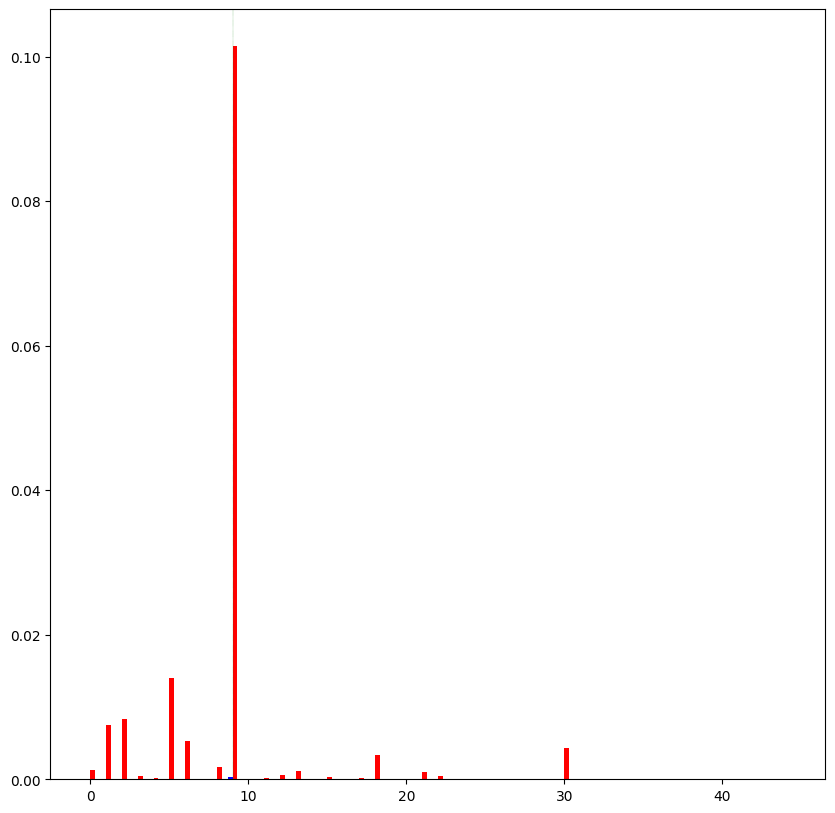

  2%|██▊                                                                                                                                                                        | 2/119 [00:00<00:30,  3.80it/s]

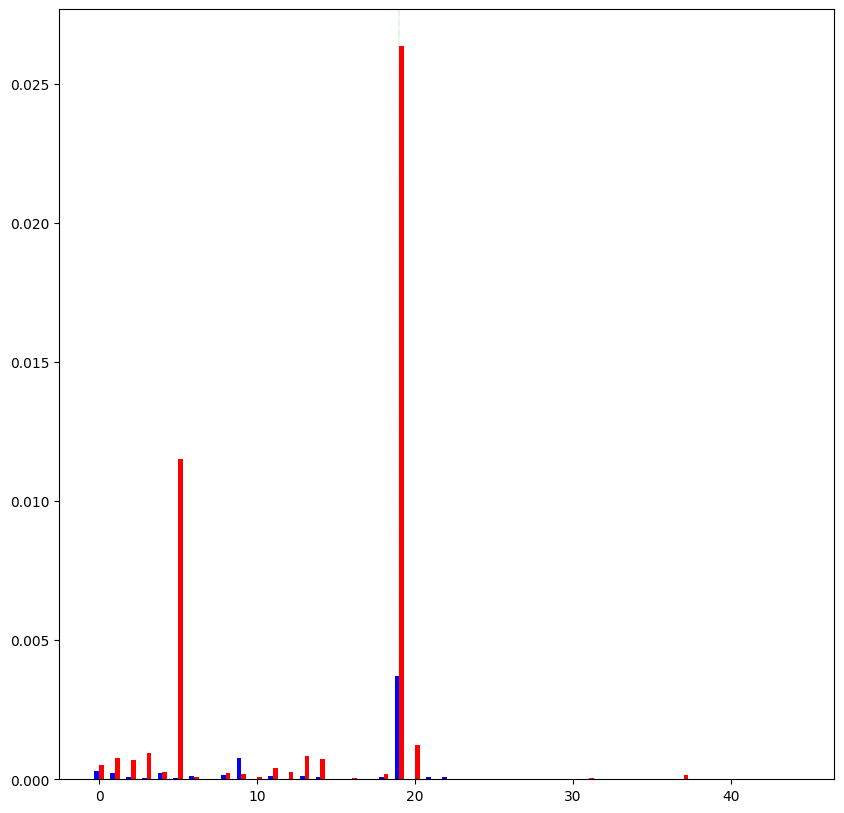

  3%|█████▋                                                                                                                                                                     | 4/119 [00:00<00:21,  5.41it/s]

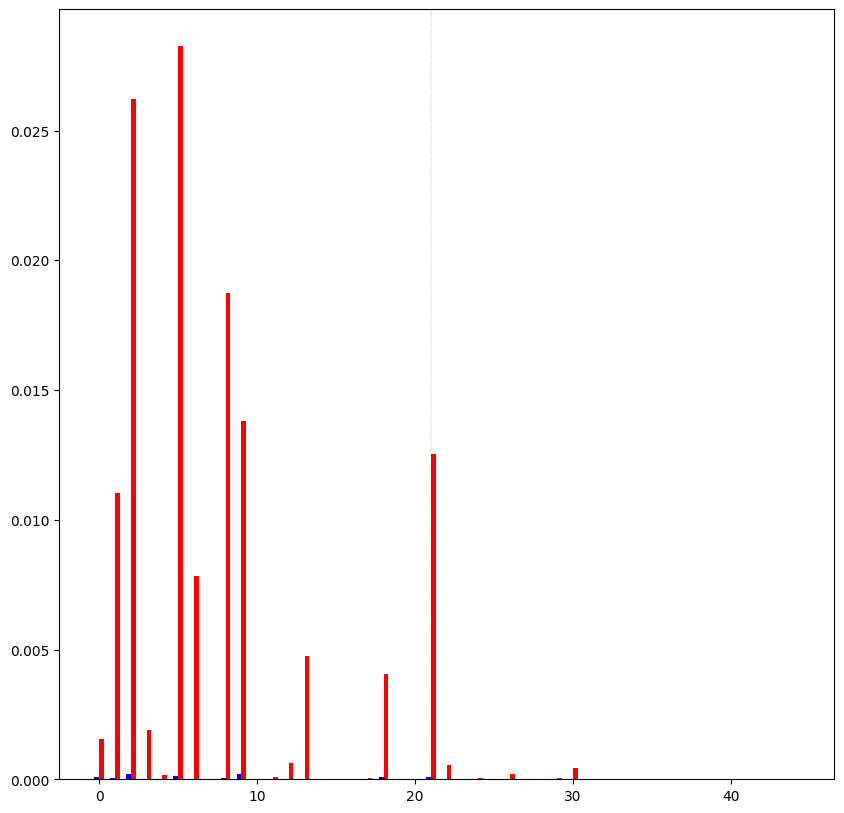

  4%|███████▏                                                                                                                                                                   | 5/119 [00:01<00:22,  4.97it/s]

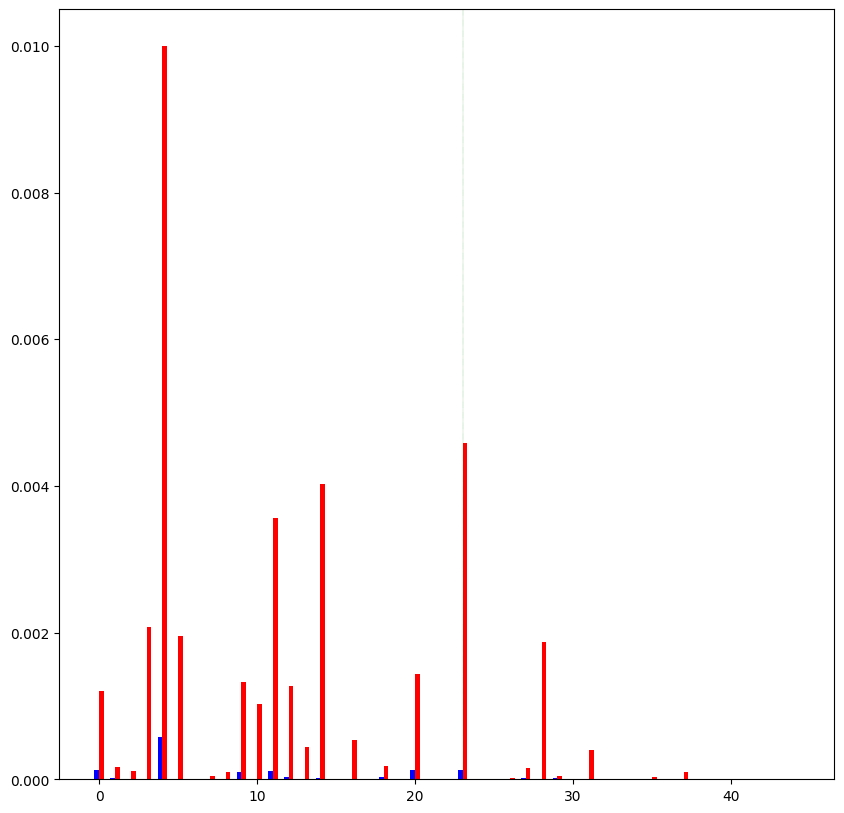

  5%|████████▌                                                                                                                                                                  | 6/119 [00:01<00:24,  4.69it/s]

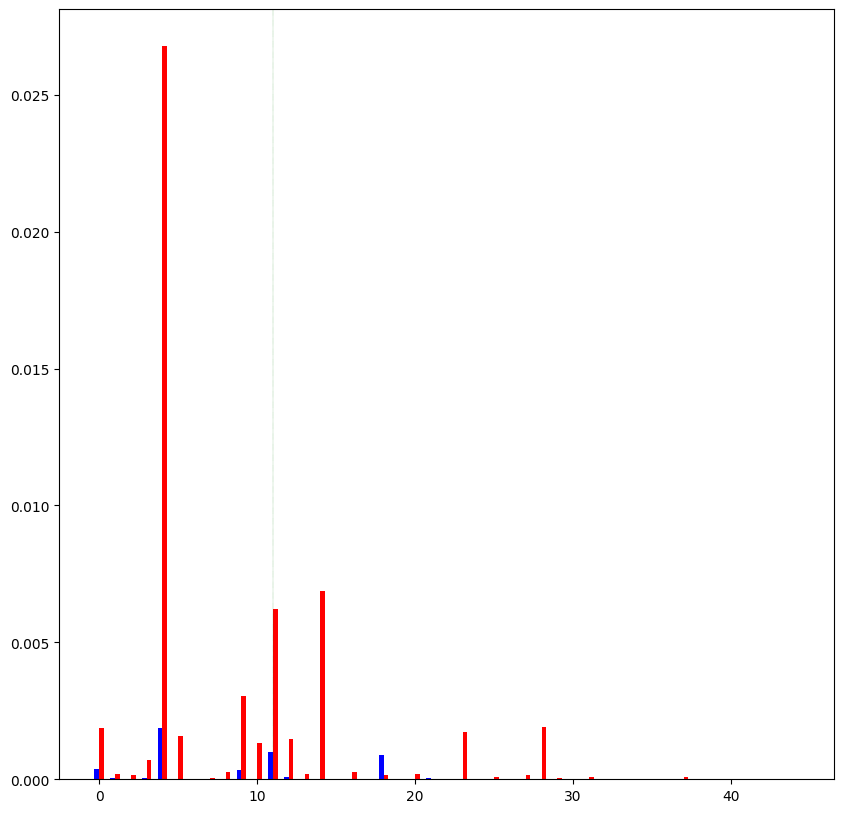

  7%|███████████▍                                                                                                                                                               | 8/119 [00:01<00:18,  5.86it/s]

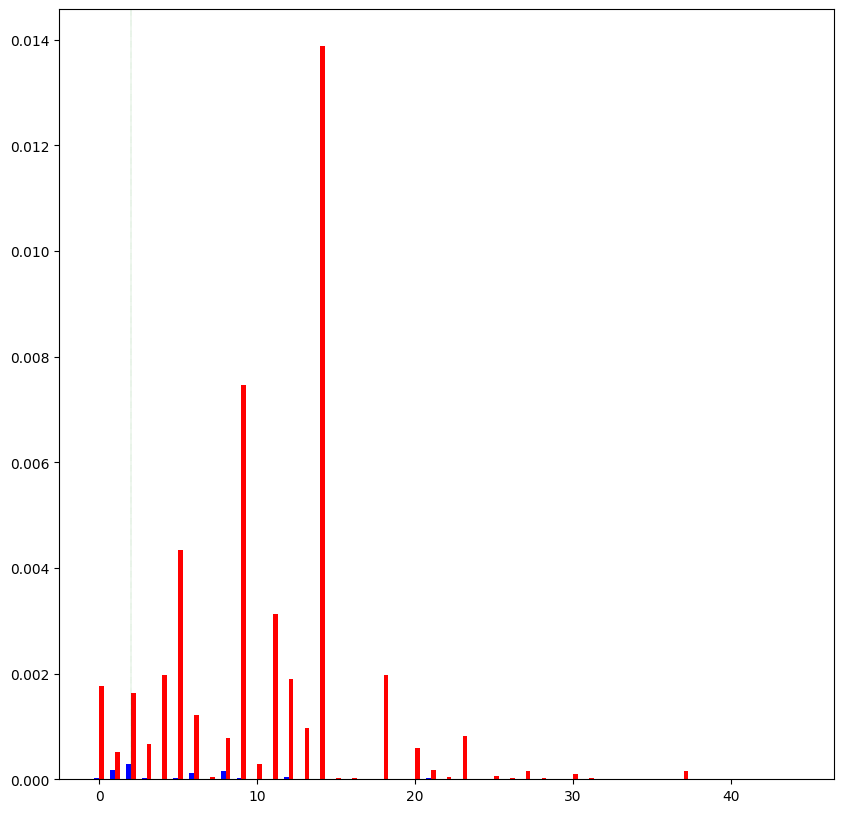

  8%|██████████████▎                                                                                                                                                           | 10/119 [00:01<00:16,  6.52it/s]

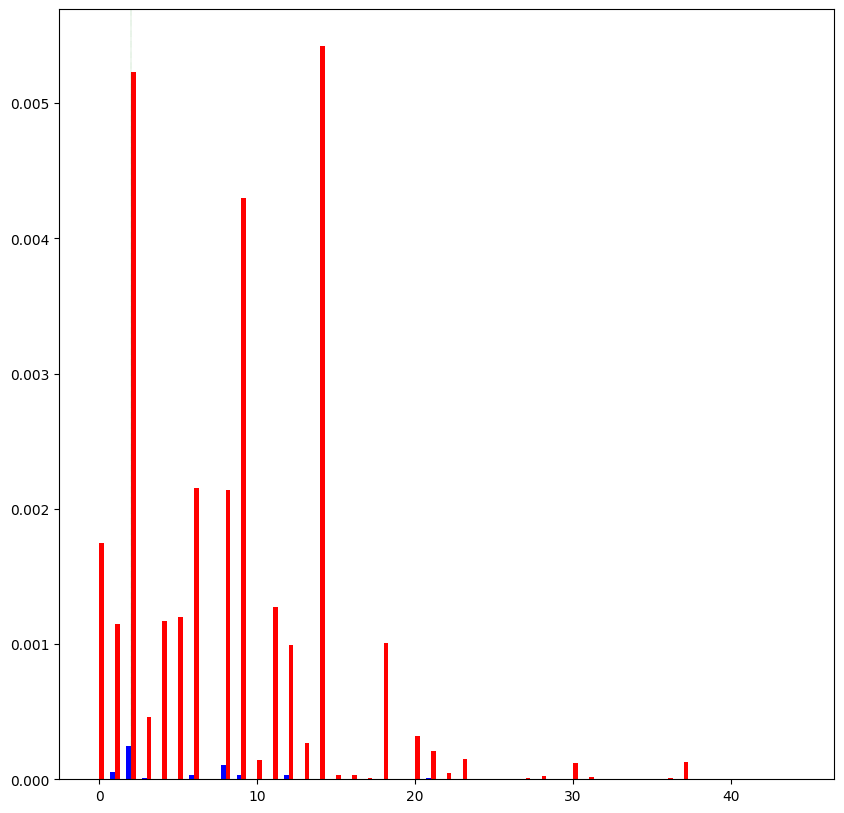

  9%|███████████████▋                                                                                                                                                          | 11/119 [00:02<00:18,  5.77it/s]

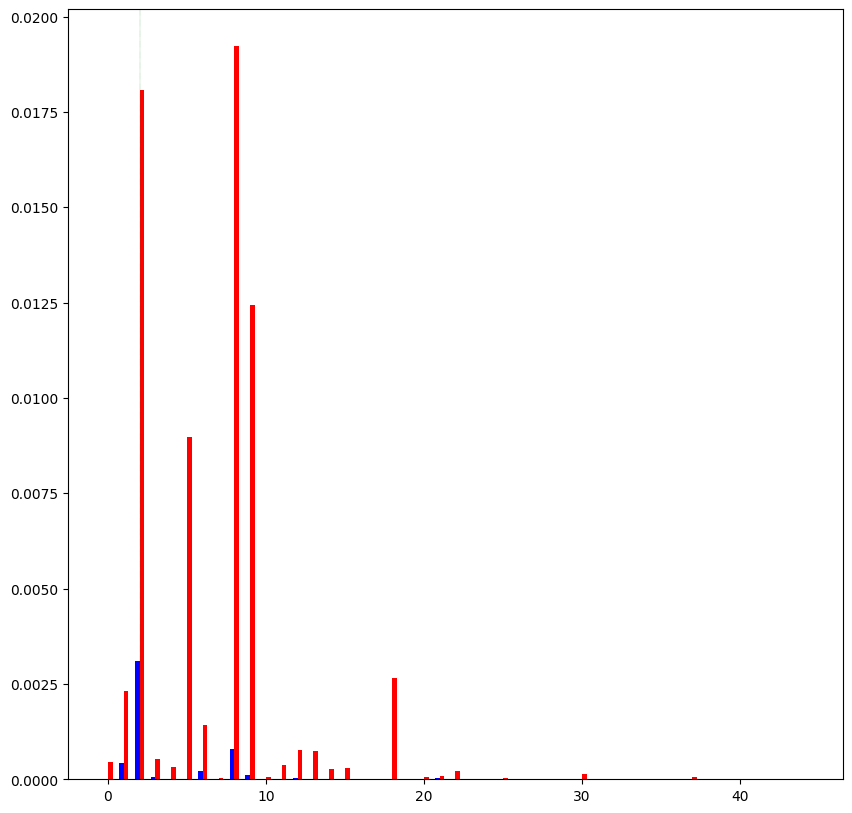

 10%|█████████████████▏                                                                                                                                                        | 12/119 [00:02<00:20,  5.20it/s]

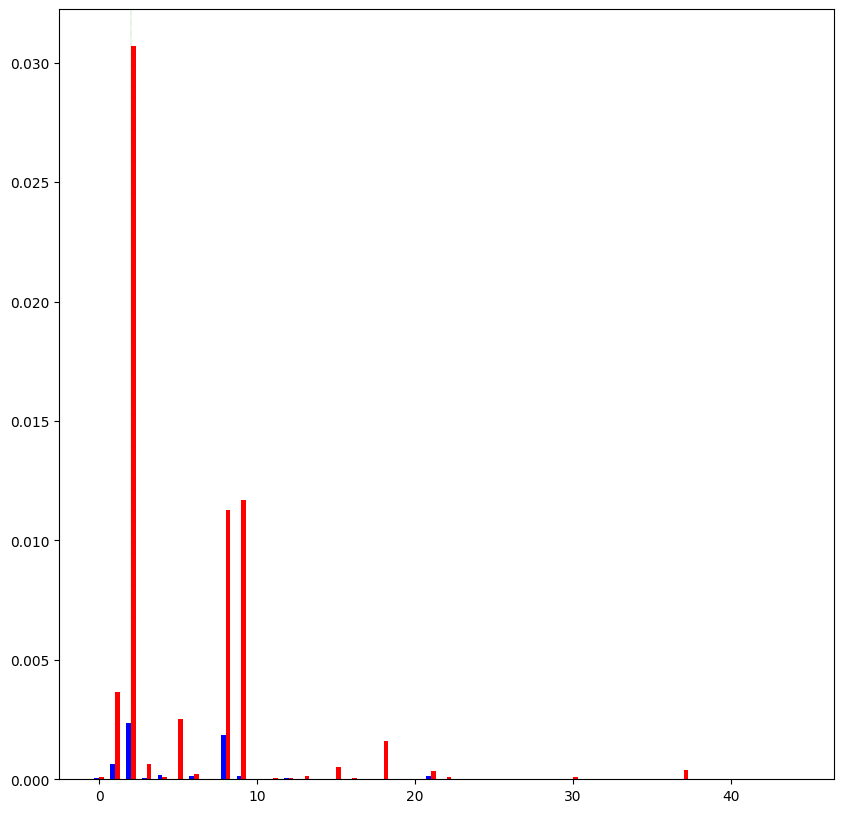

 11%|██████████████████▌                                                                                                                                                       | 13/119 [00:02<00:21,  4.87it/s]

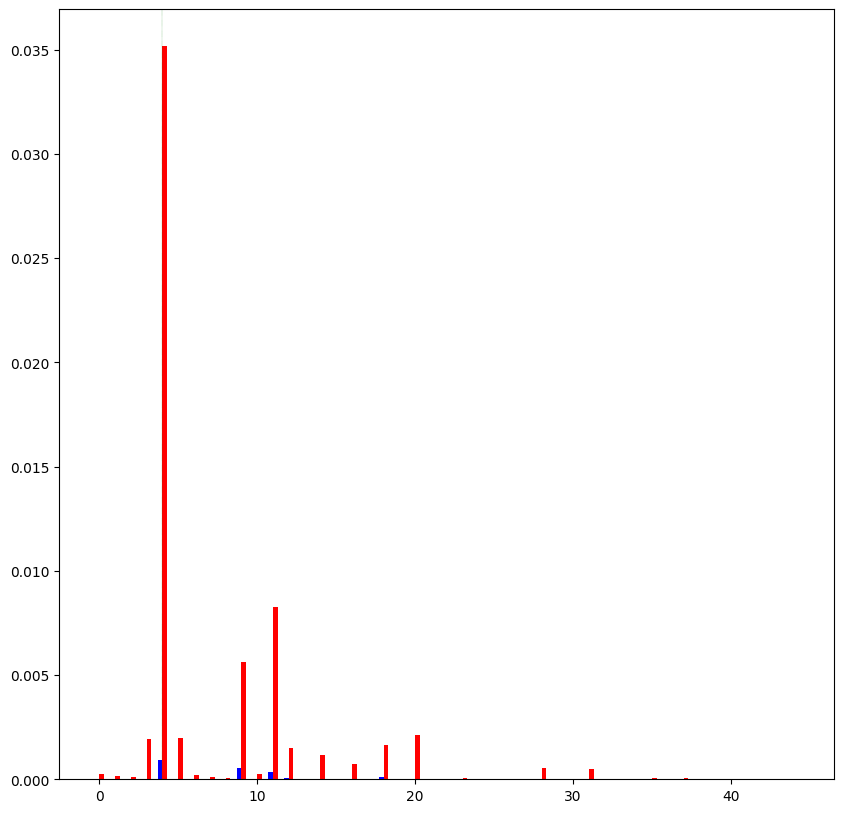

 12%|████████████████████                                                                                                                                                      | 14/119 [00:02<00:22,  4.59it/s]

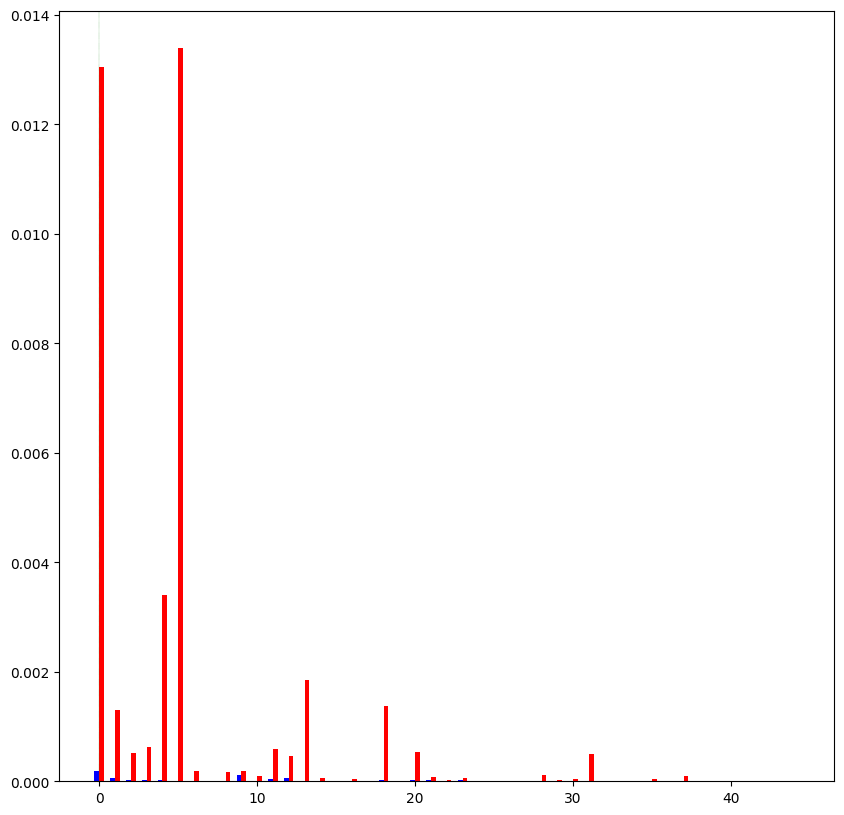

 13%|█████████████████████▍                                                                                                                                                    | 15/119 [00:03<00:23,  4.38it/s]

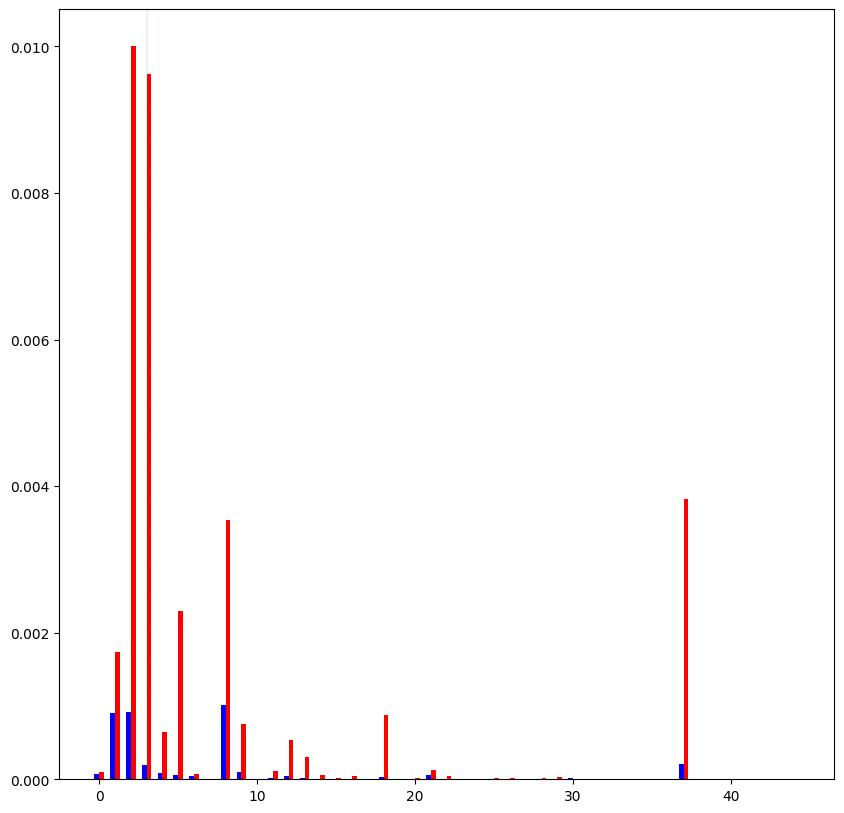

 13%|██████████████████████▊                                                                                                                                                   | 16/119 [00:03<00:23,  4.32it/s]

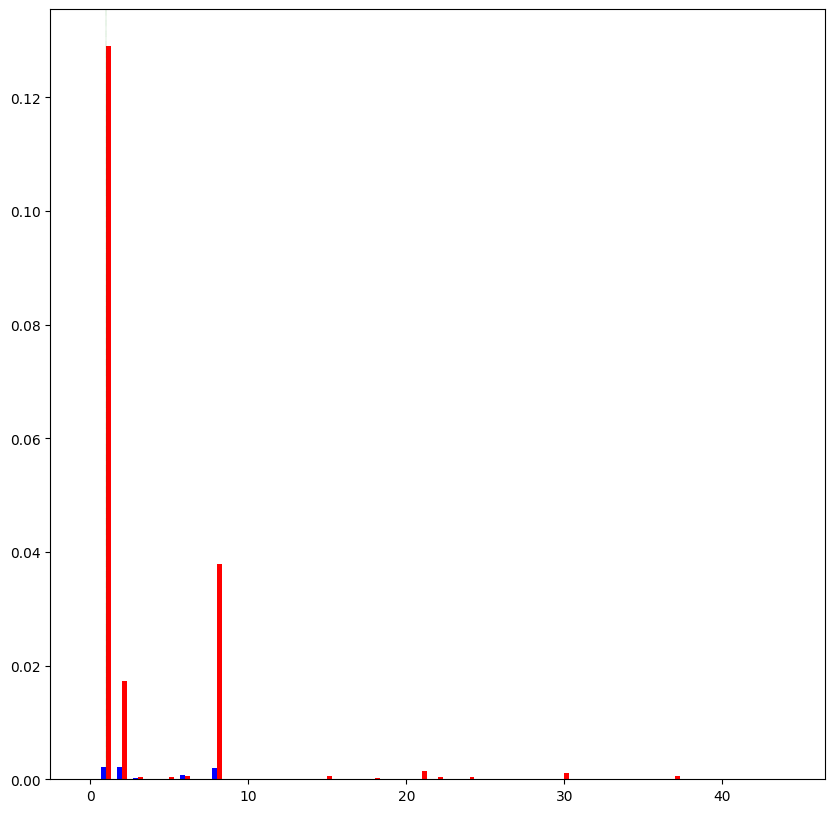

 16%|███████████████████████████▏                                                                                                                                              | 19/119 [00:03<00:14,  6.69it/s]

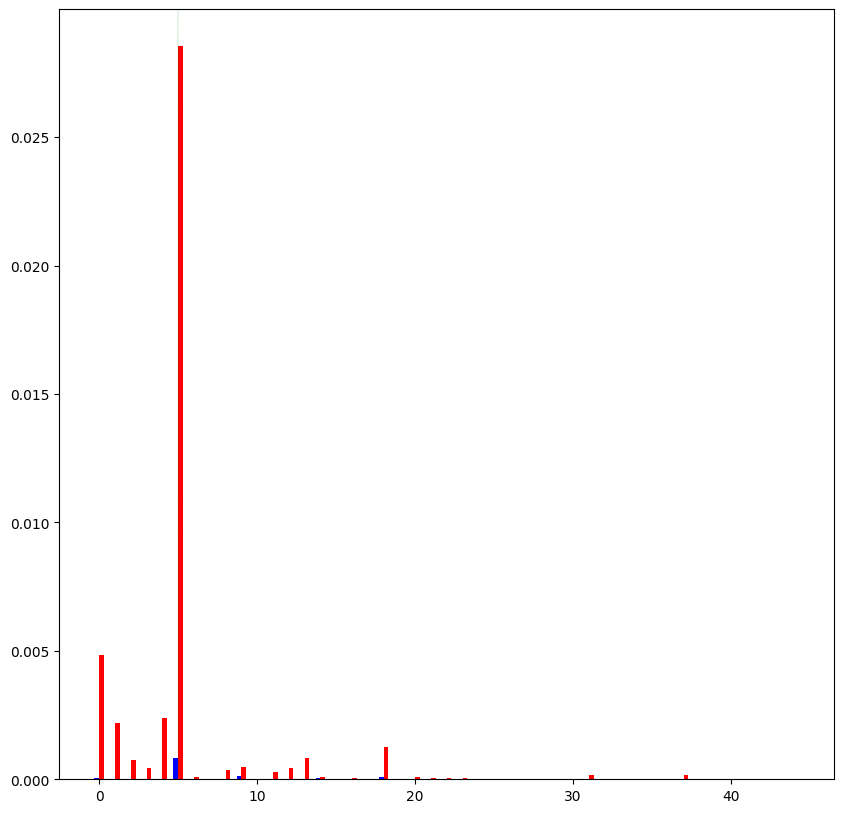

 22%|█████████████████████████████████████▏                                                                                                                                    | 26/119 [00:03<00:07, 13.24it/s]

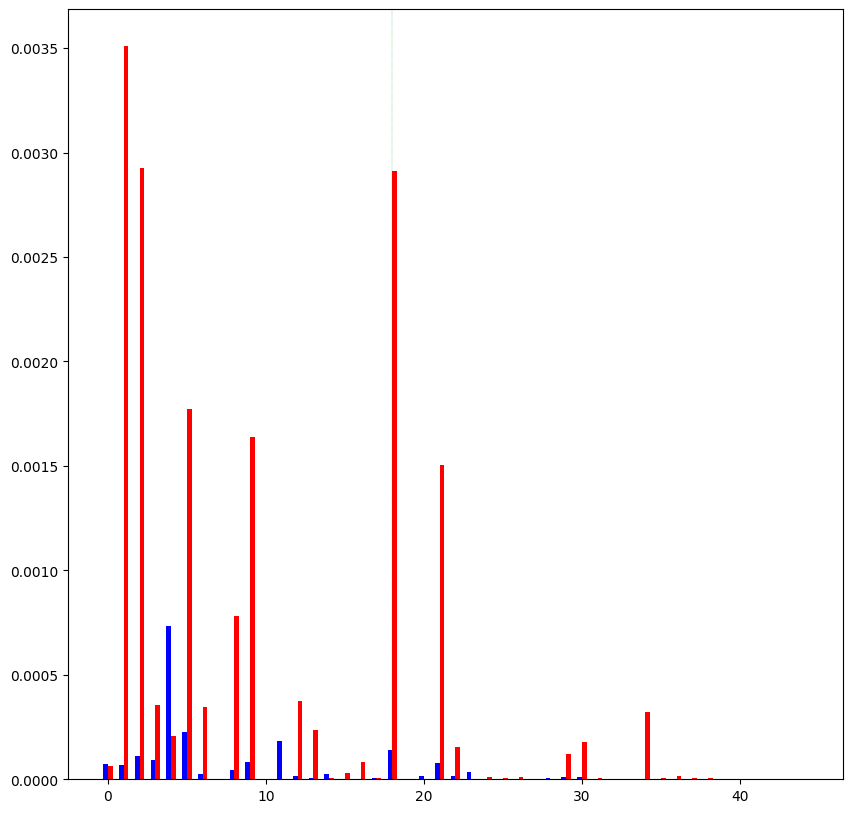

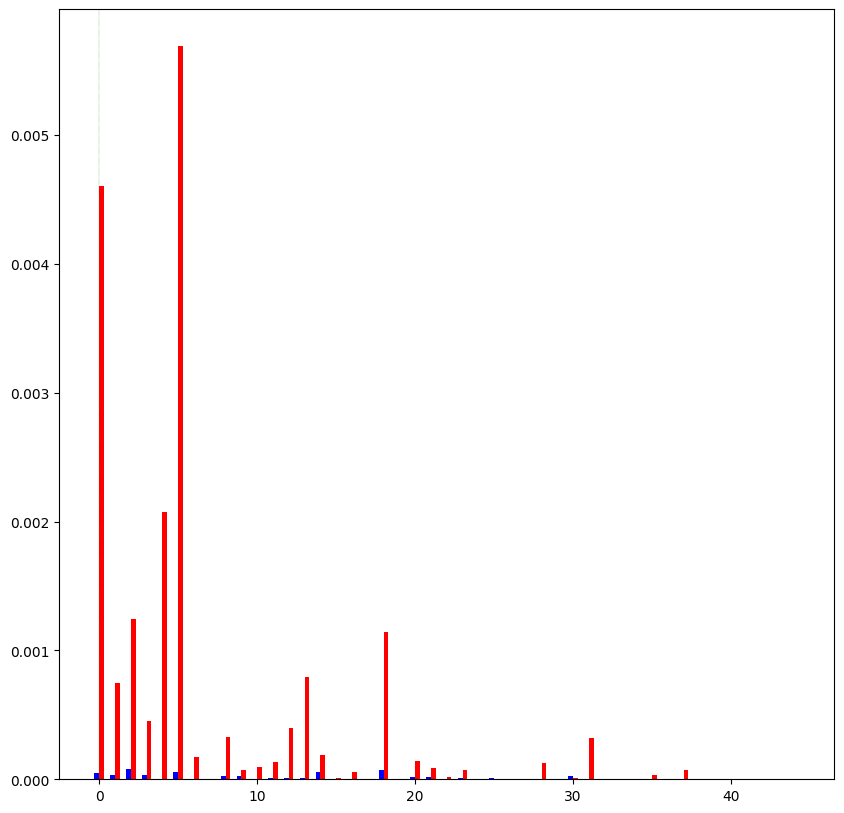

 24%|████████████████████████████████████████                                                                                                                                  | 28/119 [00:04<00:10,  9.01it/s]

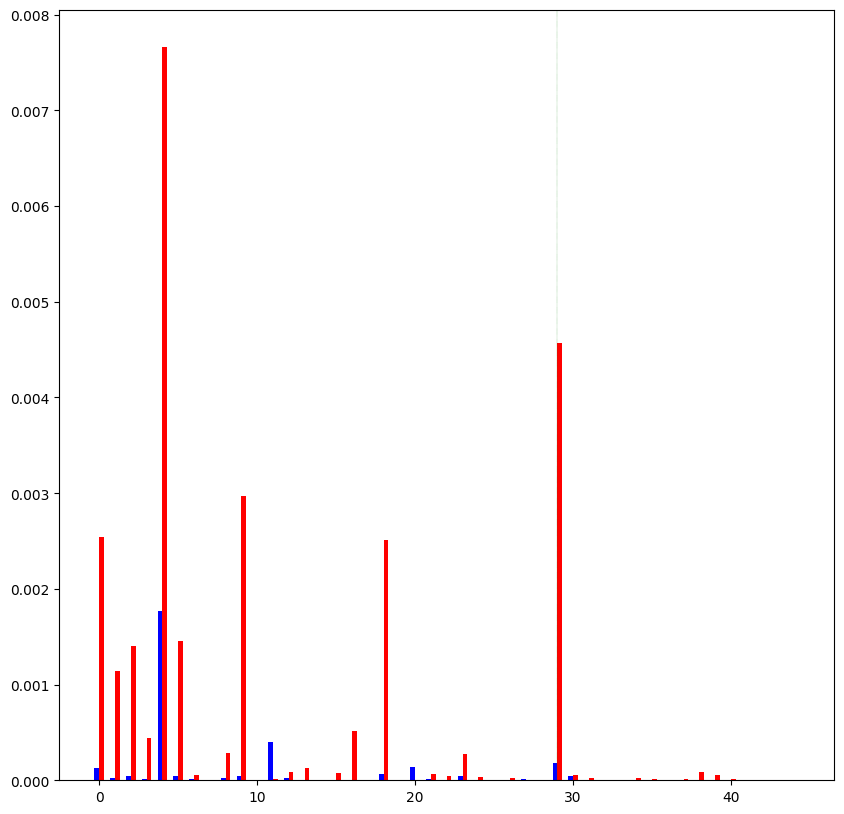

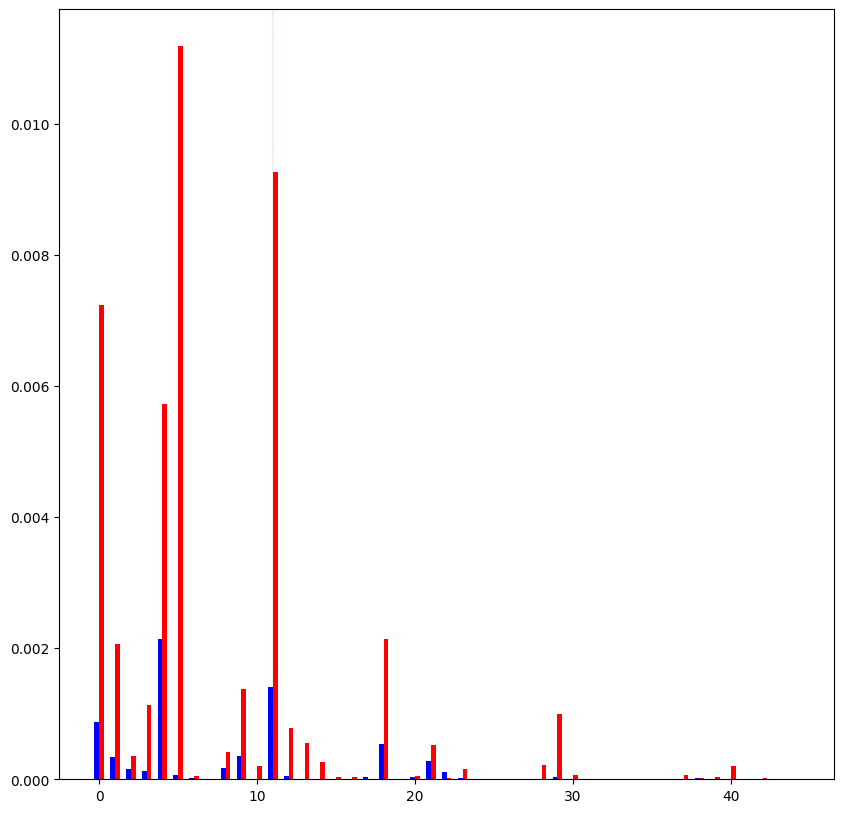

 25%|██████████████████████████████████████████▊                                                                                                                               | 30/119 [00:04<00:12,  7.04it/s]

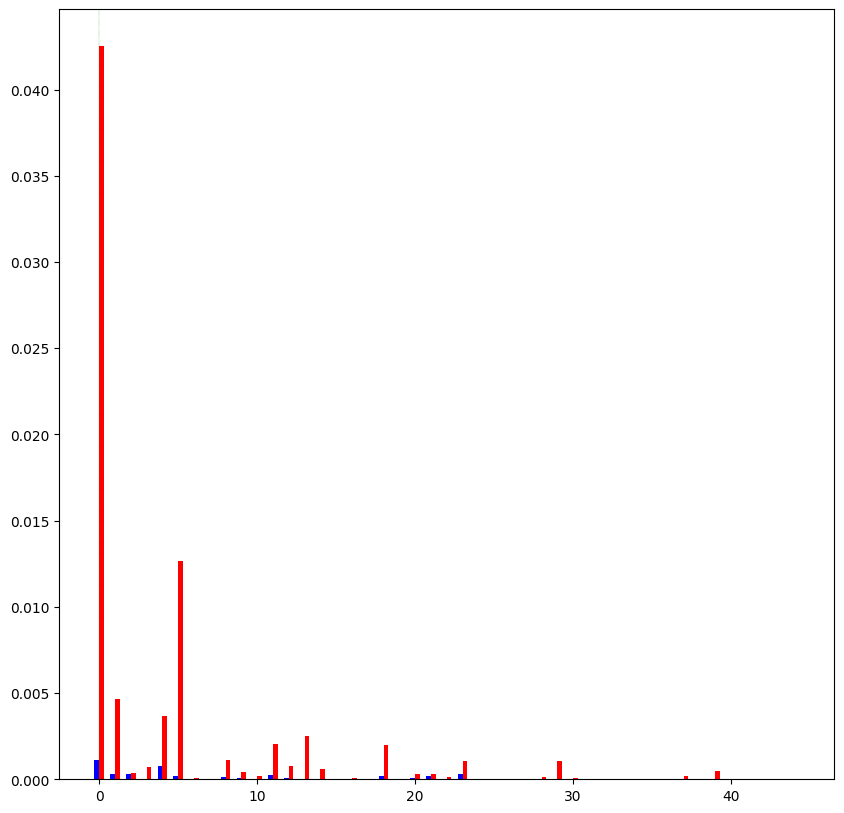

 26%|████████████████████████████████████████████▎                                                                                                                             | 31/119 [00:04<00:13,  6.32it/s]

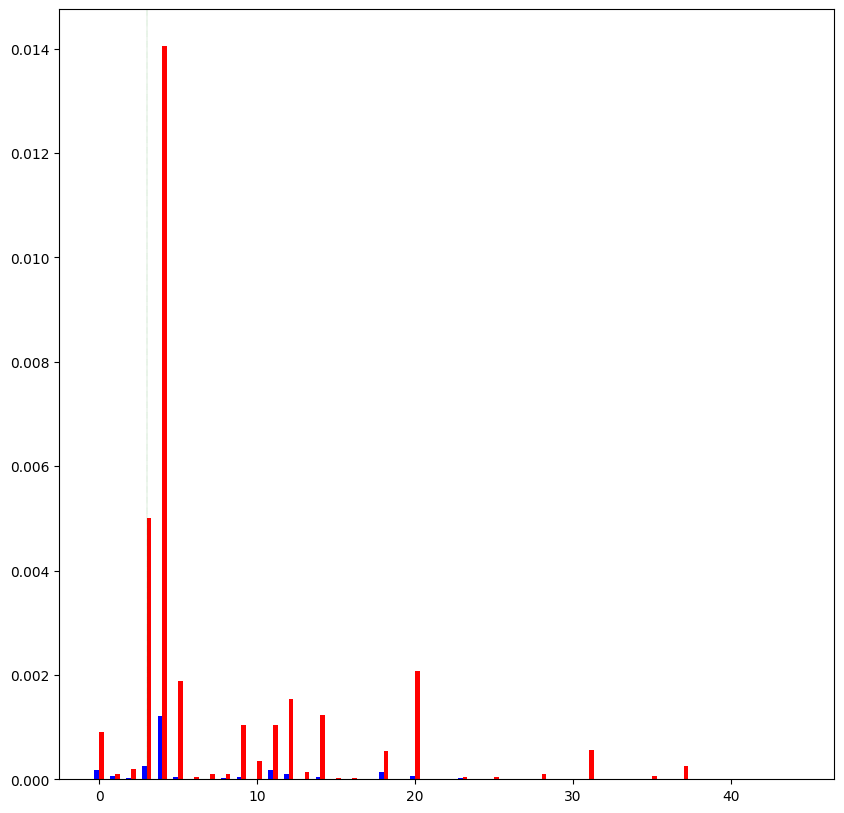

 28%|███████████████████████████████████████████████▏                                                                                                                          | 33/119 [00:05<00:12,  6.74it/s]

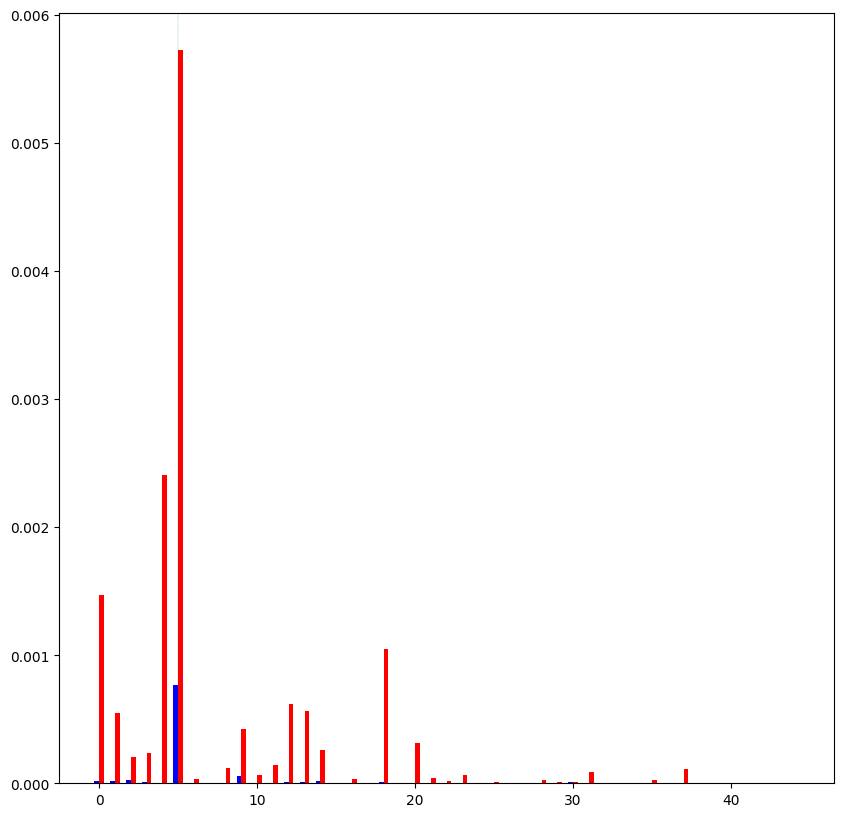

 29%|████████████████████████████████████████████████▌                                                                                                                         | 34/119 [00:05<00:14,  5.84it/s]

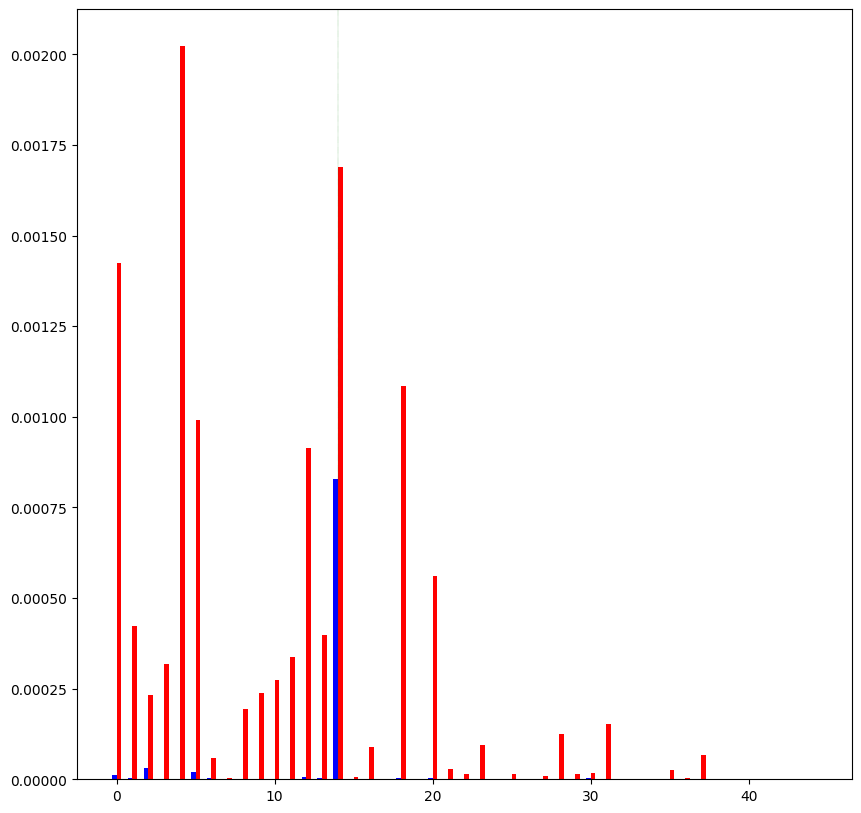

 29%|██████████████████████████████████████████████████                                                                                                                        | 35/119 [00:05<00:15,  5.28it/s]

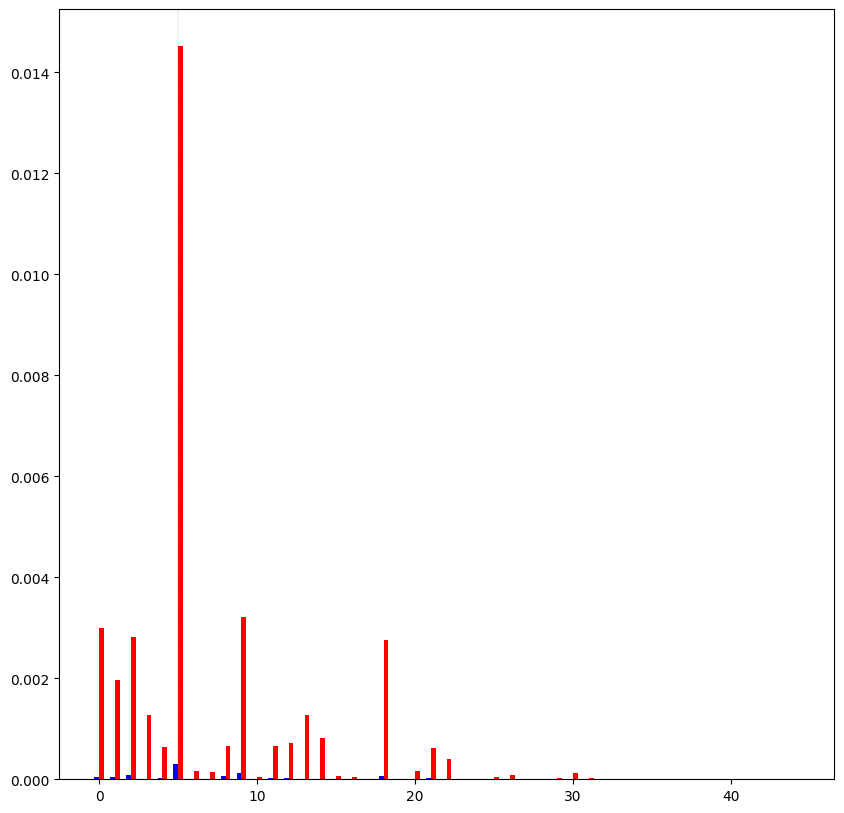

 30%|███████████████████████████████████████████████████▍                                                                                                                      | 36/119 [00:06<00:16,  4.92it/s]

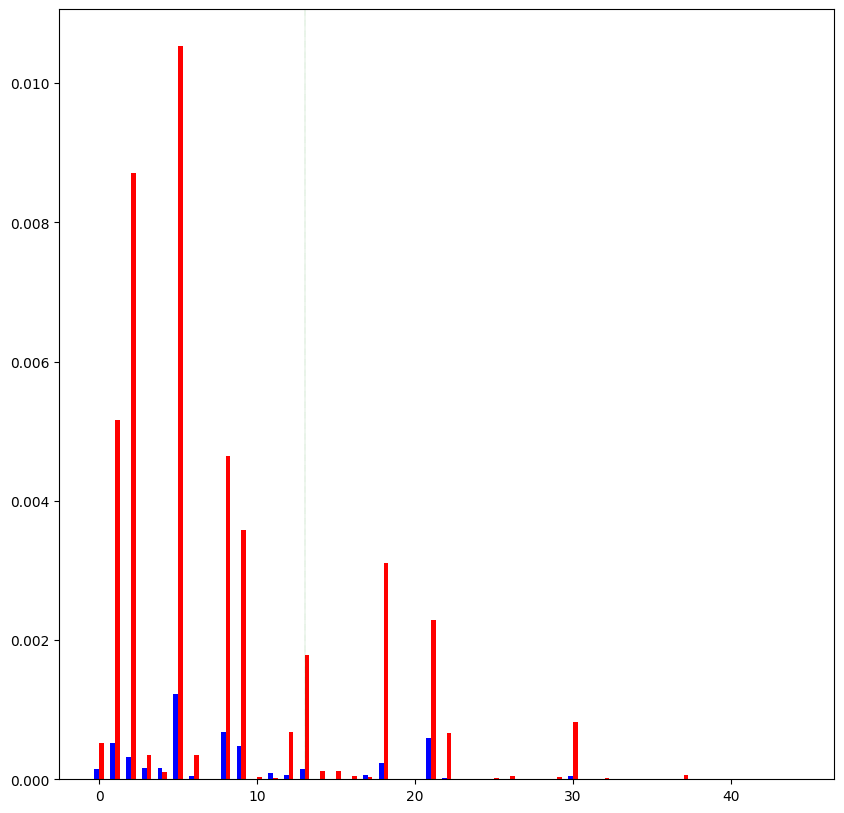

 31%|████████████████████████████████████████████████████▊                                                                                                                     | 37/119 [00:06<00:17,  4.72it/s]

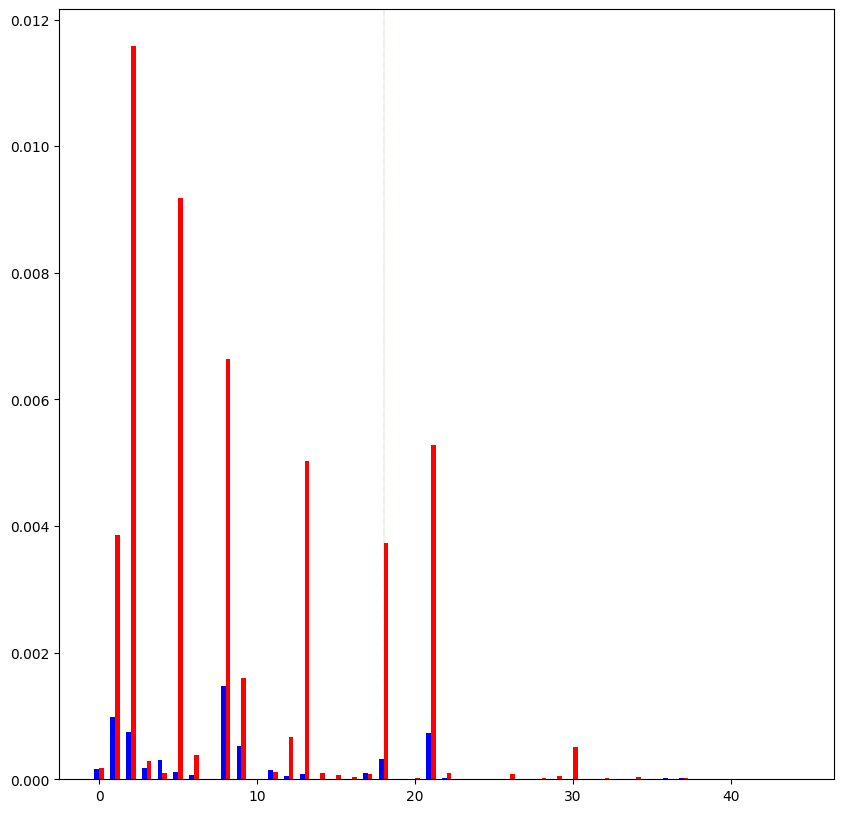

 32%|██████████████████████████████████████████████████████▎                                                                                                                   | 38/119 [00:06<00:17,  4.53it/s]

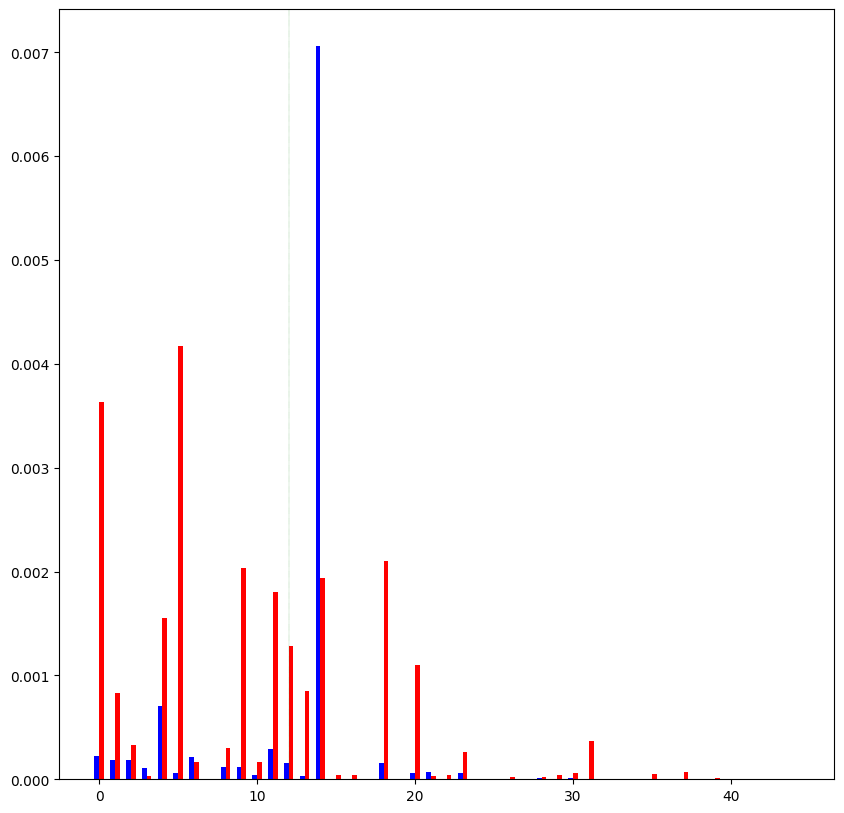

 33%|███████████████████████████████████████████████████████▋                                                                                                                  | 39/119 [00:06<00:18,  4.38it/s]

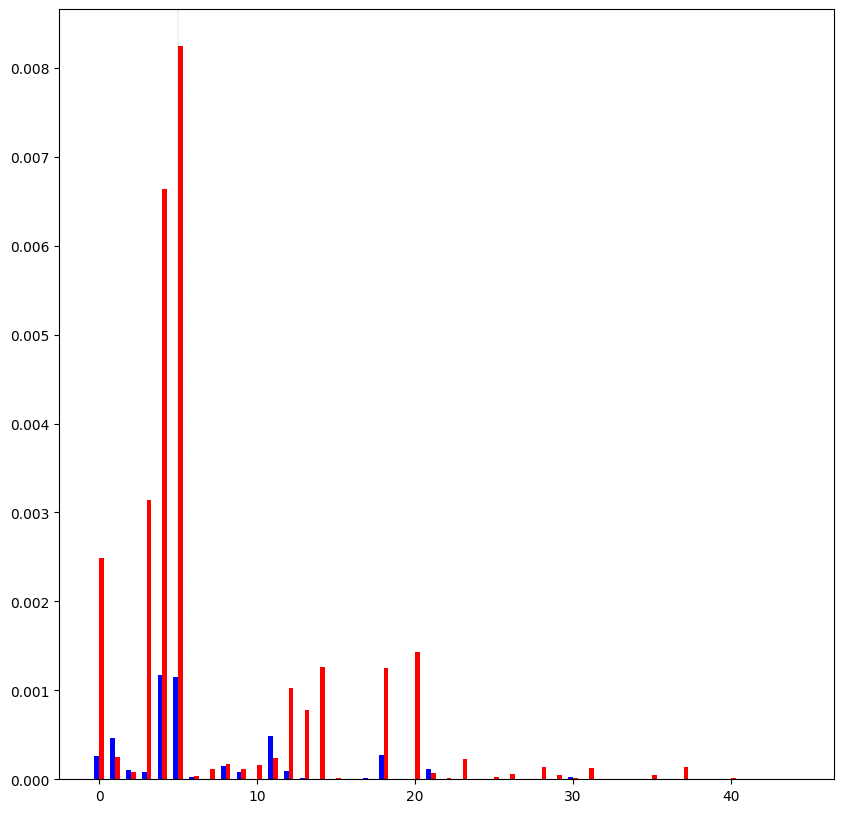

 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 40/119 [00:07<00:18,  4.21it/s]

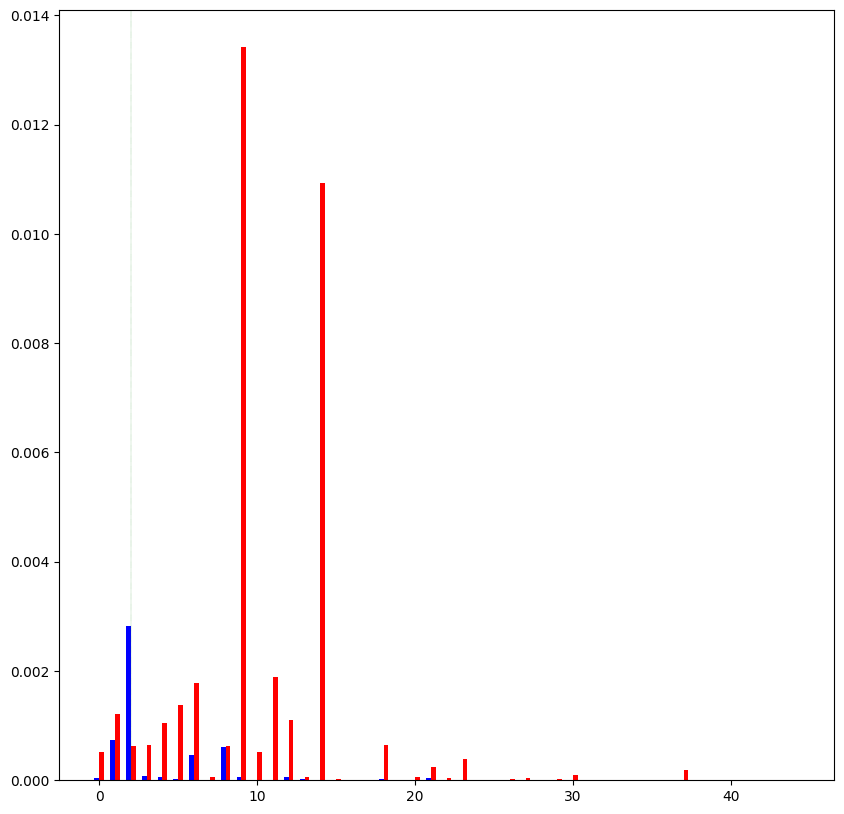

 34%|██████████████████████████████████████████████████████████▌                                                                                                               | 41/119 [00:08<00:35,  2.18it/s]

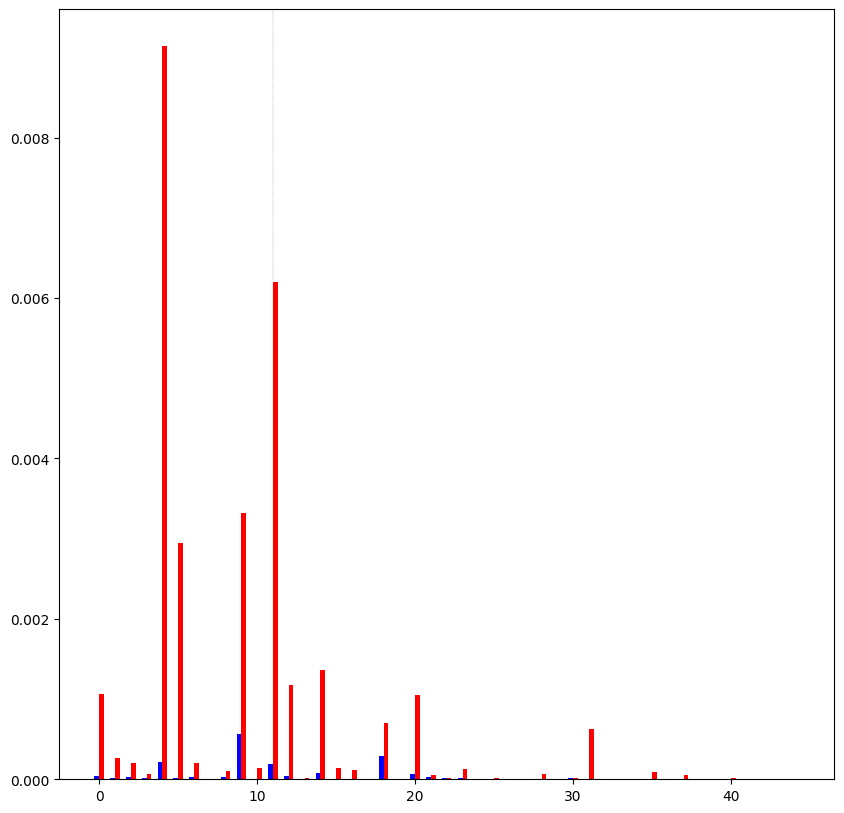

 36%|█████████████████████████████████████████████████████████████▍                                                                                                            | 43/119 [00:08<00:23,  3.26it/s]

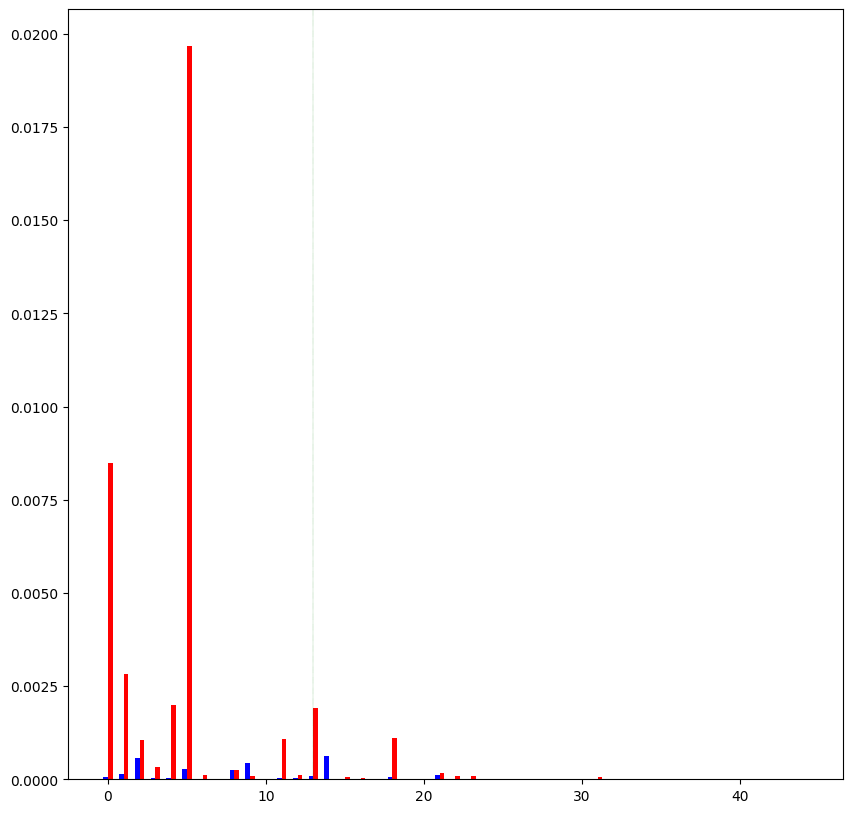

 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 44/119 [00:08<00:21,  3.41it/s]

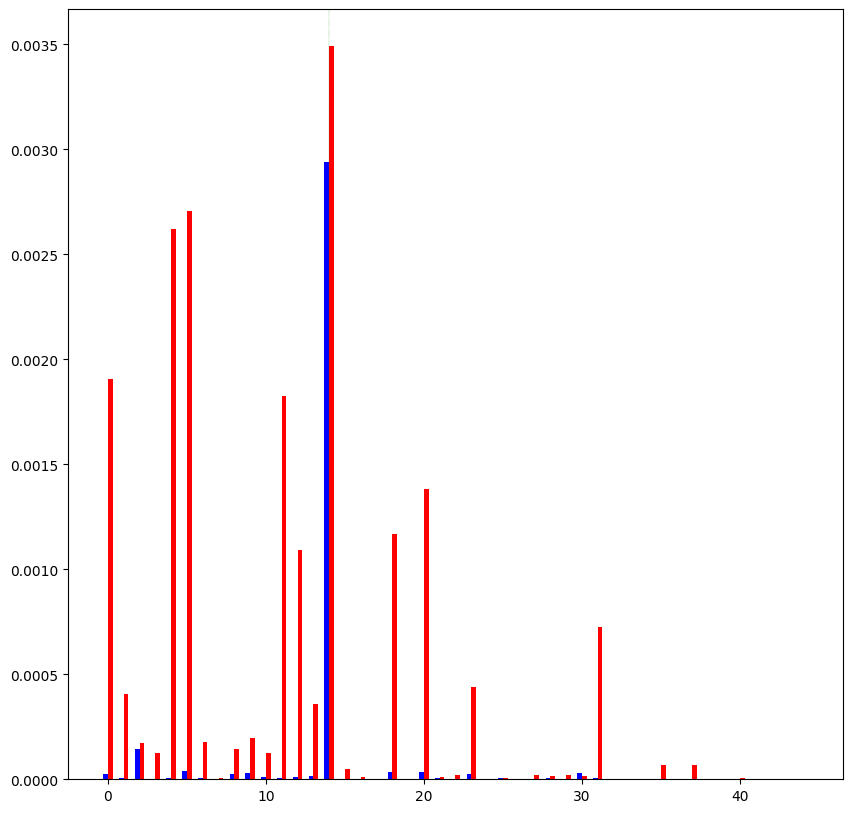

 38%|████████████████████████████████████████████████████████████████▎                                                                                                         | 45/119 [00:08<00:20,  3.57it/s]

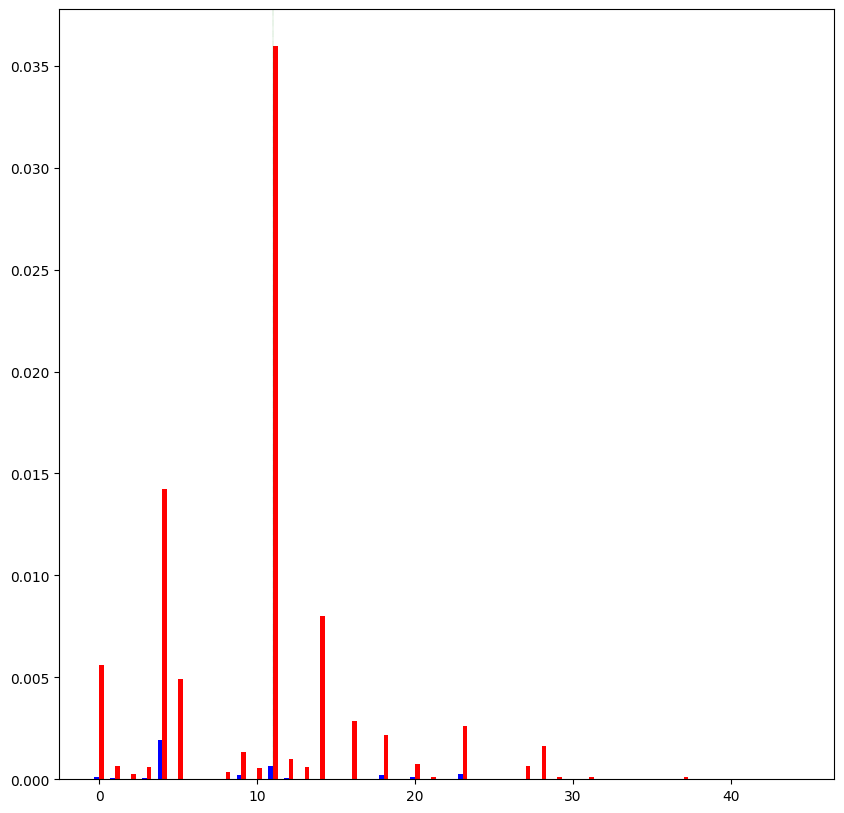

 39%|███████████████████████████████████████████████████████████████████▏                                                                                                      | 47/119 [00:09<00:15,  4.68it/s]

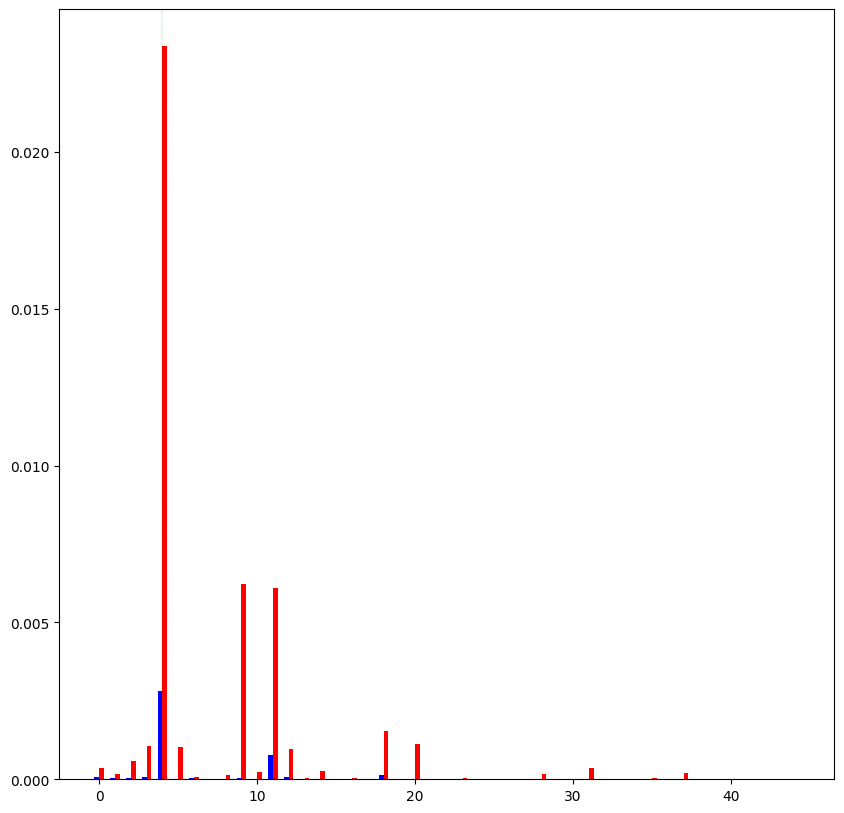

 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 50/119 [00:09<00:10,  6.74it/s]

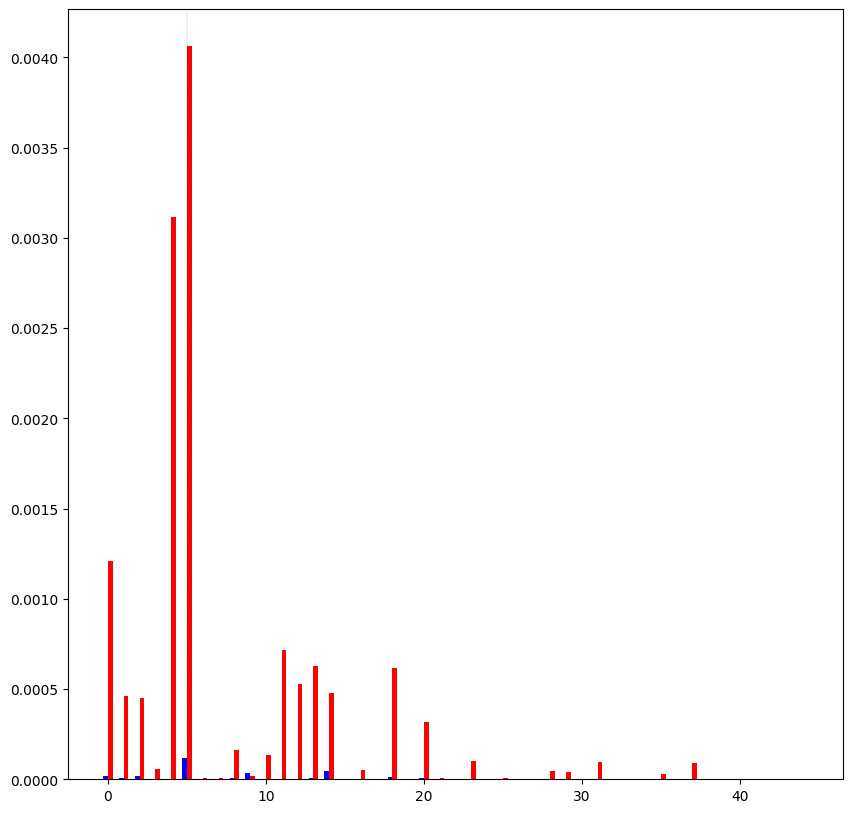

 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                 | 51/119 [00:09<00:11,  6.01it/s]

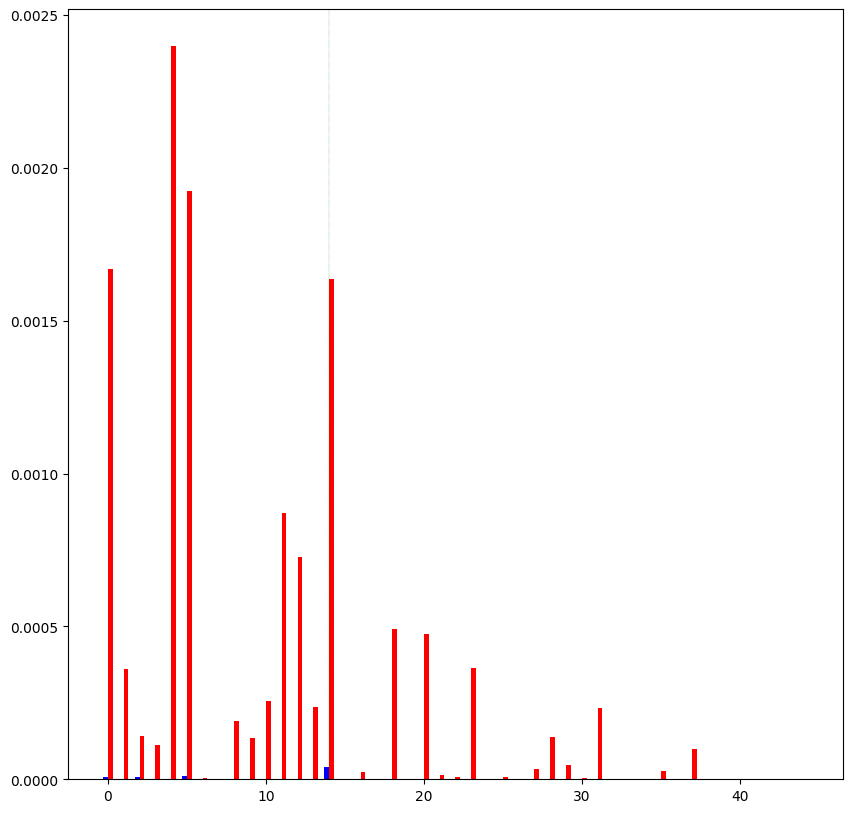

 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                               | 52/119 [00:09<00:12,  5.51it/s]

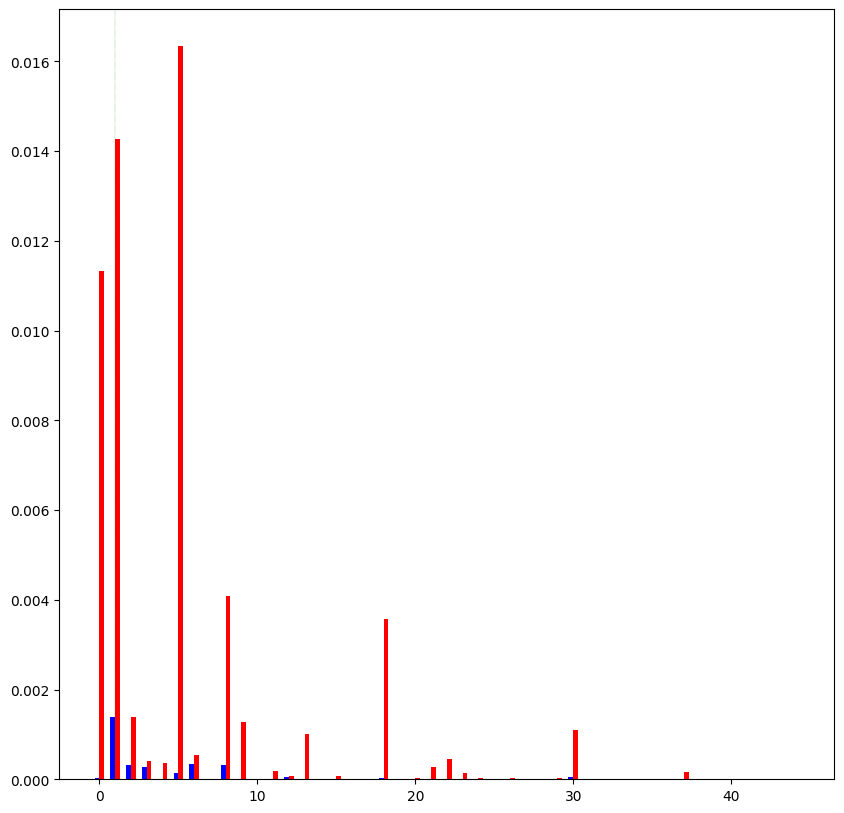

 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                              | 53/119 [00:09<00:12,  5.10it/s]

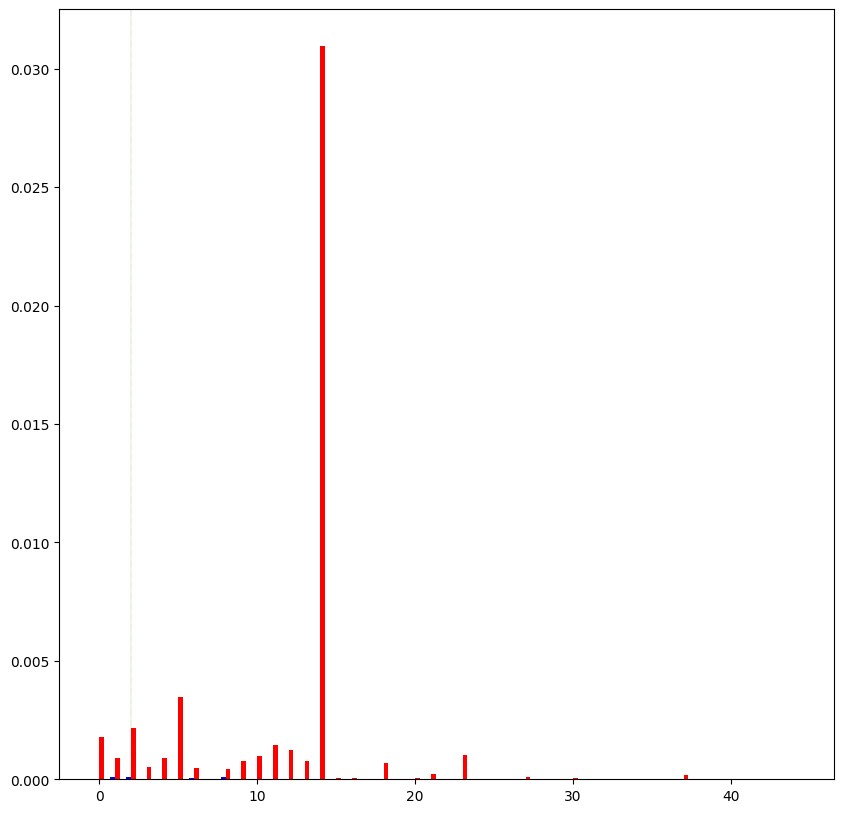

 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                            | 54/119 [00:10<00:13,  4.84it/s]

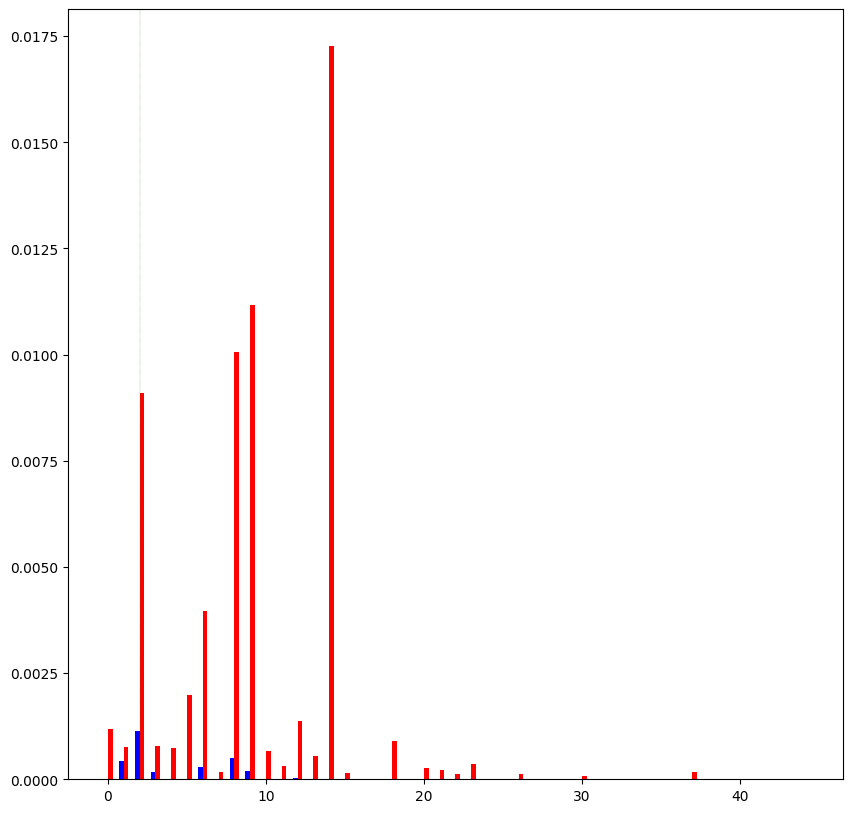

 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                           | 55/119 [00:10<00:13,  4.59it/s]

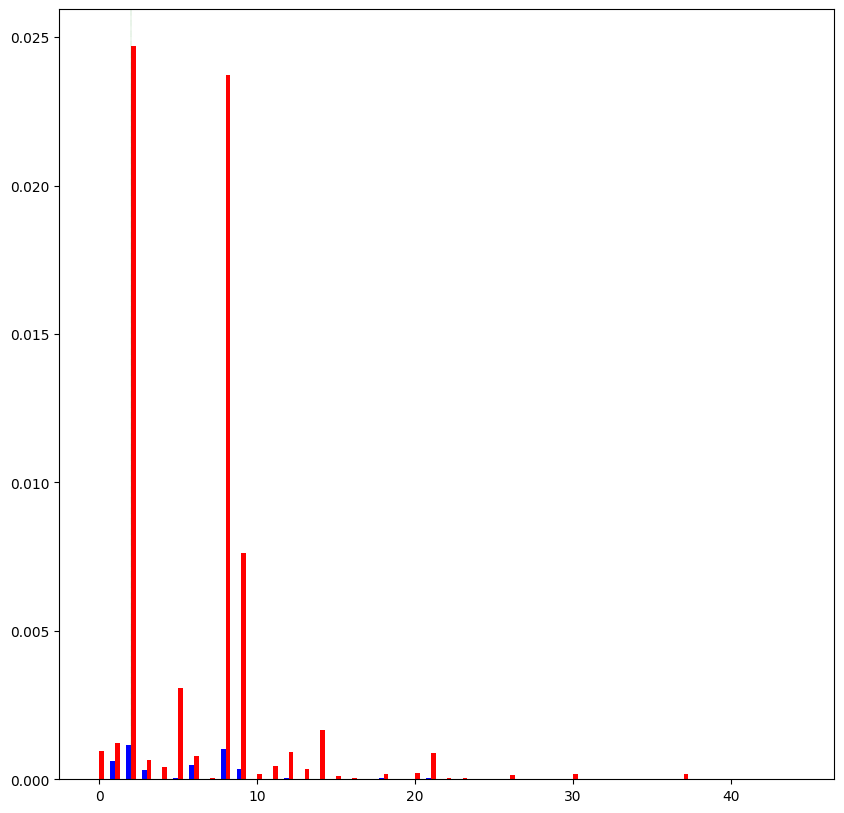

 47%|████████████████████████████████████████████████████████████████████████████████                                                                                          | 56/119 [00:10<00:13,  4.50it/s]

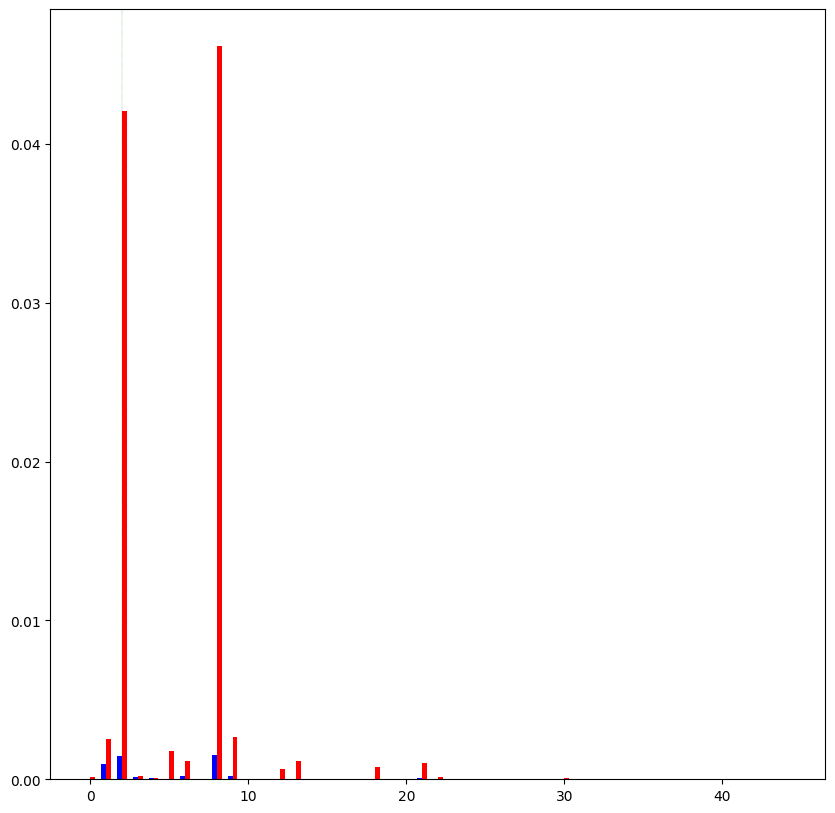

 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 57/119 [00:10<00:13,  4.47it/s]

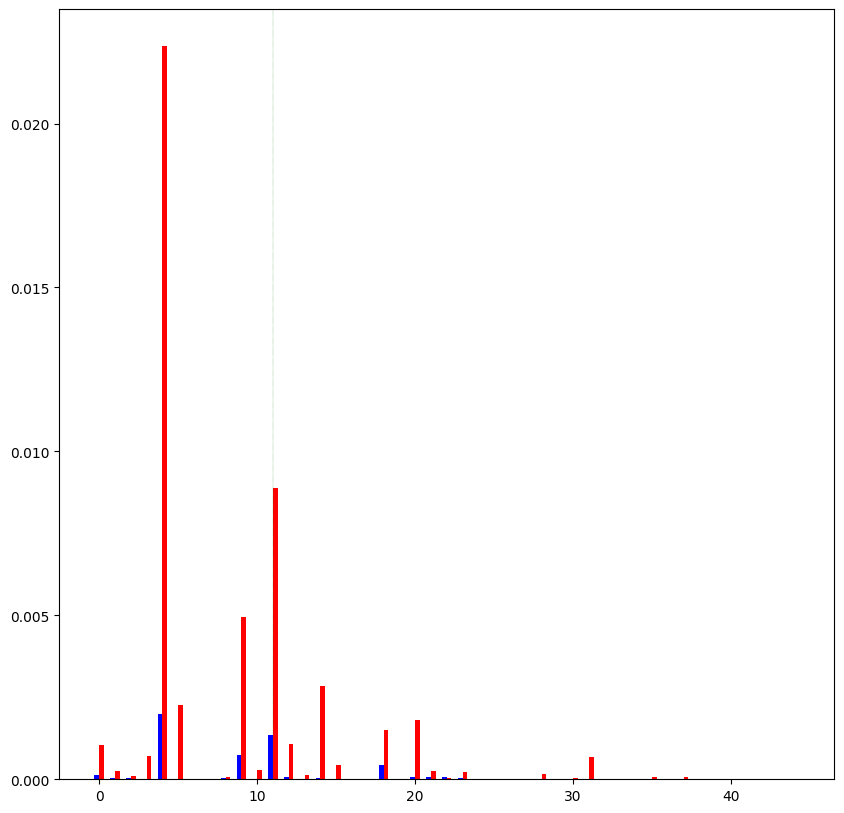

 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 59/119 [00:11<00:10,  5.71it/s]

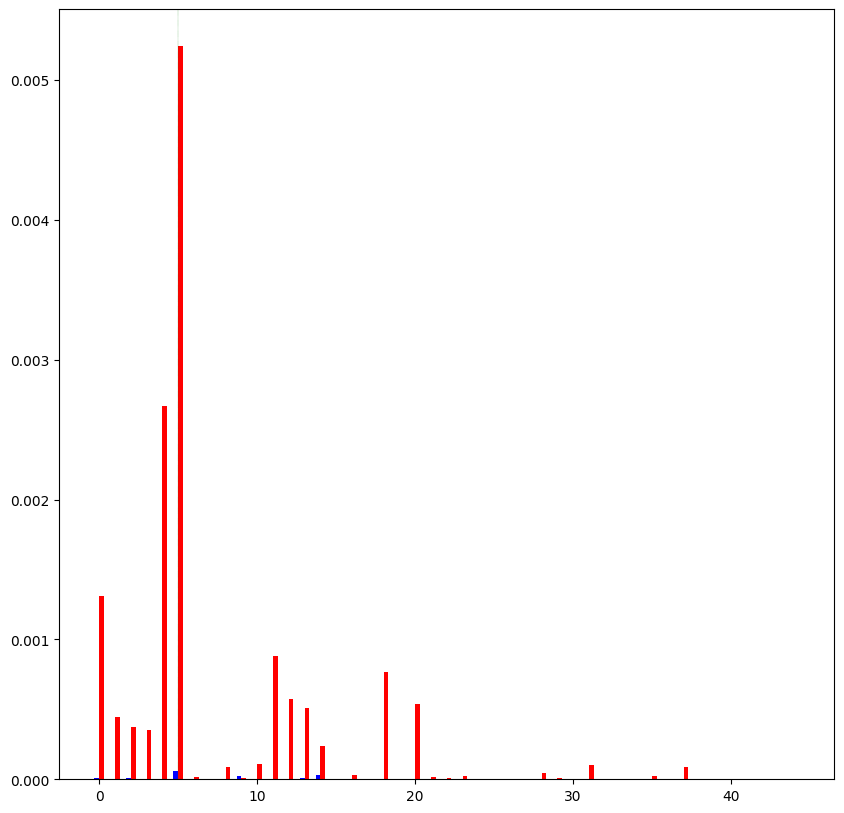

 50%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 60/119 [00:11<00:11,  5.29it/s]

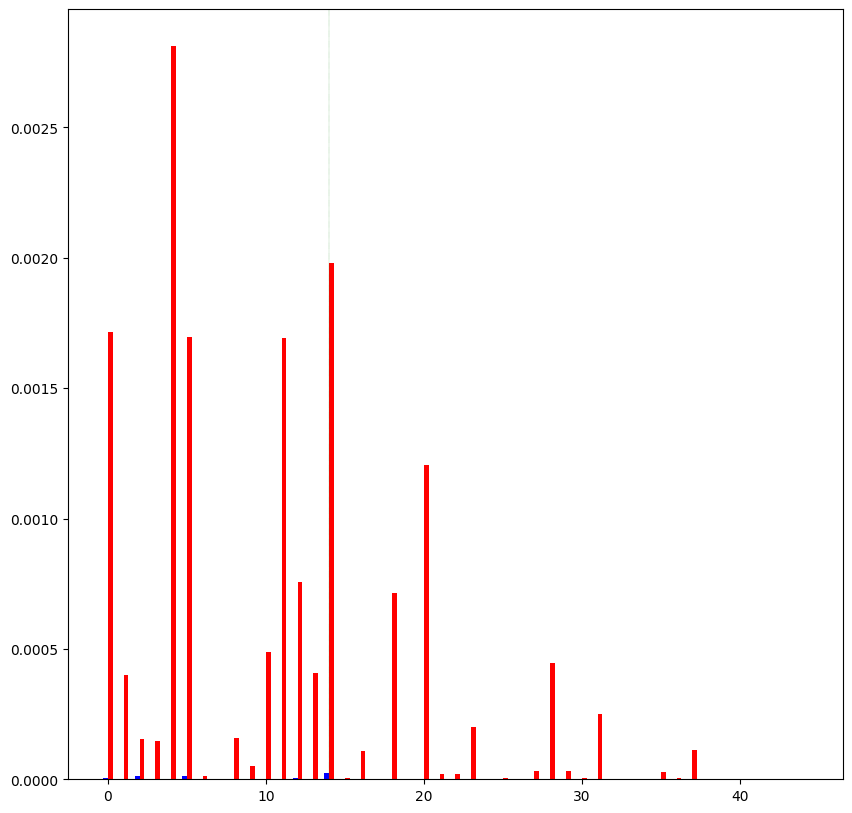

 51%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 61/119 [00:11<00:11,  5.00it/s]

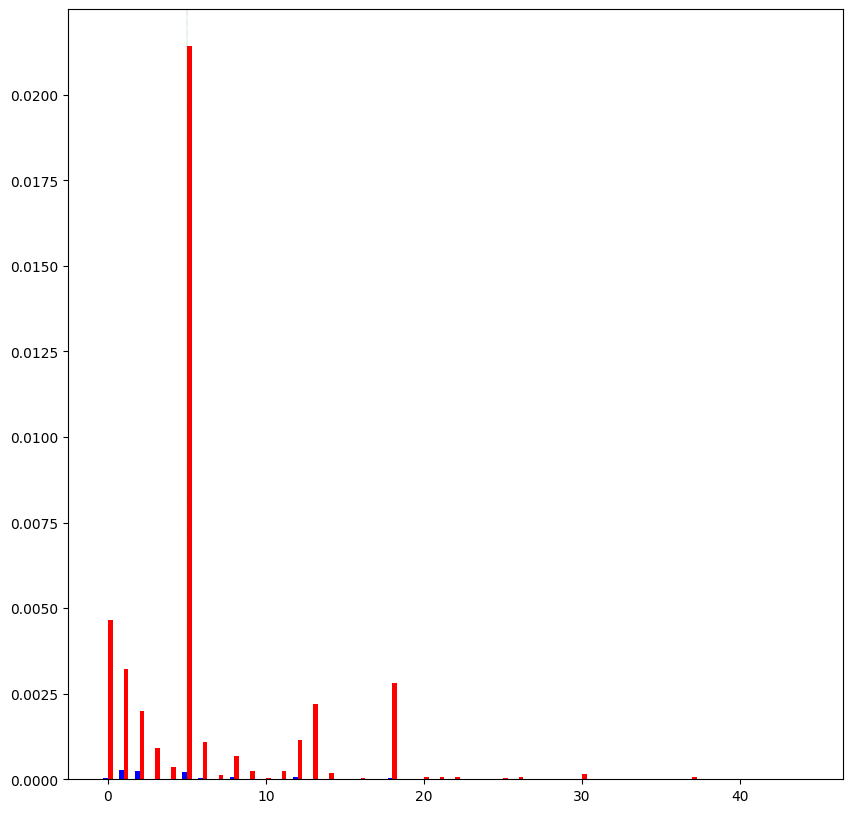

 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 62/119 [00:11<00:12,  4.72it/s]

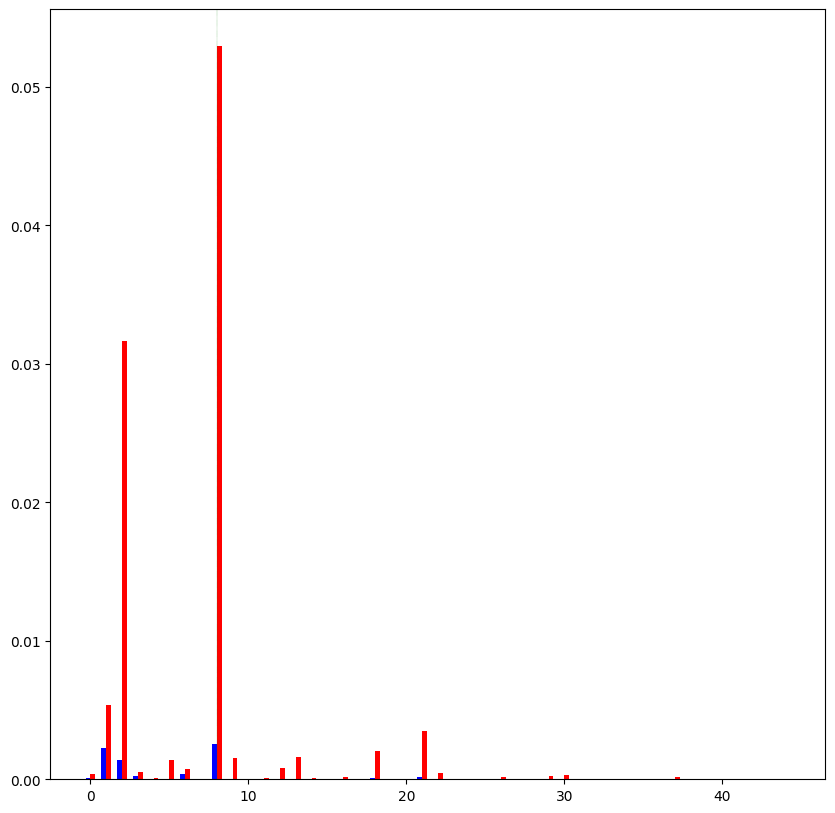

 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 63/119 [00:12<00:12,  4.59it/s]

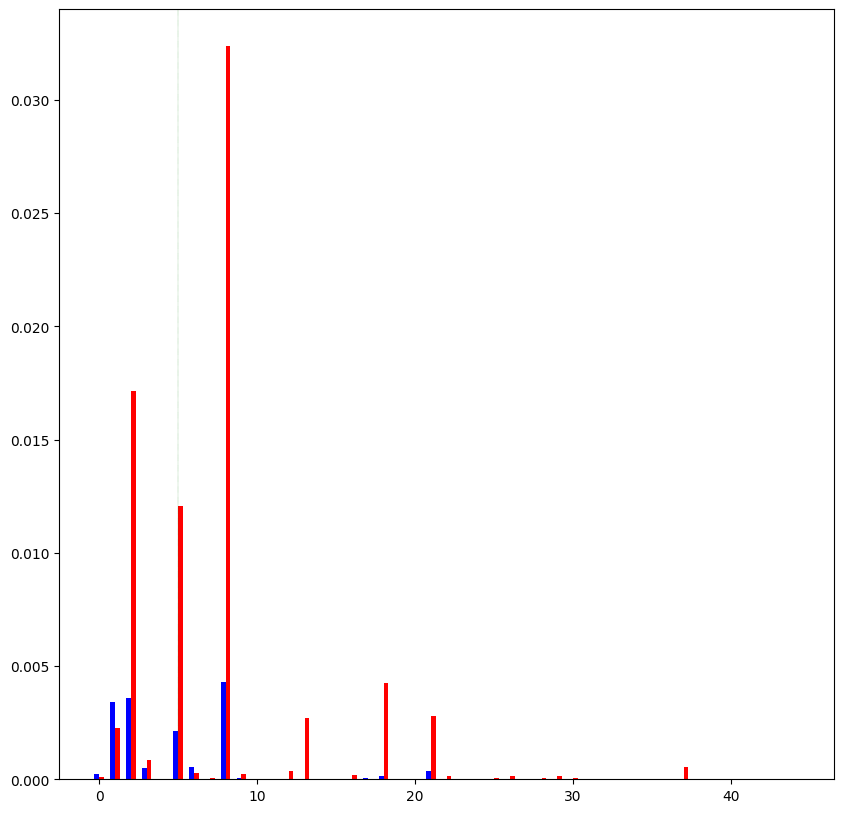

 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 64/119 [00:12<00:12,  4.49it/s]

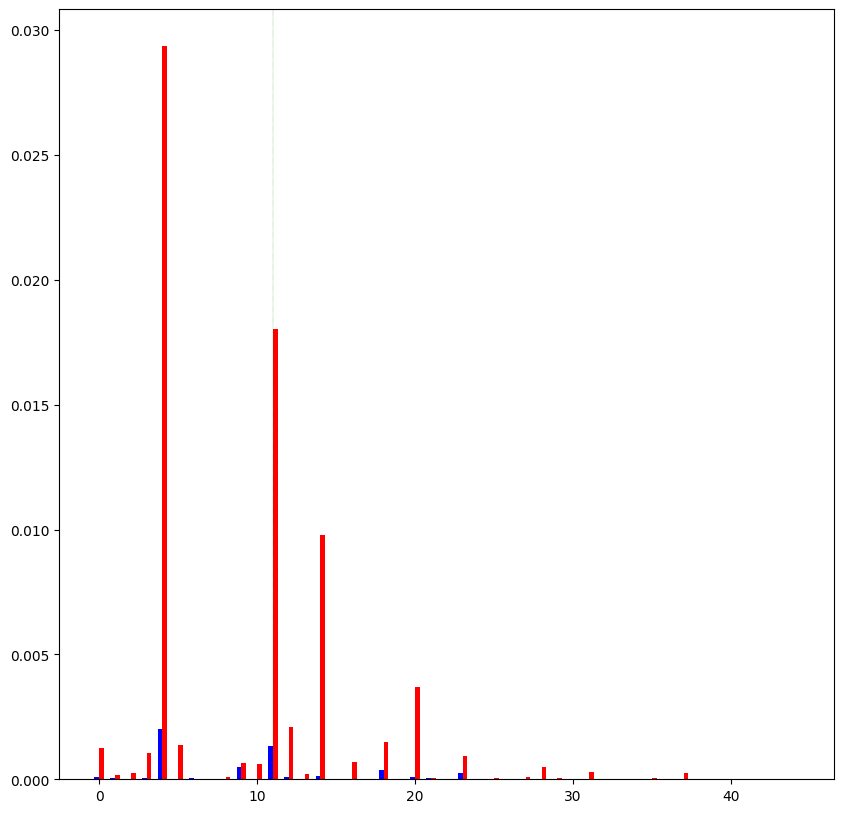

 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 65/119 [00:12<00:12,  4.41it/s]

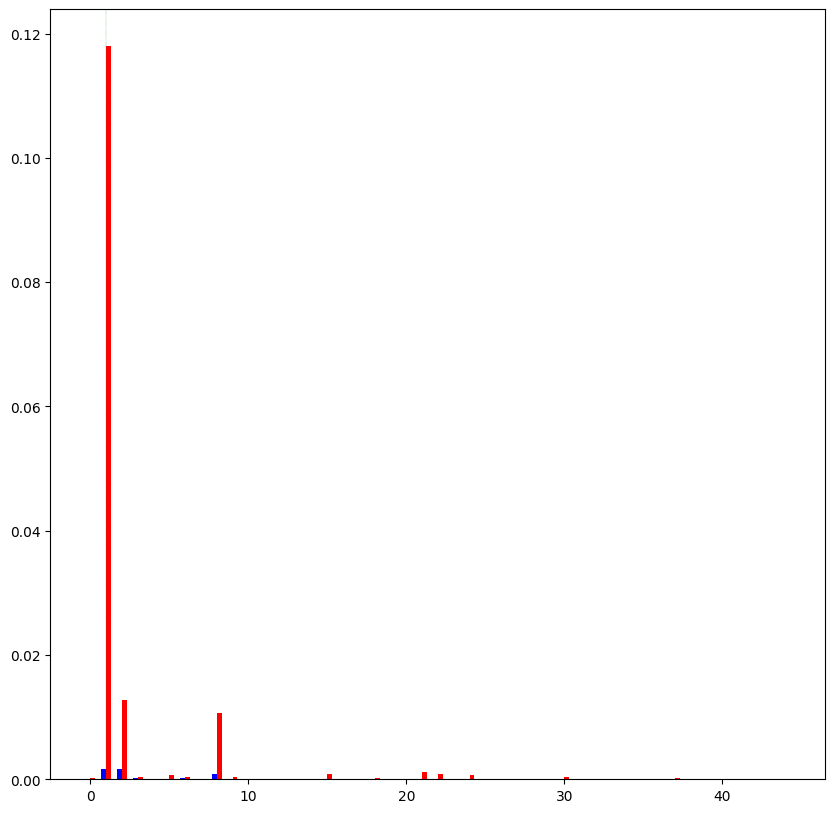

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 67/119 [00:12<00:09,  5.64it/s]

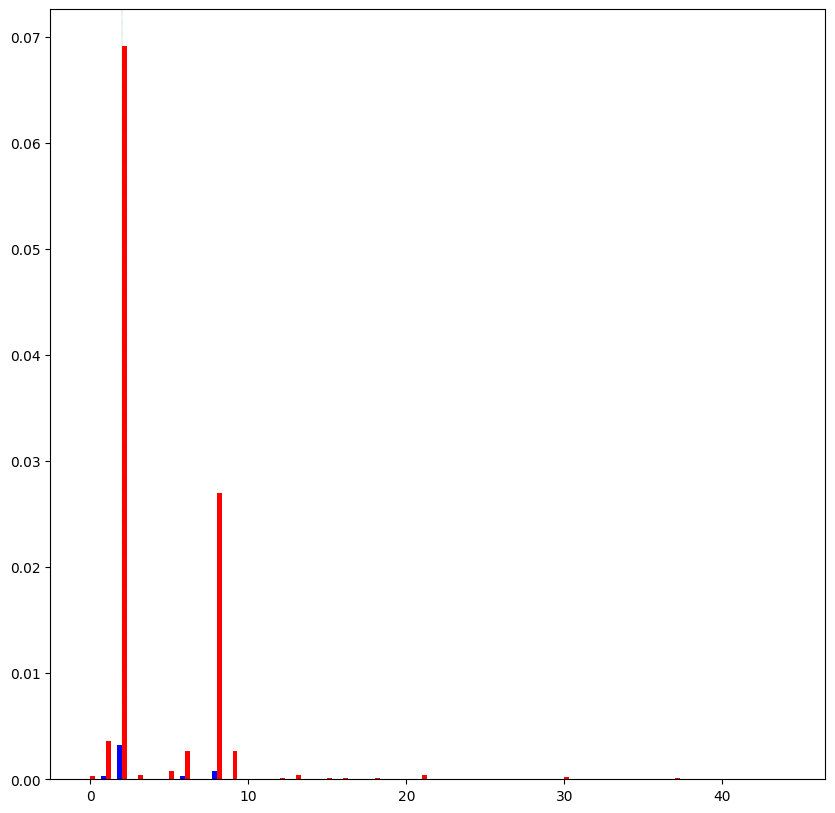

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 68/119 [00:13<00:09,  5.12it/s]

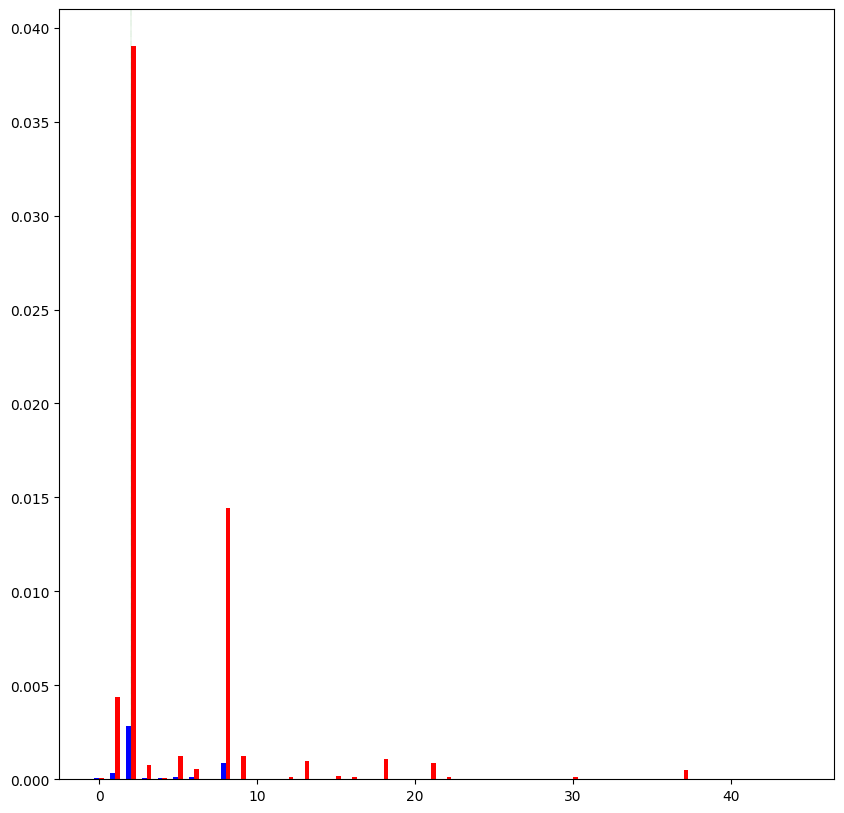

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 69/119 [00:13<00:10,  4.79it/s]

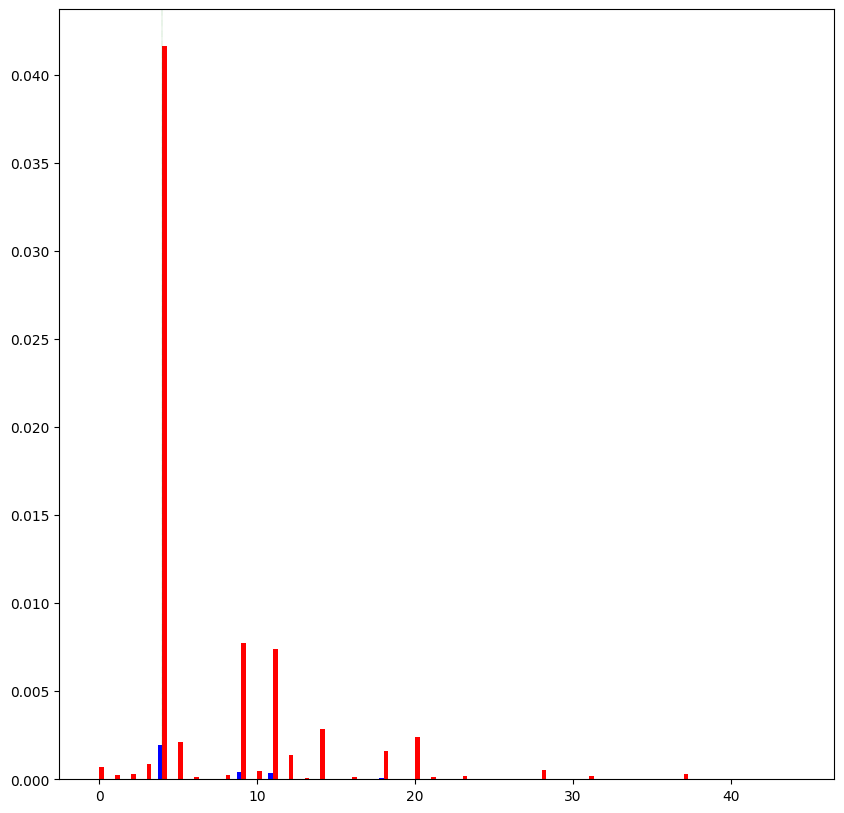

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 70/119 [00:13<00:10,  4.48it/s]

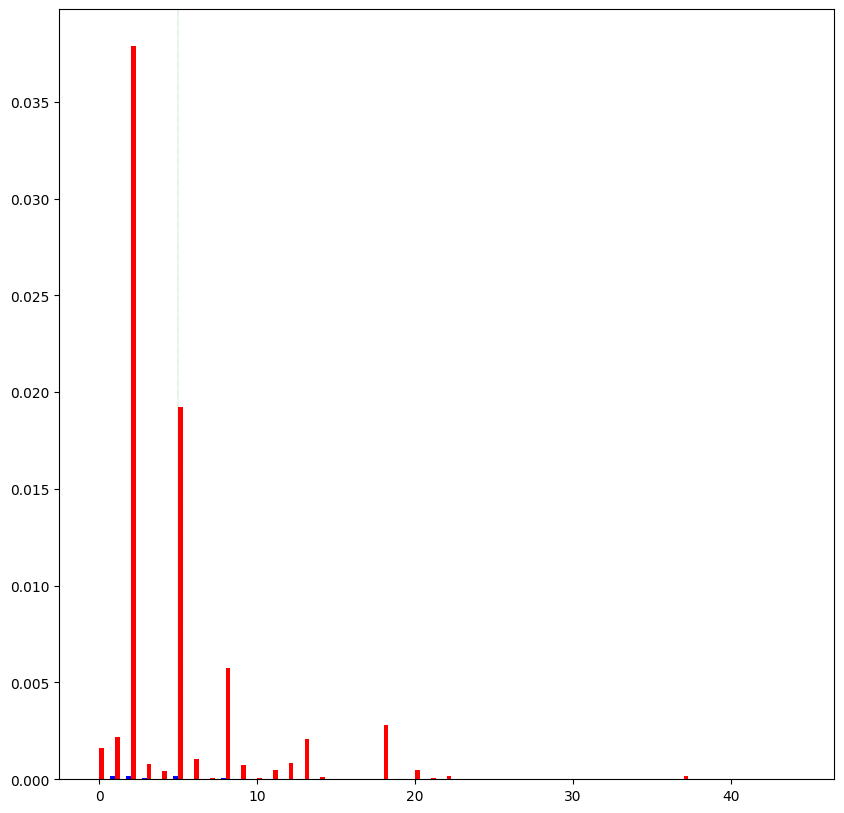

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 71/119 [00:13<00:10,  4.38it/s]

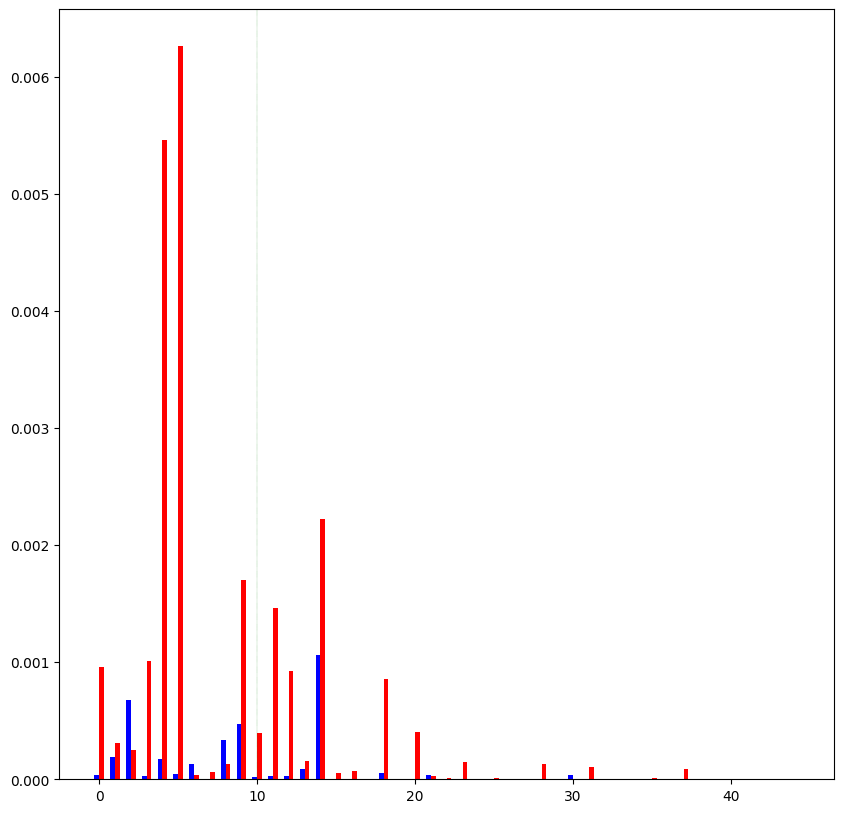

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 72/119 [00:14<00:10,  4.32it/s]

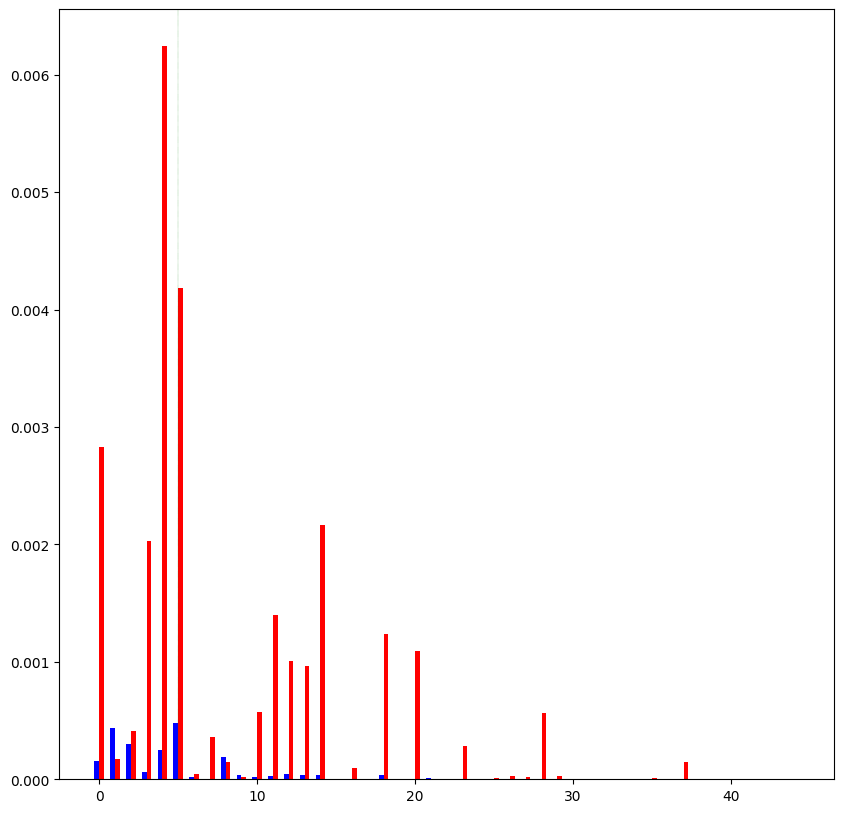

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 73/119 [00:14<00:10,  4.29it/s]

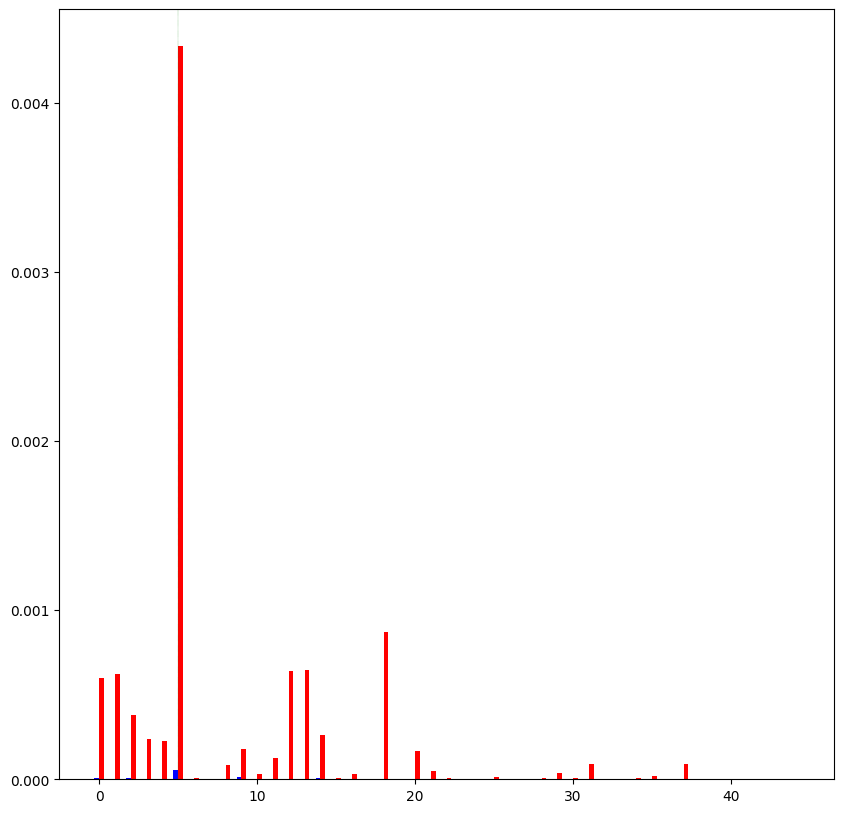

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 74/119 [00:14<00:10,  4.30it/s]

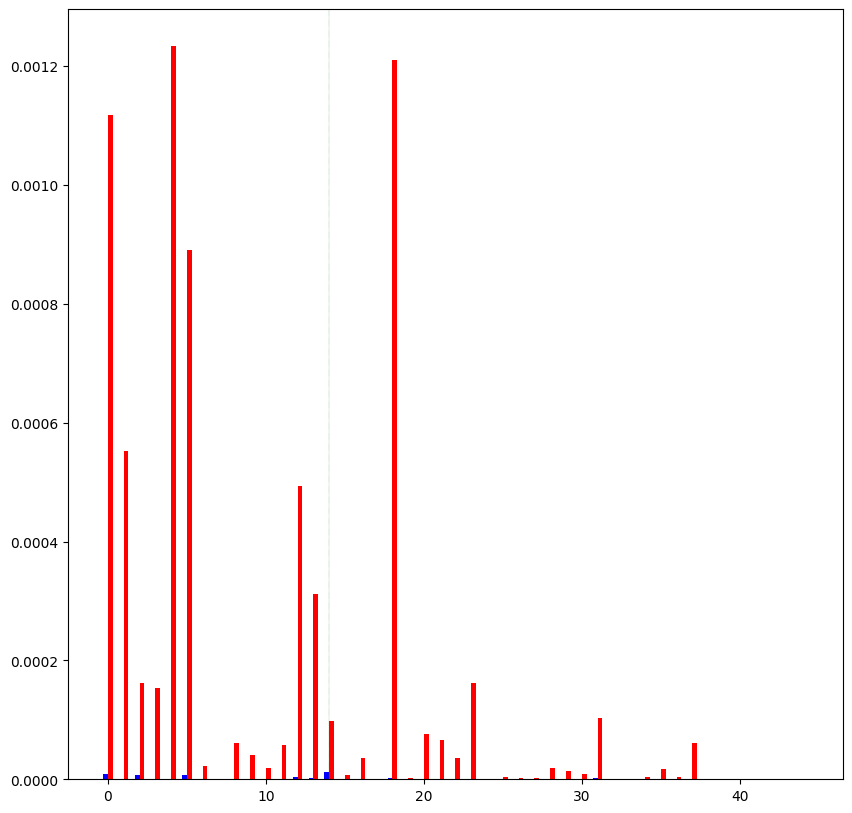

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 75/119 [00:14<00:10,  4.27it/s]

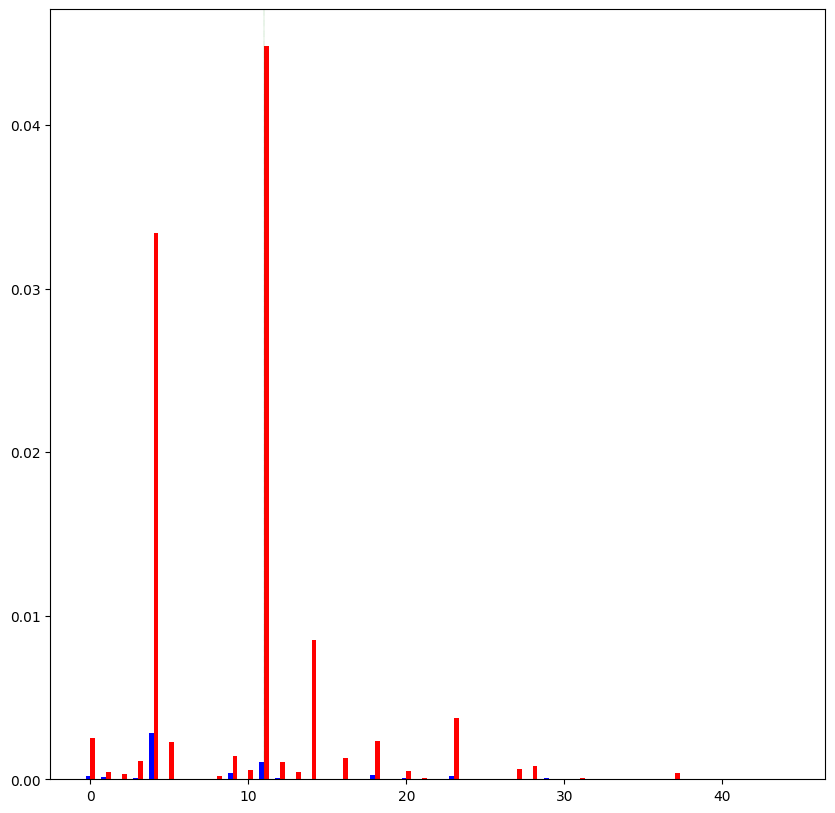

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 77/119 [00:14<00:07,  5.53it/s]

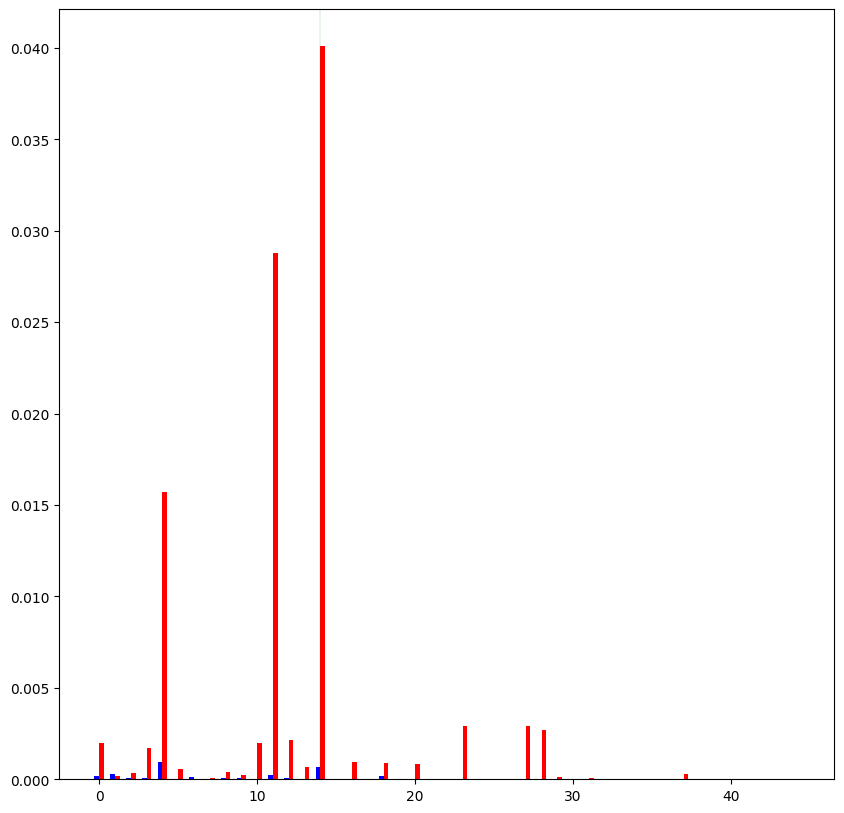

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 80/119 [00:15<00:05,  7.58it/s]

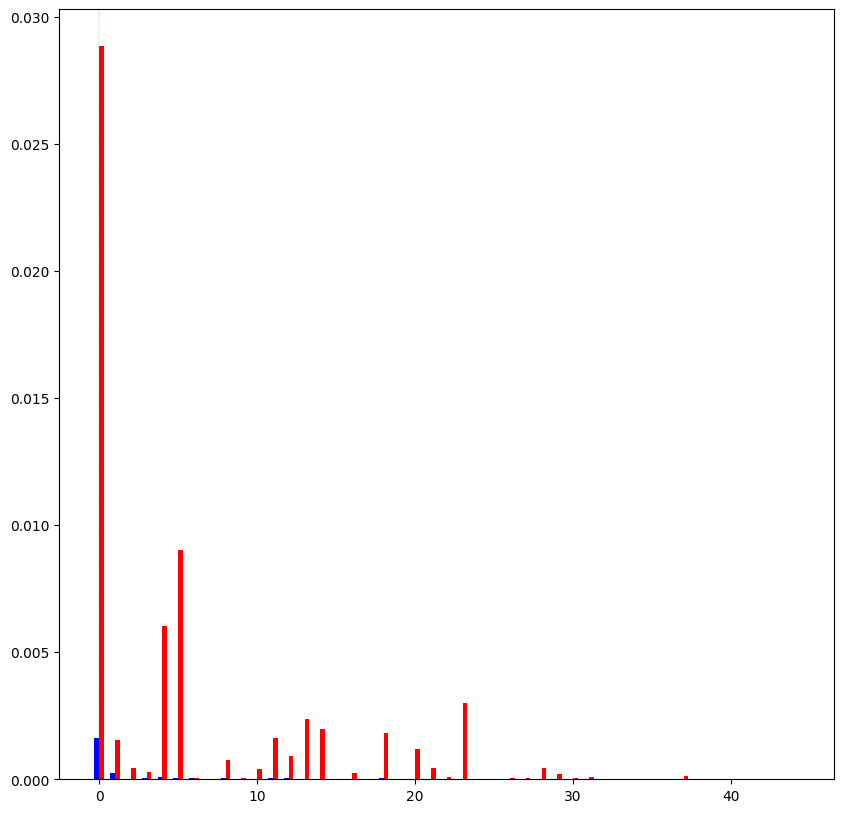

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 81/119 [00:15<00:05,  6.55it/s]

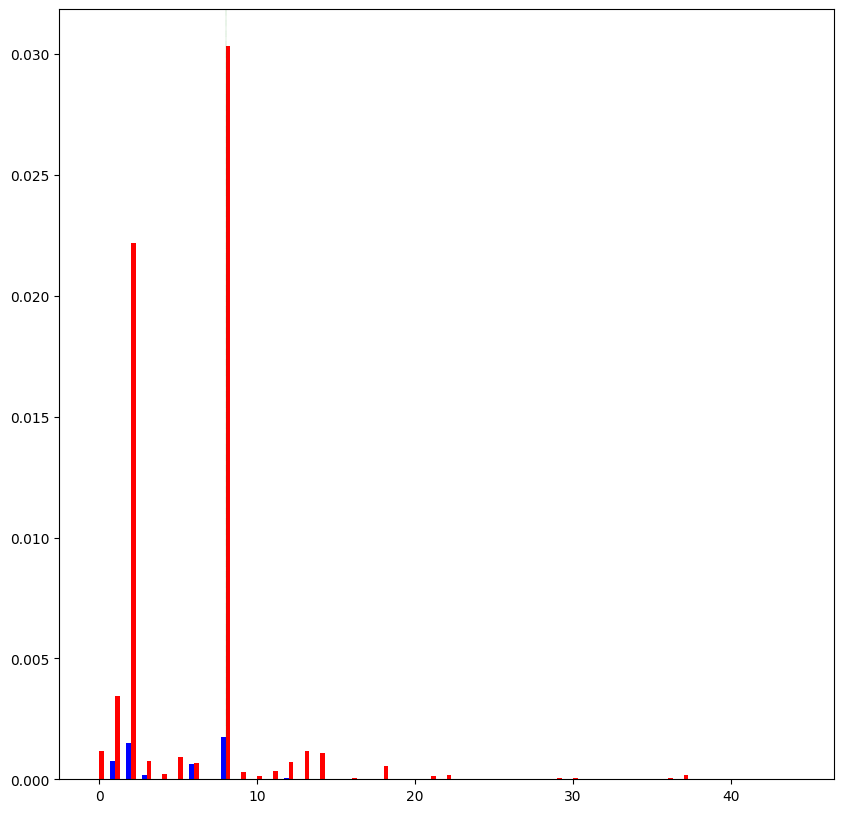

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 85/119 [00:15<00:03,  9.57it/s]

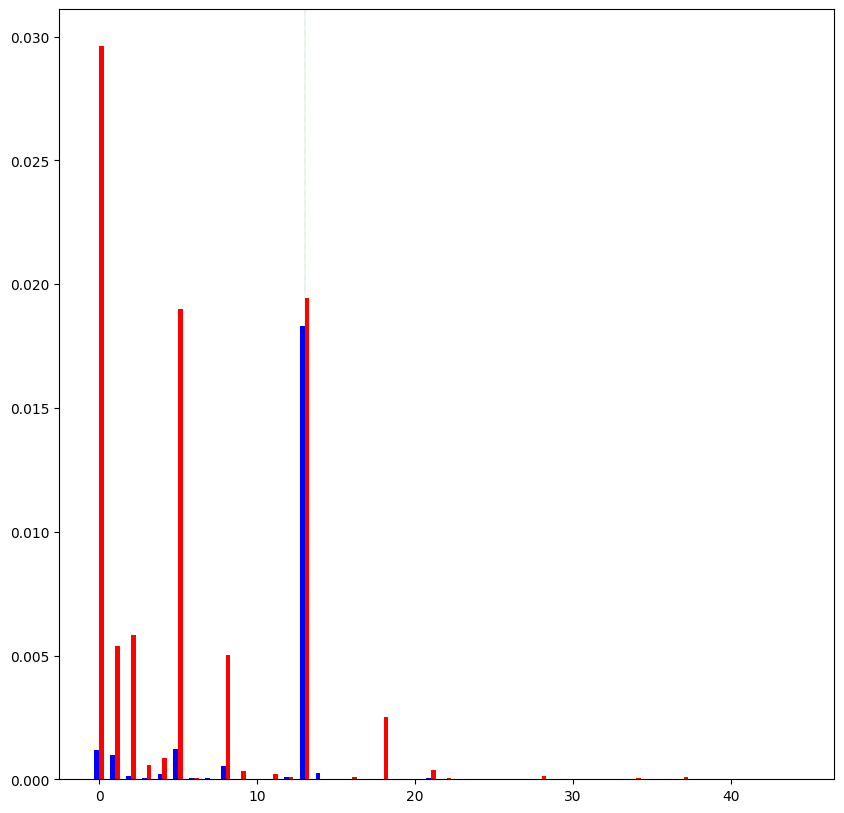

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 86/119 [00:15<00:04,  7.92it/s]

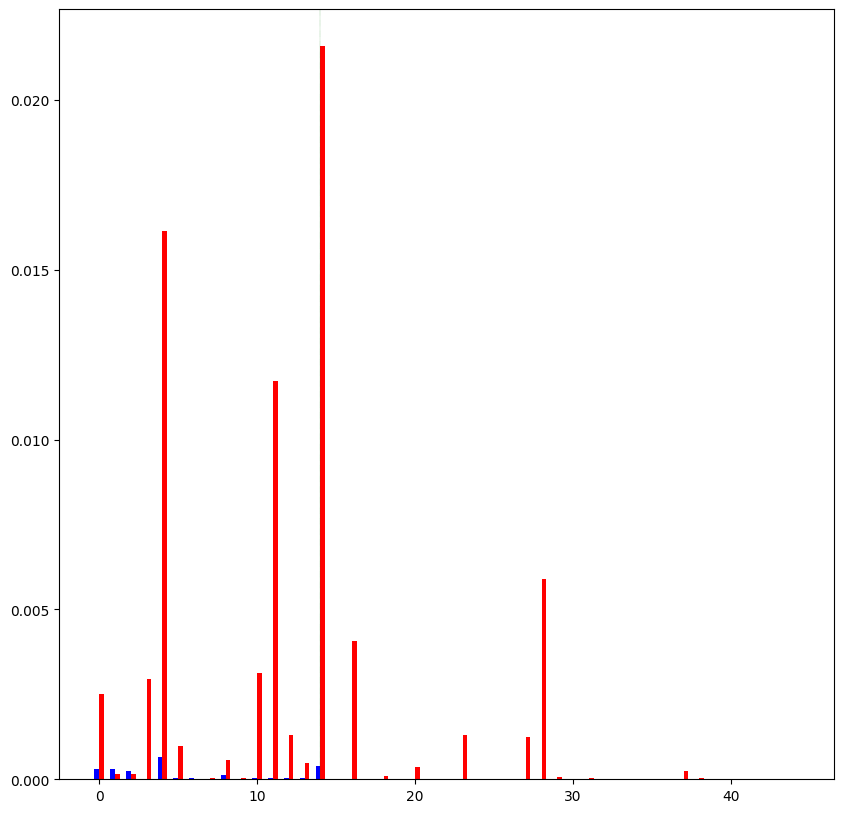

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 87/119 [00:16<00:04,  6.86it/s]

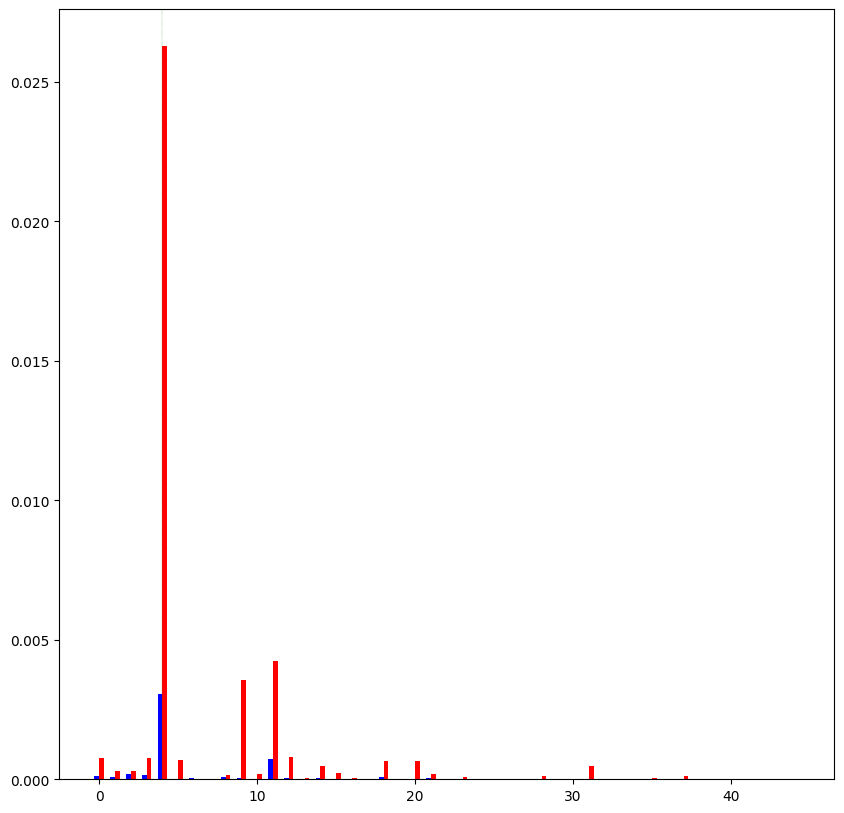

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 88/119 [00:16<00:05,  6.10it/s]

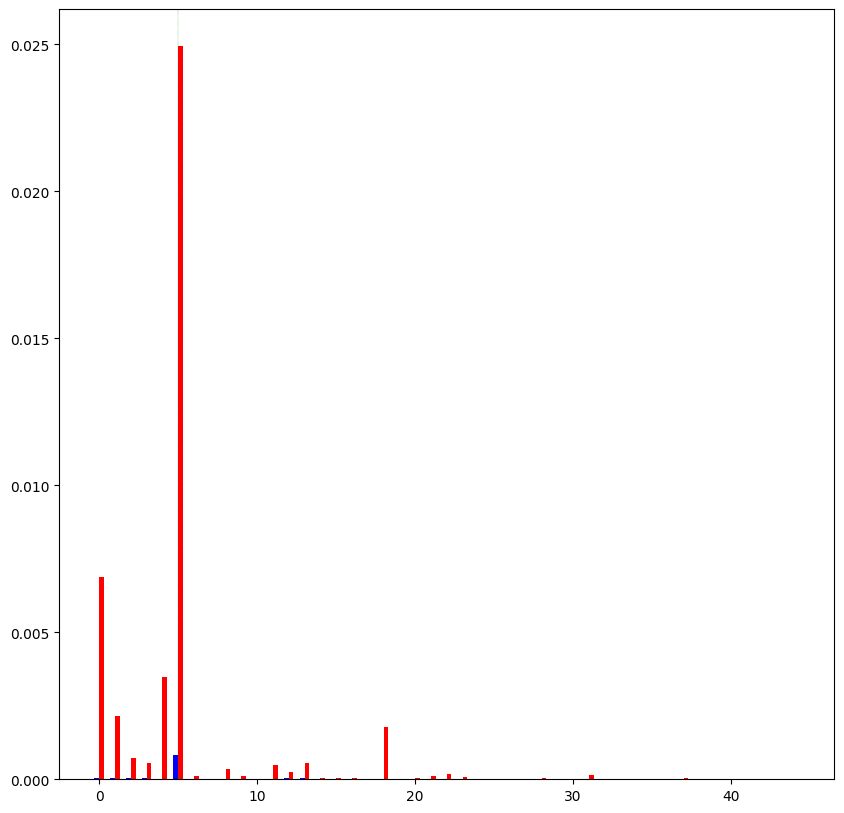

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 89/119 [00:16<00:05,  5.55it/s]

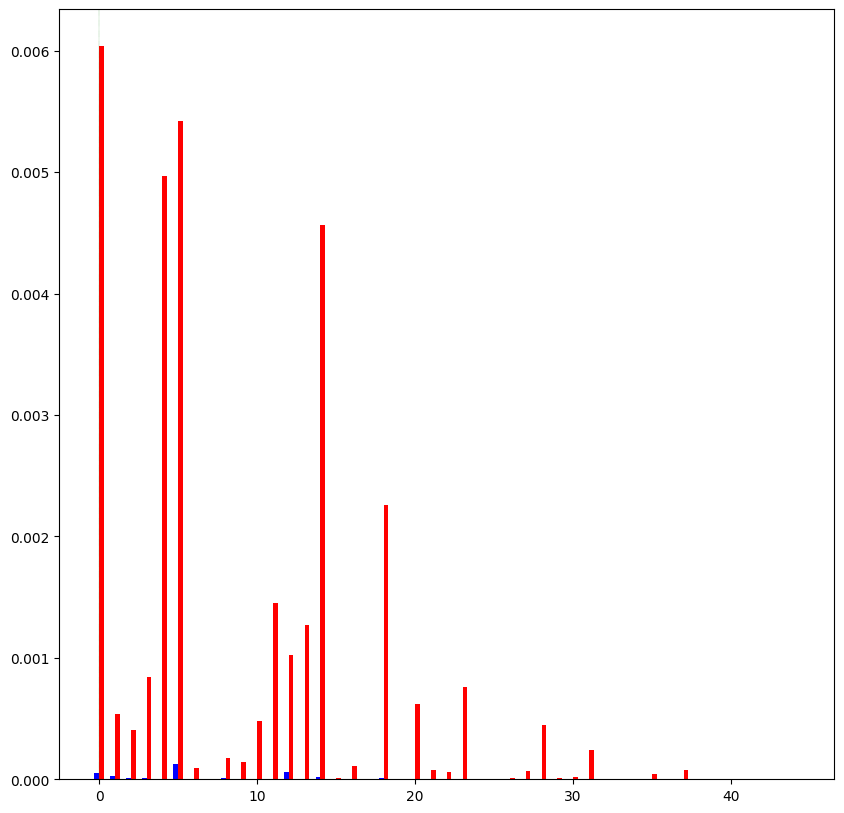

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 90/119 [00:16<00:05,  5.13it/s]

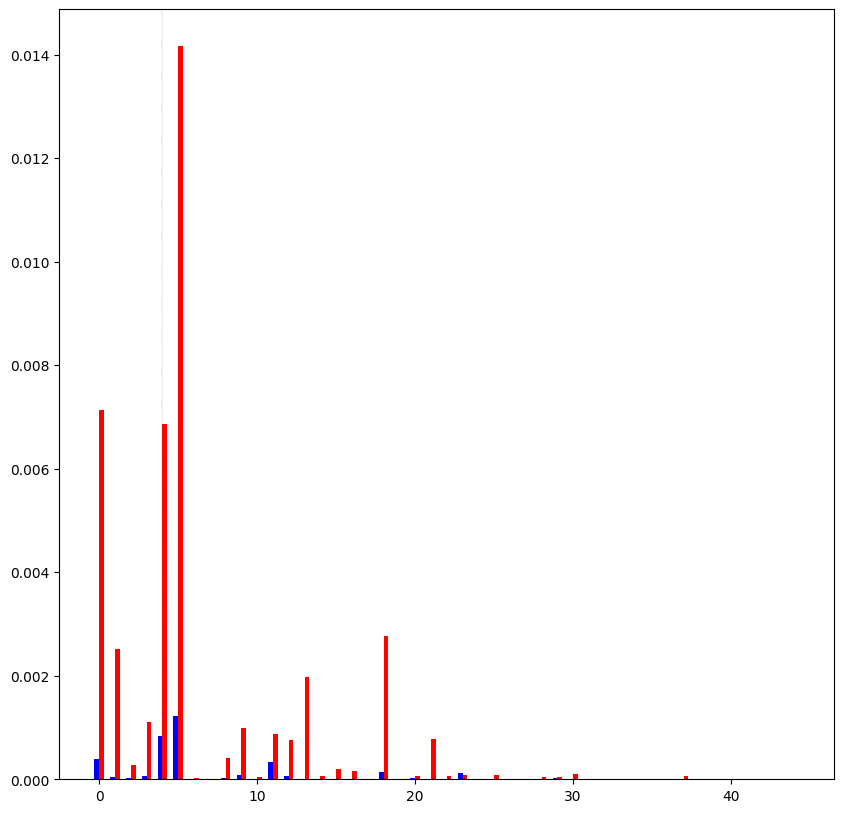

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 91/119 [00:17<00:05,  4.82it/s]

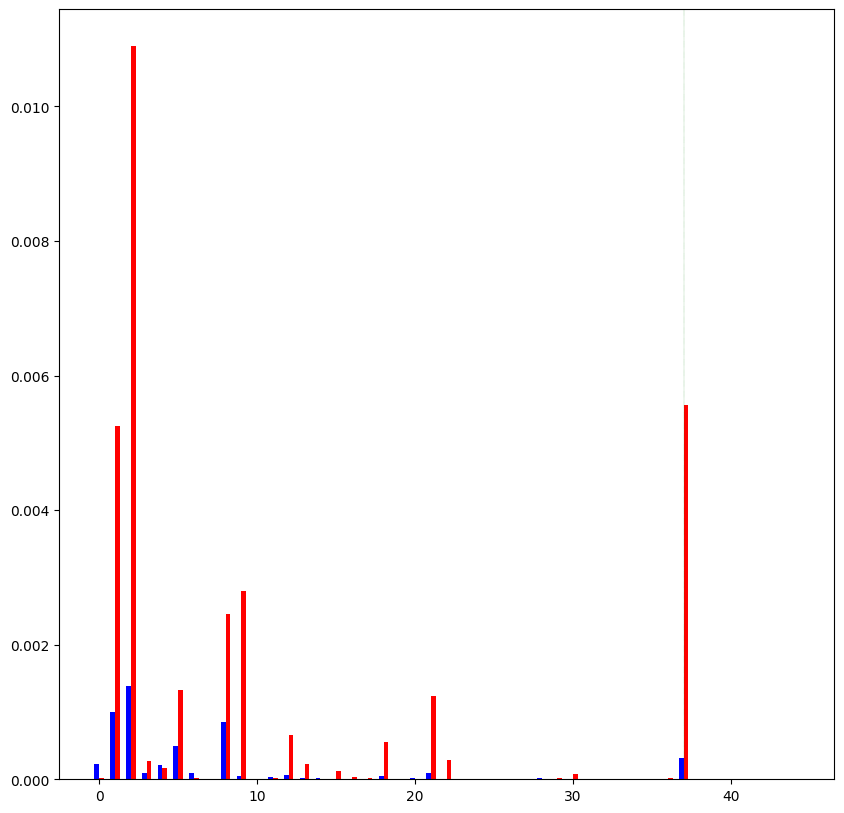

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 92/119 [00:18<00:11,  2.33it/s]

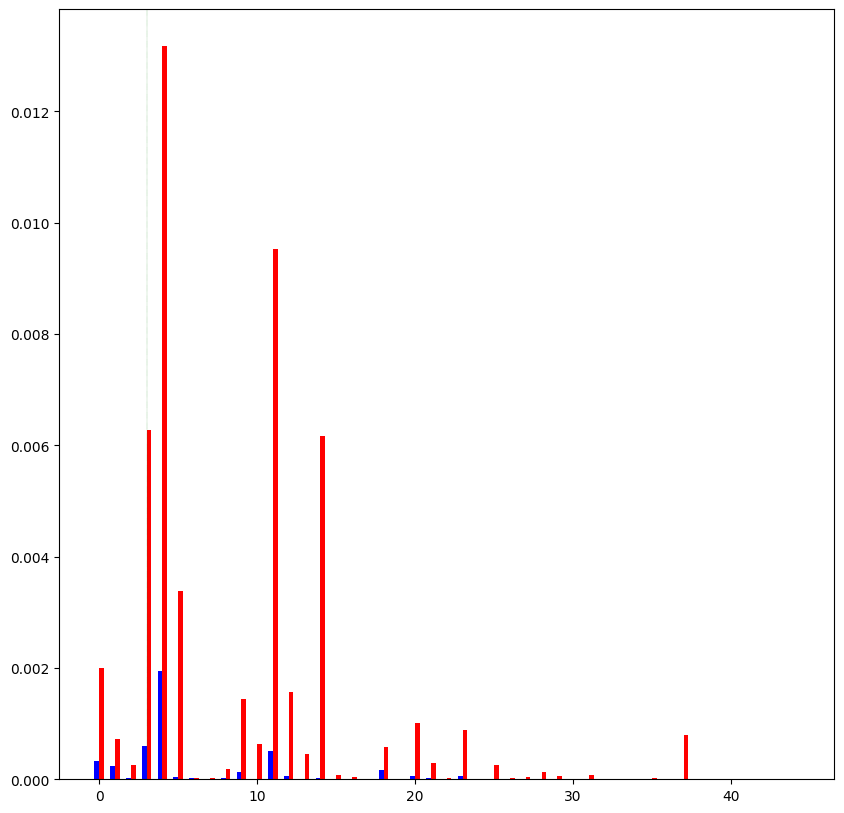

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 93/119 [00:18<00:09,  2.66it/s]

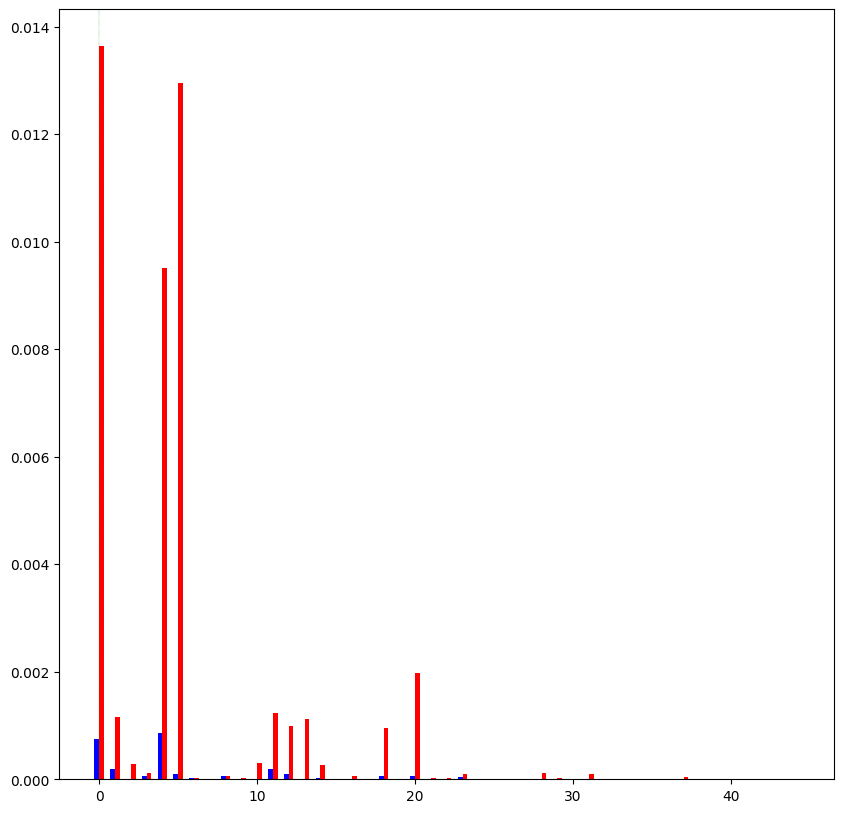

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 94/119 [00:18<00:08,  2.93it/s]

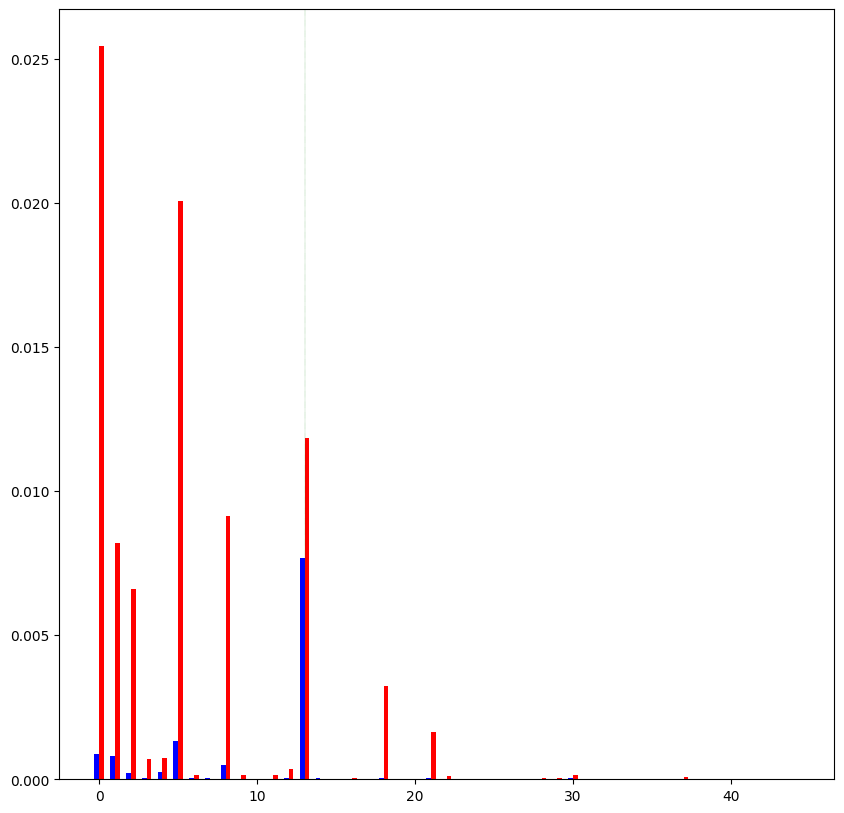

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 99/119 [00:18<00:02,  6.93it/s]

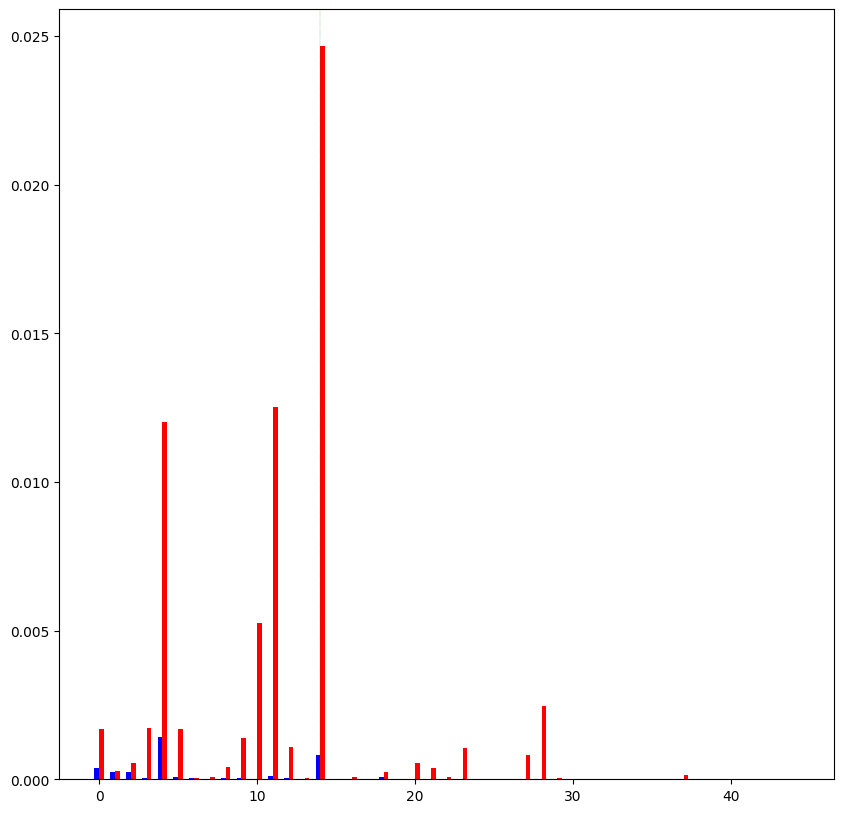

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 100/119 [00:19<00:03,  6.30it/s]

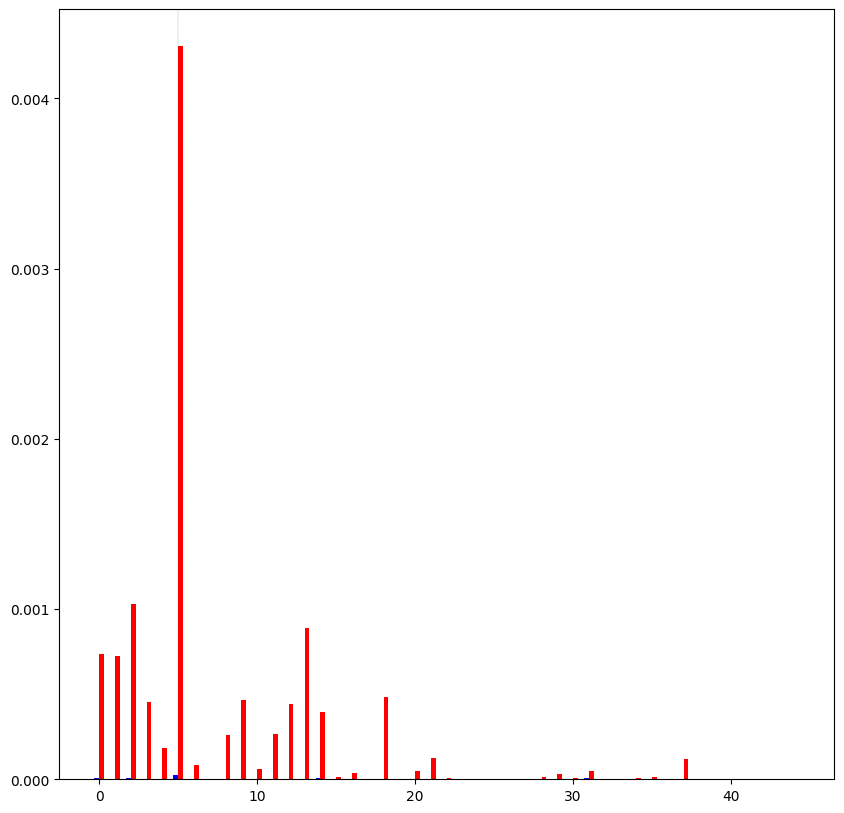

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 101/119 [00:19<00:03,  5.82it/s]

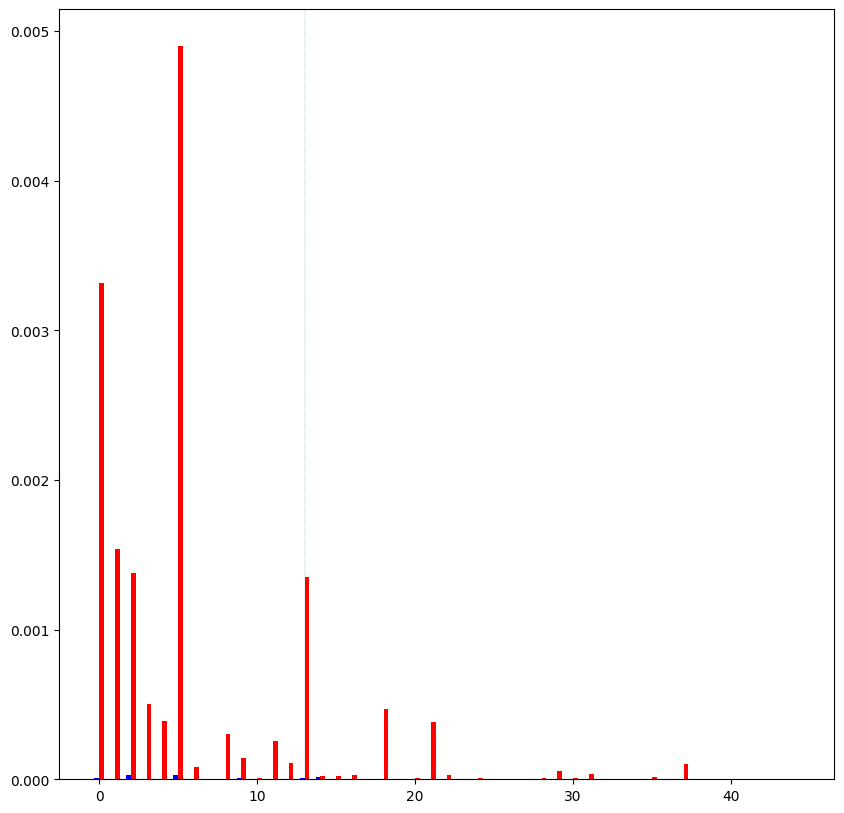

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 102/119 [00:19<00:03,  5.17it/s]

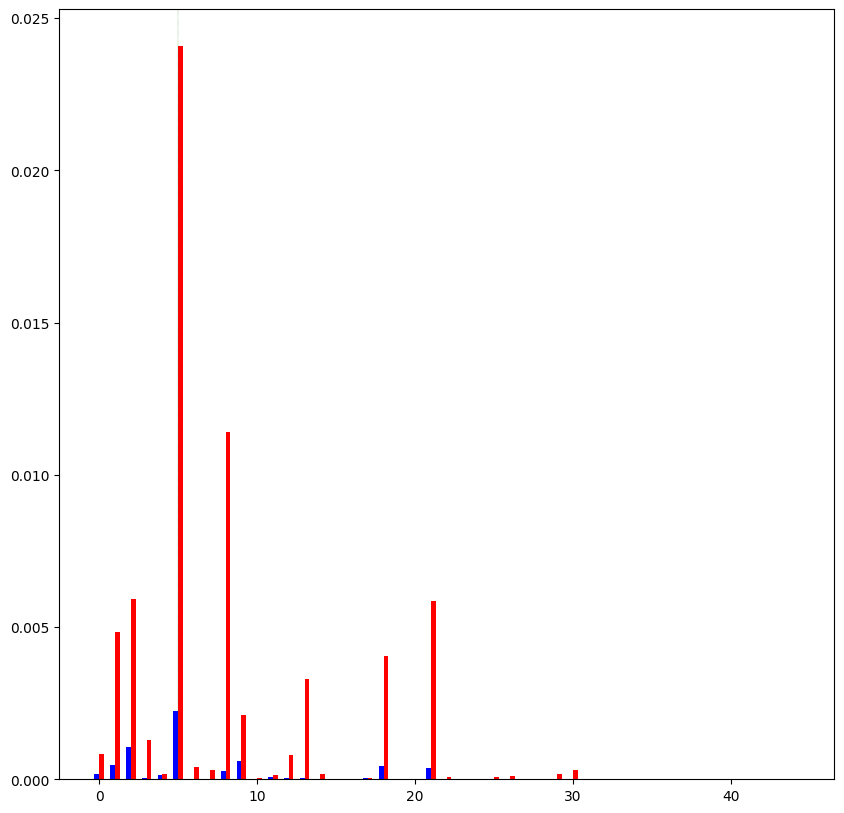

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 103/119 [00:19<00:03,  4.93it/s]

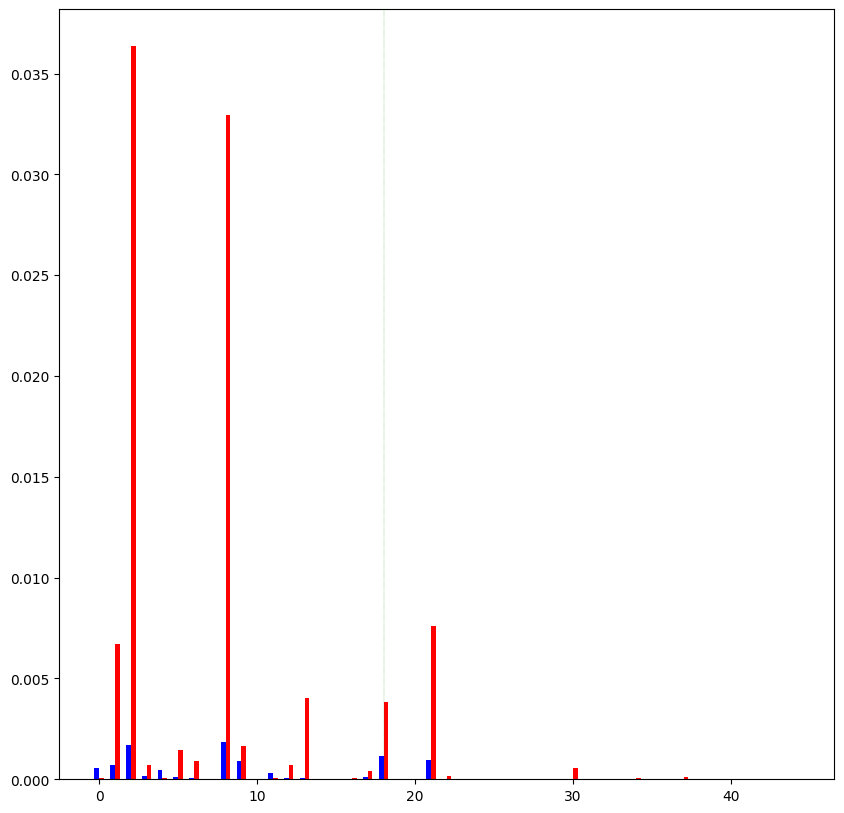

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 104/119 [00:20<00:03,  4.71it/s]

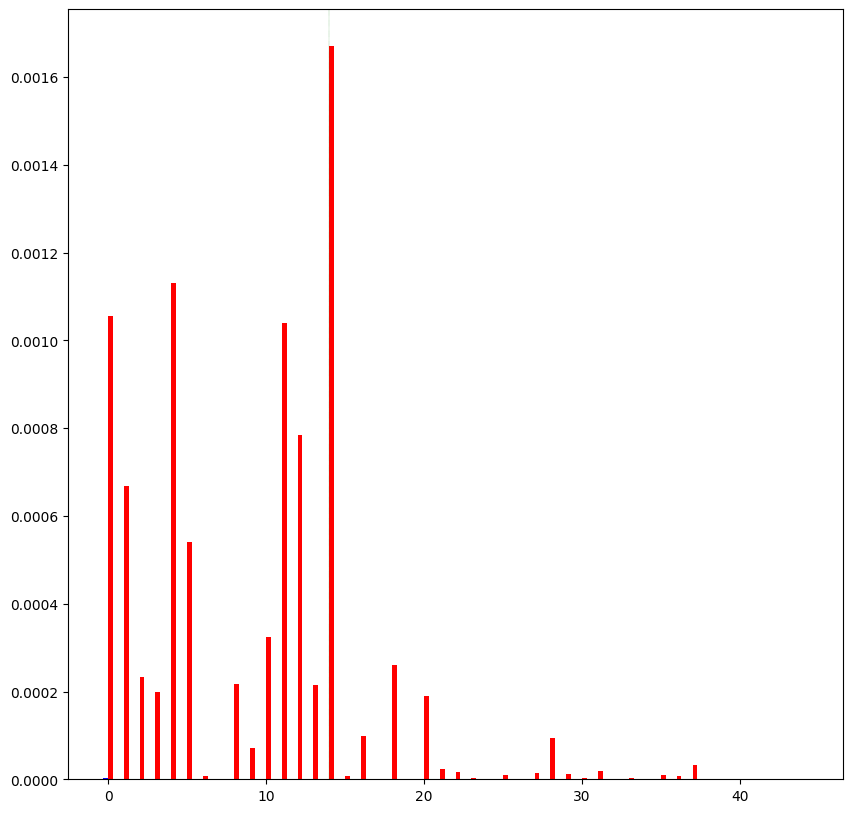

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 105/119 [00:20<00:03,  4.52it/s]

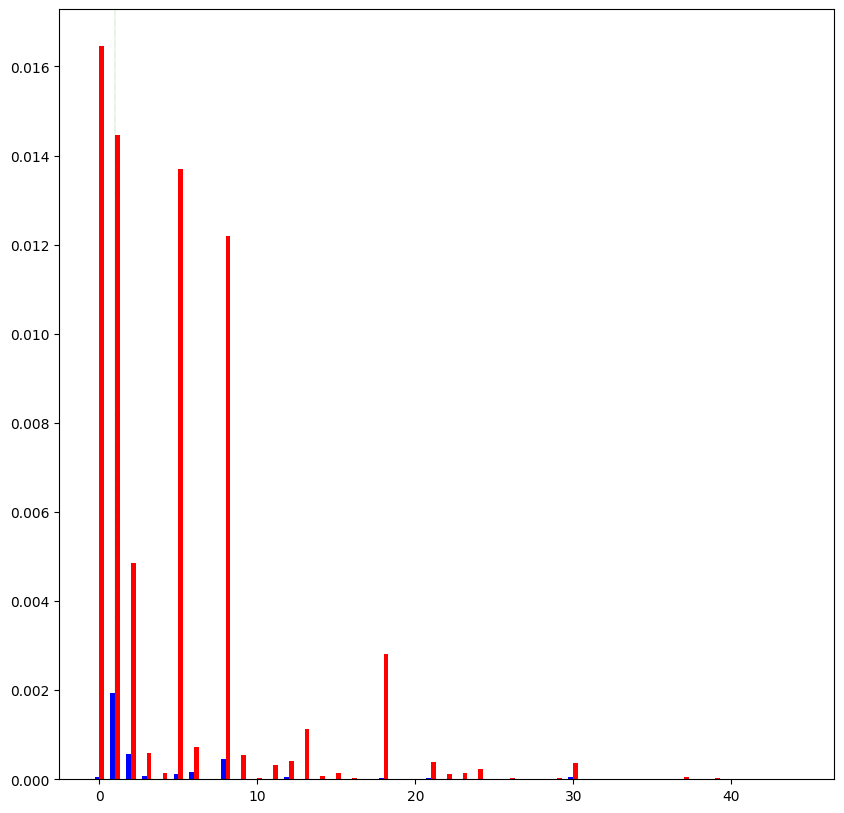

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 107/119 [00:20<00:02,  5.56it/s]

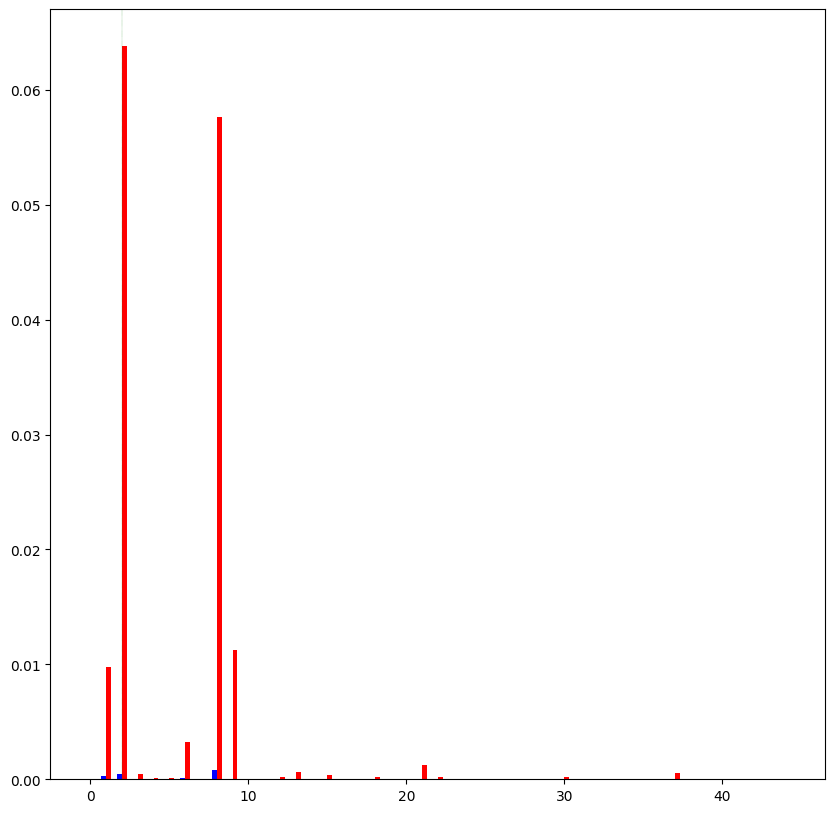

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 108/119 [00:20<00:02,  4.94it/s]

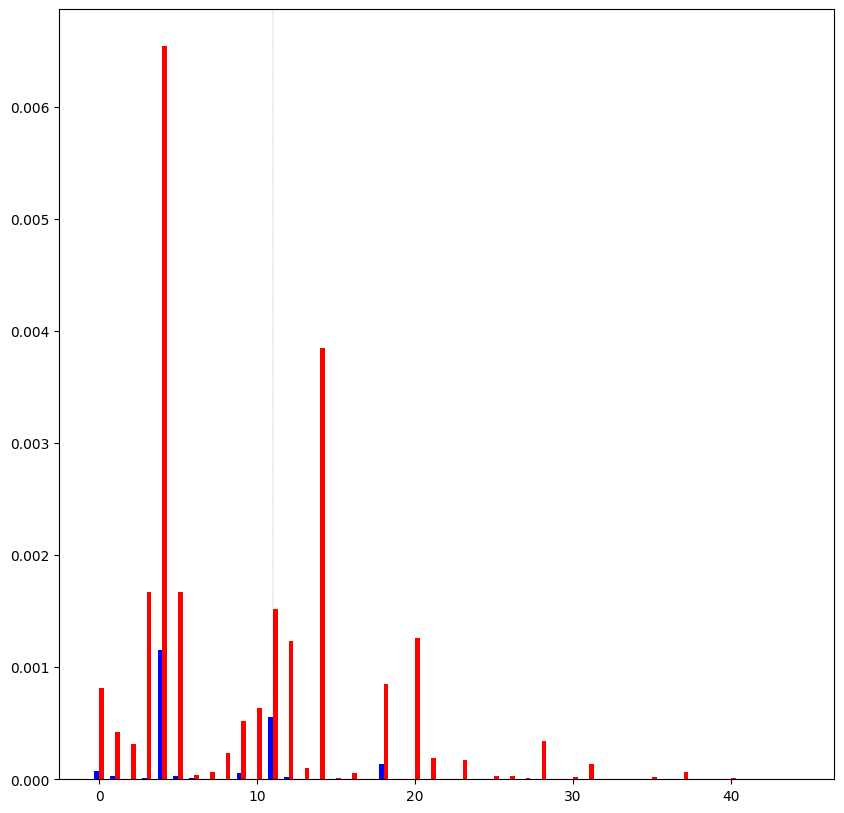

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 109/119 [00:21<00:02,  4.78it/s]

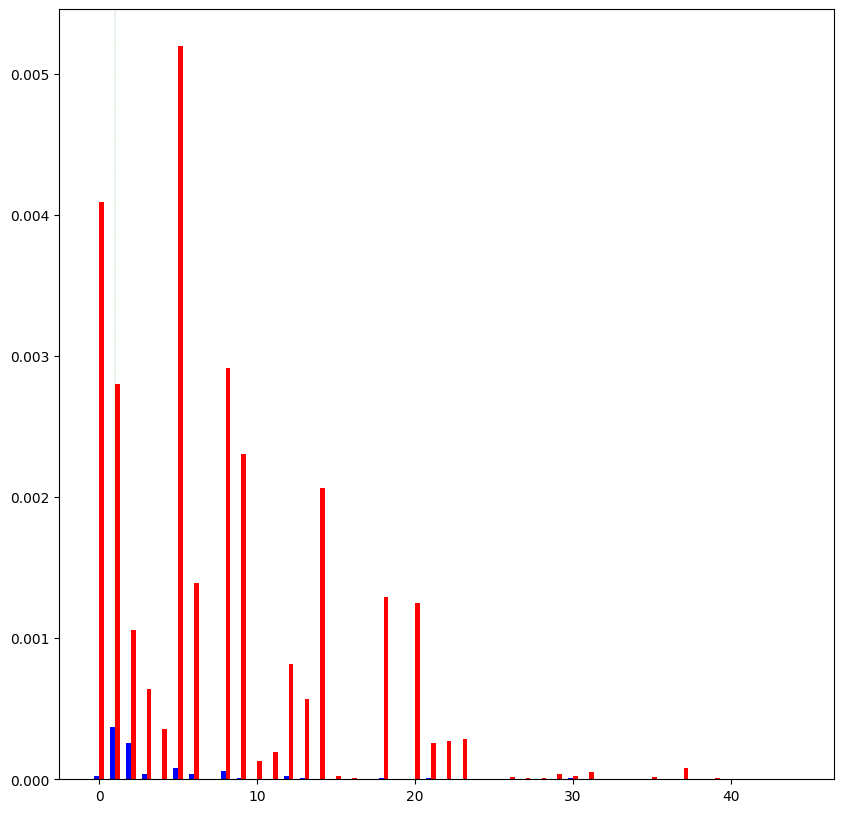

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 111/119 [00:21<00:01,  5.92it/s]

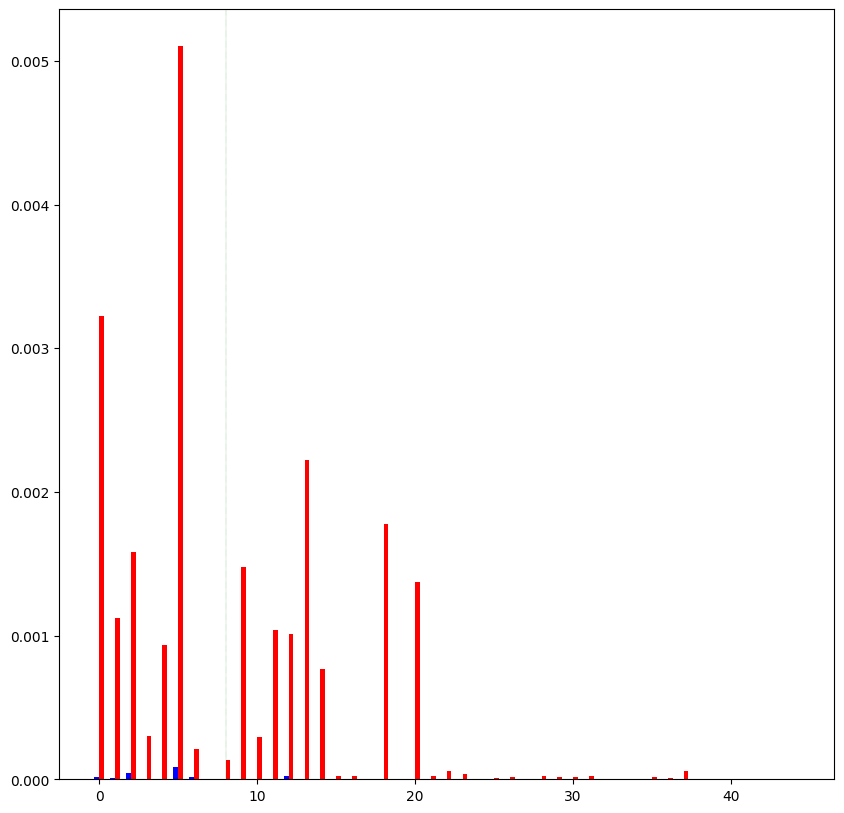

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 112/119 [00:21<00:01,  5.51it/s]

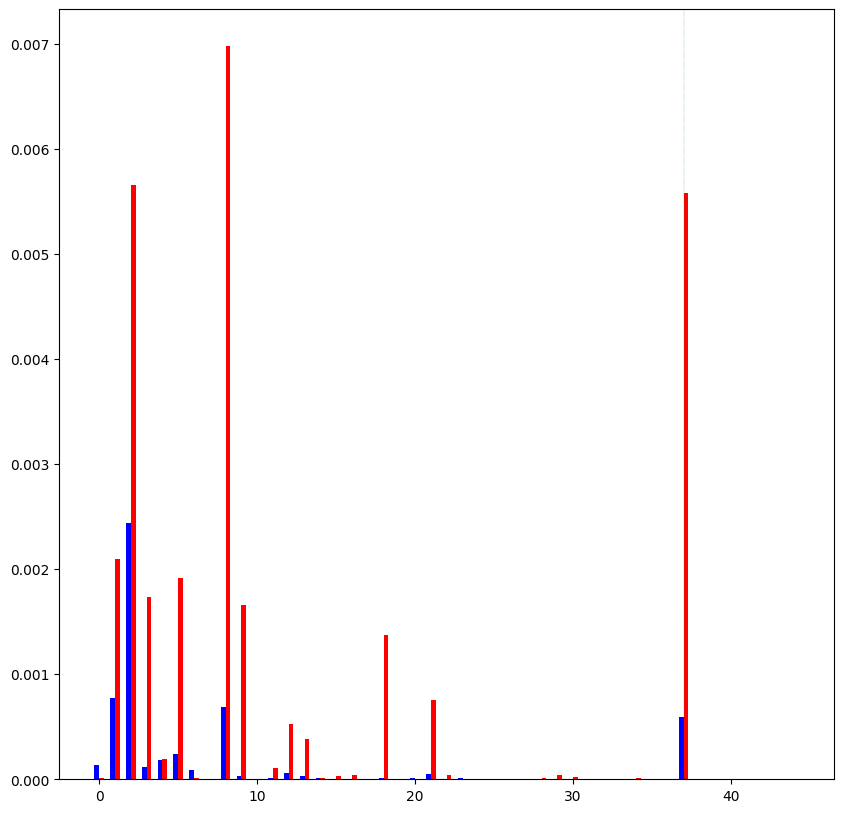

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 113/119 [00:21<00:01,  5.15it/s]

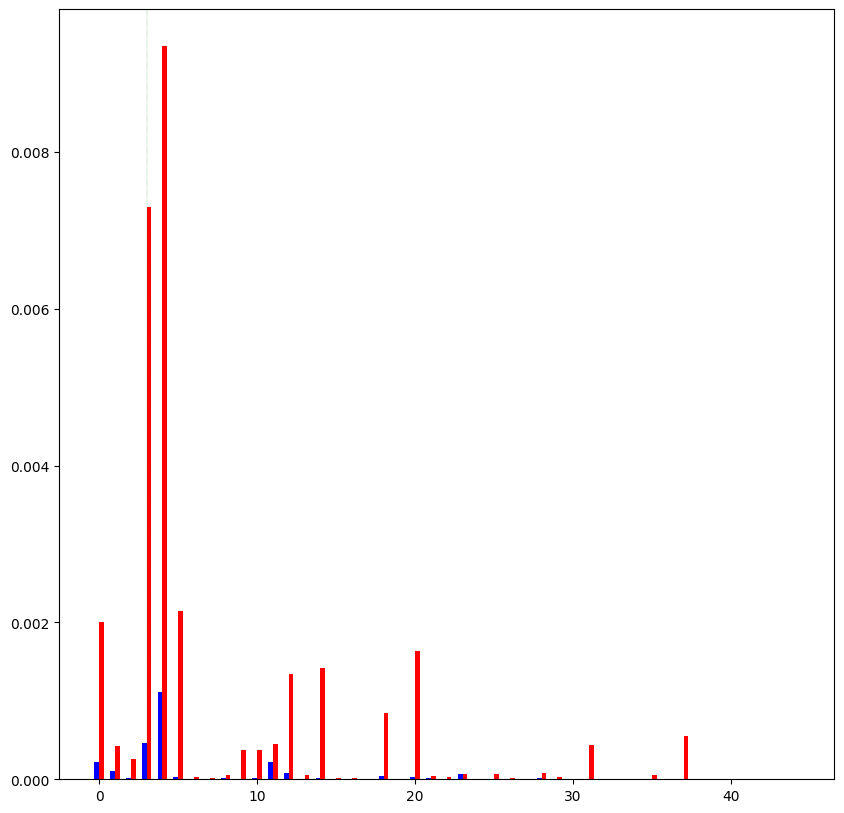

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 114/119 [00:22<00:01,  4.98it/s]

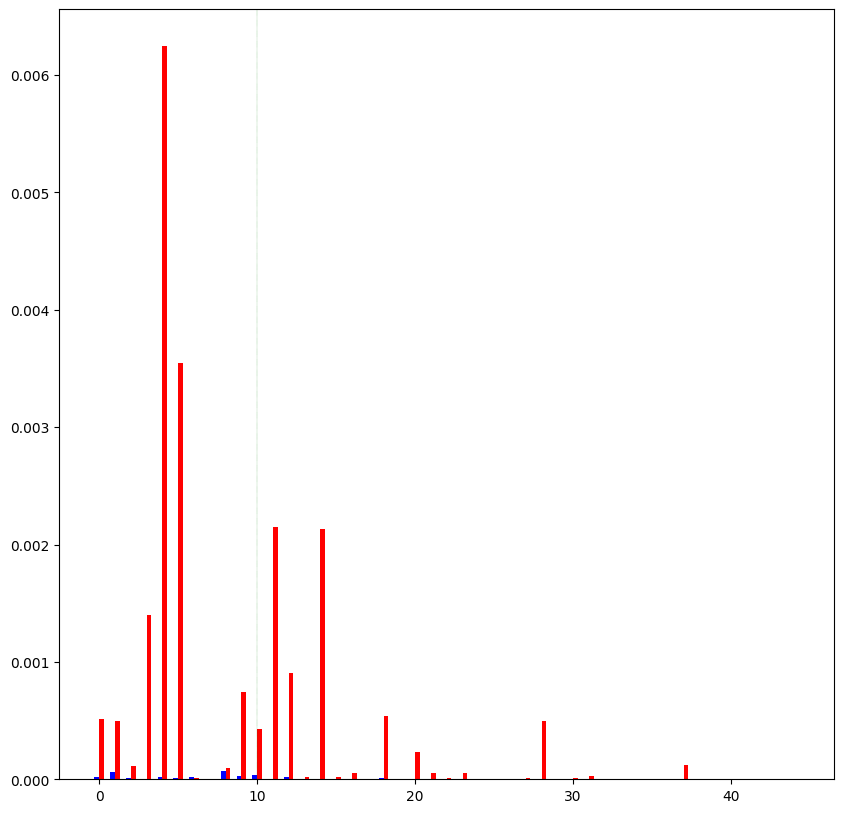

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 115/119 [00:22<00:00,  4.81it/s]

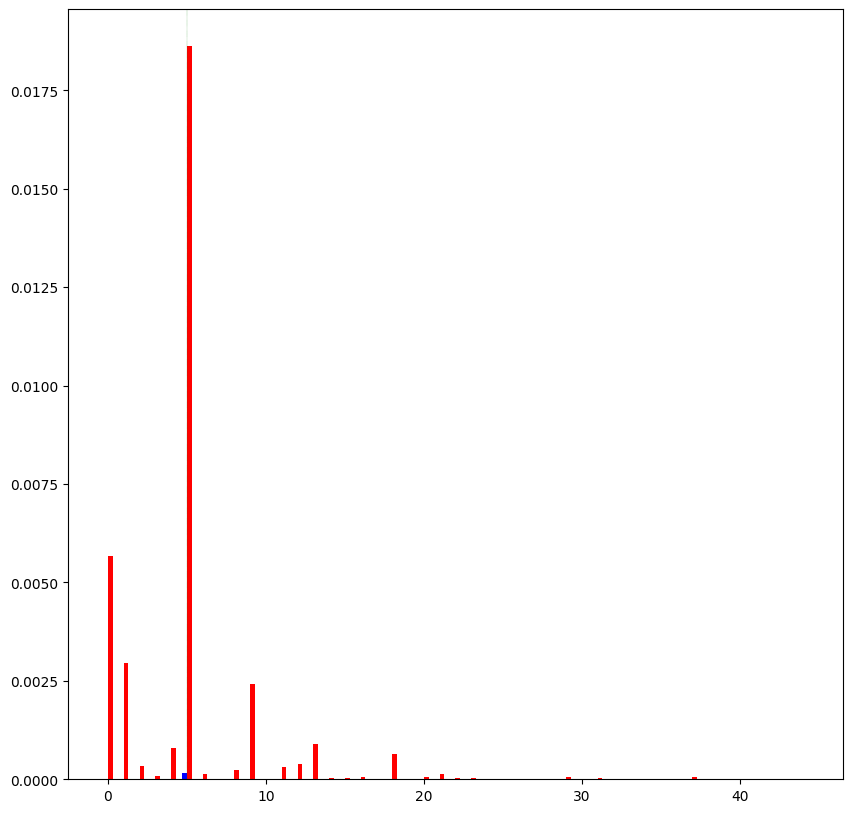

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:22<00:00,  5.29it/s]

torch.Size([119, 119, 45]) torch.Size([119, 119, 45])


In [22]:
for arcs, labels, predicted, predicted_t, probab_label, probab_label_t in \
    zip(inference_results['arcs'], inference_results['labels'], inference_results['results'], inference_results_t['results'], inference_results['probab_labels'], inference_results_t['probab_labels']):
    for token_idx, head_idx in enumerate(pbar := tqdm(arcs, )):
        if head_idx == -1: continue
        predicted_head_idx = predicted[token_idx]
        predicted_head_idx_t = predicted_t[token_idx]
        if predicted_head_idx == head_idx and predicted_head_idx_t == head_idx:
            continue
        gt_probabs = probab_label[token_idx][head_idx]
        gt_probabs_t = probab_label_t[token_idx][head_idx]
        fig = plt.figure(figsize=(10, 10))
        ax = fig.subplots(1, 1)
        # show bar plot  
        ax.bar(torch.arange(len(gt_probabs)) - 0.15, gt_probabs.exp(), color='b', width=0.3, label='original')
        ax.bar(torch.arange(len(gt_probabs)) + 0.15, gt_probabs_t.exp(), color='r', width=0.3, label='transposed')
        ax.axvline(labels[token_idx], color='g', linestyle=':', linewidth=0.3)
        plt.show()
        plt.close()

    print(probab_label.shape, probab_label_t.shape)
    break

In [78]:
with open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/label_conditional_1.pkl'), 'rb') as f1, \
    open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/label_conditional_1_transpose.pkl'), 'rb') as f2:
    label_conditional = pkl.load(f1)
    label_conditional_t = pkl.load(f2)
with open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/joint_label_1.pkl'), 'rb') as f1, \
    open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/joint_label_1_transpose.pkl'), 'rb') as f2:
    label_joint = pkl.load(f1)
    label_joint_t = pkl.load(f2)
with open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/x_1.pkl'), 'rb') as f1, \
    open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/x_1_transpose.pkl'), 'rb') as f2:
    x = pkl.load(f1)
    x_t = pkl.load(f2)

In [81]:
print(len(label_conditional[0]))
print(len(label_joint[0]))

46
46


In [68]:
def get_high_mi_heads_mass(binary_label_mi: List[List[float]], mass_proportion: float = 0.2):
    label_high_mi_heads = []
    for label_idx, this_binary_label_mi in enumerate(binary_label_mi):
        current_mass = 0
        mass_max = sum(this_binary_label_mi) * mass_proportion
        sorted_mi_heads_and_mis = sorted(enumerate(this_binary_label_mi), key=lambda x: x[1], reverse=True)
        this_label_high_mi_heads = []
        for idx, mi in sorted_mi_heads_and_mis:
            current_mass += mi
            this_label_high_mi_heads.append(idx)
            if current_mass > mass_max:
                break
        label_high_mi_heads.append(this_label_high_mi_heads)
    
    return label_high_mi_heads
with open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/mi_1.json'), 'rb') as f1, \
    open(osp.expanduser('~/pretrained-models/kde/open_llama_7b/mi_1_transpose.json'), 'rb') as f2:
    mi = json.load(f1)['binary_label_mi']
    mi_t = json.load(f2)['binary_label_mi']

high_mi_heads = get_high_mi_heads_mass(mi, 0.2)
high_mi_heads_t = get_high_mi_heads_mass(mi_t, 0.2)

In [96]:
print(len(high_mi_heads))

119


In [ ]:
def quantize_entropy(x, y):
    # calculate trapzoidal area
    area = (y[1:] + y[:-1]) * (x[1:] - x[:-1]) / 2
    # normalized
    area = area / area.sum()
    return -area @ torch.log2(area).masked_fill(area == 0, 0)

def conditional_entropy(x, joint, conditional):
    return -joint @ torch.log2(conditional).masked_fill(conditional == 0, 0)

intersection_mask = torch.isin(x, x_t).cpu()
intersection_mask_t = torch.isin(x_t, x).cpu()
shared_x = x[intersection_mask].cpu()
quantize_entropies, quantize_entropies_t = [], []
conditional_entropies, conditional_entropies_t = [], []
larger_quantize_entropies, larger_quantize_entropies_t = 0, 0
for head_idx in trange(len(label_conditional)):
    for label_idx in range(len(label_conditional[head_idx]) - 1):
        if (high_mi := (head_idx in high_mi_heads[label_idx])) and (high_mi_t := (head_idx in high_mi_heads_t[label_idx])):
            plt.figure()
            plt.plot(shared_x, label_conditional[head_idx][label_idx][intersection_mask].cpu())
            plt.plot(shared_x, label_conditional_t[head_idx][label_idx][intersection_mask_t].cpu())
            title = f"head {head_idx}, label {label_idx} {'(high)' if high_mi else ''} {'(high t)' if high_mi_t else ''}"
            plt.title(title)
            plt.show()
        # s = (f"head {head_idx}, label {label_idx}, "
        #       f"quantize_entropy = {(qe := quantize_entropy(shared_x, label_conditional[head_idx][label_idx][intersection_mask].cpu()).item())}, "
        #       f"quantize_entropy_t = {(qe_t := quantize_entropy(shared_x, label_conditional_t[head_idx][label_idx][intersection_mask_t].cpu()))}")
        # if qe > qe_t: 
        #     larger_quantize_entropies += 1
        # else:
        #     larger_quantize_entropies_t += 1
        # quantize_entropies.append(qe)
        # quantize_entropies_t.append(qe_t)

        # this_label_joint = label_joint[head_idx][label_idx][intersection_mask] / integral_torch_cuda(shared_x, label_joint[head_idx][label_idx][intersection_mask])
        # this_label_joint_t = 
        # print(f"head {head_idx}, label {label_idx}, "
        #       f"conditional_entropy = {(ce := conditional_entropy(shared_x, label_joint[head_idx][label_idx][intersection_mask], label_conditional[head_idx][label_idx][intersection_mask].cpu()).item())}, "
        #       f"conditional_entropy_t = {(ce_t := conditional_entropy(shared_x, label_joint_t[head_idx][label_idx][intersection_mask_t], label_conditional_t[head_idx][label_idx][intersection_mask_t].cpu()))}")
        # conditional_entropies.append(ce)
        # conditional_entropies_t.append(ce_t)
        # if head_idx in high_mi_heads[label_idx]:
        #     quantize_entropies.append(quantize_entropy(shared_x, label_conditional[head_idx][label_idx][intersection_mask].cpu()))
        # if head_idx in high_mi_heads_t[label_idx]:
        #     quantize_entropies_t.append(quantize_entropy(shared_x, label_conditional_t[head_idx][label_idx][intersection_mask_t].cpu()))

In [76]:
print(larger_quantize_entropies, larger_quantize_entropies_t)

25300 21804


In [86]:
# print(torch.tensor(quantize_entropies).mean(), torch.tensor(quantize_entropies_t).mean())
print(torch.tensor(conditional_entropies).mean(), torch.tensor(conditional_entropies_t).mean())

tensor(0.1435) tensor(0.0866)
